# The Transient Universe: part 2

In [1]:
import numpy as np
from scipy import stats, interpolate
import scipy.stats
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import optimize
from scipy.optimize import curve_fit
import emcee
import dynesty

plt.rcParams['figure.figsize'] = [4, 4]

#### let's take the data

Text(0.5, 1.0, 'Transient phenomenas')

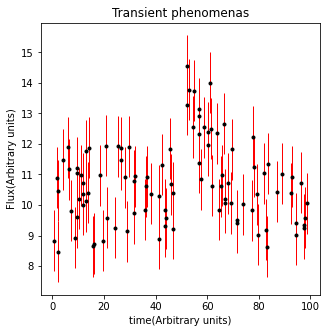

In [2]:
# Define the dimensionality of our problem.

x = np.load('../../solutions/transient.npy')
time = x[:,0]
flux = x[:,1]
d_flux = x[:,2]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, d_flux, fmt='.k', lw=1, ecolor='red')
ax.set_xlabel('time(Arbitrary units)')
ax.set_ylabel('Flux(Arbitrary units)')
ax.set_title('Transient phenomenas')

#### defining values for our problem

In [3]:
ndim = 4 #b,A,to,alpha

t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)

#### defining the two models we use to describe our data

In [4]:
def burst(t, par):
    b, A, to, alpha  = par
    return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

def gaussian(t,par):
    b, A, to, sigma  = par
    return  b+A*np.exp(-(((t-to)/sigma)**2)/2)

## Nested sampling for burst model

In [5]:
def loglike_burst(par, time):
    y = burst(time, par)
    L = -0.5*np.sum((flux-y)**2 / d_flux**2)
    
    if not np.isfinite(L):
        L = -1e300
    
    return L
 
# Define our uniform prior.
def ptform_burst(u):
    
    x = np.array(u)  # copy u, u belongs to the hypercube [0,1]

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)

    return x

In [6]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike_burst, ptform_burst, ndim, logl_args=[time], nlive=300) #nlive = 250 by default
sampler.run_nested()
sresults = sampler.results

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
0it [00:00, ?it/s]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
1050it [00:32, 16.09it/s, bound: 0 | nc: 32 | ncall: 10490 | eff(%): 10.010 | loglstar:   -inf < -193.470 <    inf | logz: -201.865 +/-  0.158 | dlogz: 129.113 >  0.309]   C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
1115it [00:35, 19.96it/s, bound: 2 | nc: 14 | ncall: 11025 | eff(%): 10.113 | loglstar:   -inf < -159.826 <    inf | logz: -168.068 

1957it [01:20,  7.48it/s, bound: 28 | nc: 19 | ncall: 23162 | eff(%):  8.449 | loglstar:   -inf < -87.326 <    inf | logz: -93.951 +/-  0.140 | dlogz: 38.312 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
1974it [01:22, 14.50it/s, bound: 29 | nc: 23 | ncall: 23574 | eff(%):  8.374 | loglstar:   -inf < -87.285 <    inf | logz: -93.890 +/-  0.140 | dlogz: 38.194 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
1980it [01:22, 14.54it/s, bound: 30 | nc: 1 | ncall: 23688 | eff(%):  8.359 | loglstar:   -inf < -87.275 <    inf | logz: -93.870 +/-  0.140 | dlogz: 38.154 > 

2120it [01:43,  2.33it/s, bound: 43 | nc: 184 | ncall: 29802 | eff(%):  7.114 | loglstar:   -inf < -87.124 <    inf | logz: -93.527 +/-  0.139 | dlogz: 37.343 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2122it [01:45,  1.43it/s, bound: 44 | nc: 268 | ncall: 30360 | eff(%):  6.989 | loglstar:   -inf < -87.121 <    inf | logz: -93.523 +/-  0.139 | dlogz: 37.333 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2124it [01:45,  2.21it/s, bound: 45 | nc: 27 | ncall: 30443 | eff(%):  6.977 | loglstar:   -inf < -87.121 <    inf | logz: -93.520 +/-  0.139 | dlogz: 37.323 

2191it [02:05,  3.10it/s, bound: 58 | nc: 238 | ncall: 36449 | eff(%):  6.011 | loglstar:   -inf < -87.094 <    inf | logz: -93.421 +/-  0.138 | dlogz: 37.001 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2193it [02:06,  2.77it/s, bound: 59 | nc: 222 | ncall: 36691 | eff(%):  5.977 | loglstar:   -inf < -87.094 <    inf | logz: -93.418 +/-  0.138 | dlogz: 36.991 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2194it [02:06,  2.46it/s, bound: 59 | nc: 181 | ncall: 36872 | eff(%):  5.950 | loglstar:   -inf < -87.094 <    inf | logz: -93.417 +/-  0.138 | dlogz: 36.987 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha

2314it [02:50,  1.02s/it, bound: 88 | nc: 1011 | ncall: 50162 | eff(%):  4.613 | loglstar:   -inf < -86.751 <    inf | logz: -93.294 +/-  0.138 | dlogz: 36.464 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2315it [02:51,  1.06s/it, bound: 89 | nc: 382 | ncall: 50544 | eff(%):  4.580 | loglstar:   -inf < -86.737 <    inf | logz: -93.293 +/-  0.138 | dlogz: 36.459 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2316it [02:52,  1.15it/s, bound: 90 | nc: 98 | ncall: 50642 | eff(%):  4.573 | loglstar:   -inf < -86.733 <    inf | logz: -93.292 +/-  0.138 | dlogz: 36.45

2334it [03:19,  1.35s/it, bound: 107 | nc: 368 | ncall: 58544 | eff(%):  3.987 | loglstar:   -inf < -86.625 <    inf | logz: -93.272 +/-  0.138 | dlogz: 36.376 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2335it [03:21,  1.60s/it, bound: 108 | nc: 581 | ncall: 59125 | eff(%):  3.949 | loglstar:   -inf < -86.624 <    inf | logz: -93.271 +/-  0.138 | dlogz: 36.371 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(

2495it [04:09,  1.48it/s, bound: 137 | nc: 272 | ncall: 72154 | eff(%):  3.458 | loglstar:   -inf < -83.348 <    inf | logz: -92.662 +/-  0.148 | dlogz: 35.238 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2501it [04:10,  3.66it/s, bound: 138 | nc: 80 | ncall: 72519 | eff(%):  3.449 | loglstar:   -inf < -83.249 <    inf | logz: -92.605 +/-  0.149 | dlogz: 35.161 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2502it [04:11,  2.62it/s, bound: 139 | nc: 170 | ncall: 72689 | eff(%):  3.442 | loglstar:   -inf < -83.194 <    inf | logz: -92.596 +/-  0.149 | dlogz: 35.

2660it [04:42, 17.57it/s, bound: 154 | nc: 23 | ncall: 79603 | eff(%):  3.342 | loglstar:   -inf < -78.969 <    inf | logz: -89.752 +/-  0.177 | dlogz: 31.793 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2697it [04:45, 15.43it/s, bound: 155 | nc: 6 | ncall: 80277 | eff(%):  3.360 | loglstar:   -inf < -77.409 <    inf | logz: -88.702 +/-  0.181 | dlogz: 30.631 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2730it [04:50,  7.42it/s, bound: 158 | nc: 53 | ncall: 81317 | eff(%):  3.357 | loglstar:   -inf < -76.276 <    inf | logz: -87.604 +/-  0.184 | dlogz: 29.420 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-

#### Now we plot a summary of the run

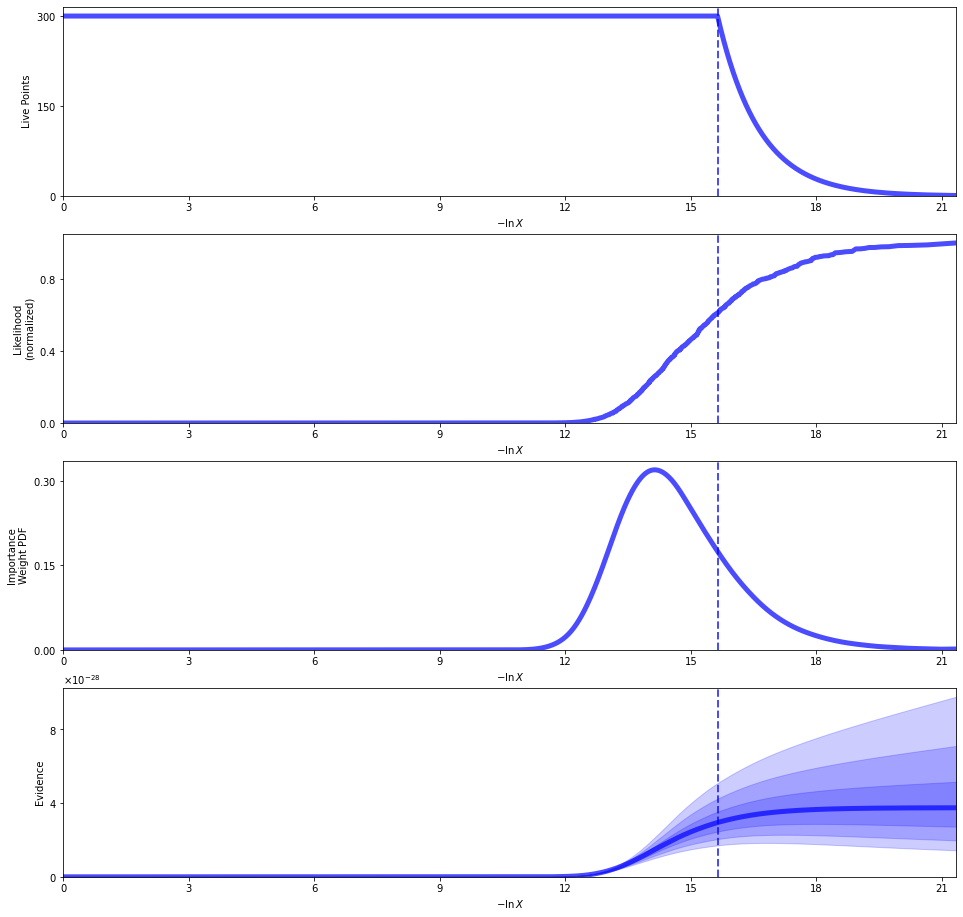

In [7]:
plt.rcParams['figure.figsize'] = [2, 2]
from dynesty import plotting as dyplot
rfig, raxes = dyplot.runplot(sresults)

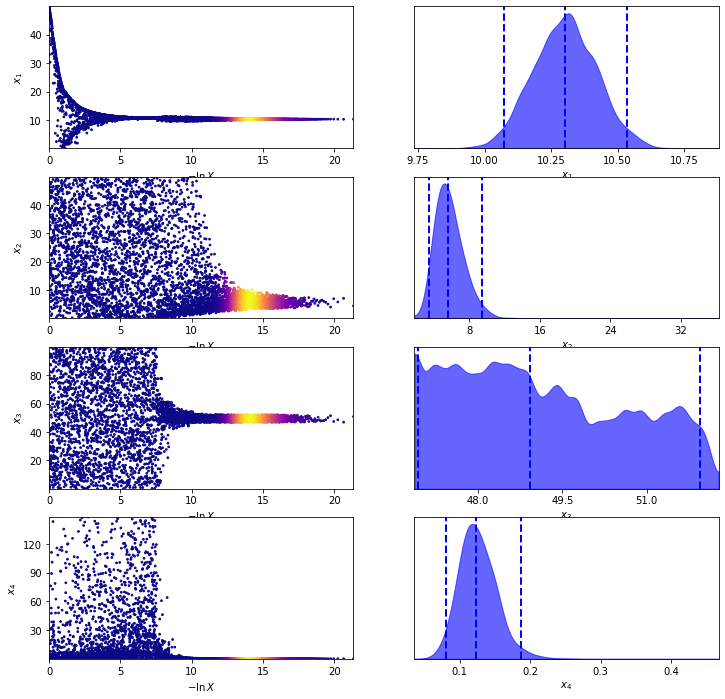

In [8]:
tfig, taxes = dyplot.traceplot(sresults)

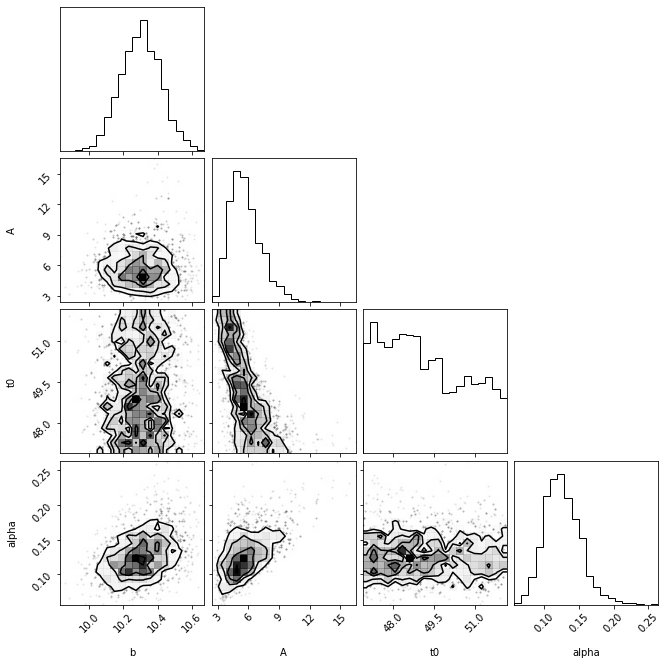

In [9]:
from dynesty import utils as dyfunc
import corner

samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

labels = ["b","A","t0","alpha"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);

In [10]:
evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 16%-84% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights) for samps in samples.T]
for i,j in zip(np.arange(0,4,1), labels):
    print(j + ": " + str(quantiles[i]) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))


Bayesian evidence 3.748359266672289e-28
b: [10.180982061378124, 10.418290633158051]

A: [4.2445044013324615, 7.277871633789419]

t0: [47.53265383245059, 51.03071869141301]

alpha: [0.10152183974845441, 0.15052690433180546]

Mean and covariance of parameters are: [10.30081694  5.72725217 49.17325377  0.12588522]
[[ 1.38801554e-02 -3.62872907e-03  9.31721604e-03  1.15313613e-03]
 [-3.62872907e-03  2.51926514e+00 -1.60660696e+00  2.25685721e-02]
 [ 9.31721604e-03 -1.60660696e+00  2.25166563e+00  1.78511750e-04]
 [ 1.15313613e-03  2.25685721e-02  1.78511750e-04  6.94064512e-04]]


In [11]:
sresults.summary()

Summary
nlive: 300
niter: 4699
ncall: 98085
eff(%):  5.097
logz: -63.151 +/-  0.320


## Gaussian Model

In [26]:
sigmamin,sigmamax=np.exp(-2),np.exp(2)


def loglike_gaussian(par, time):
    y = gaussian(time, par)
    L = -0.5*np.sum((flux-y)**2 / d_flux**2)
    
    if not np.isfinite(L):
        L = -1e300
    
    return L
 
# Define our uniform prior.
def ptform_gaussian(u):
    
    x = np.array(u)  # copy u, u belongs to the hypercube [0,1]

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3],sigmamin,sigmamax)

    return x

In [27]:
# "Static" nested sampling.
sampler_gaussian = dynesty.NestedSampler(loglike_gaussian, ptform_gaussian, ndim, logl_args=[time], nlive=300) #nlive = 250 by default
sampler_gaussian.run_nested()
sresults_gaussian = sampler_gaussian.results

2374it [02:27, 11.08it/s, bound: 73 | nc: 18 | ncall: 43183 | eff(%):  5.498 | loglstar:   -inf < -86.378 <    inf | logz: -94.168 +/-  0.147 | dlogz: 32.431 >  0.309]     C:\Users\LEONARDO\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
C:\Users\LEONARDO\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints 

C:\Users\LEONARDO\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
2637it [03:27,  4.80it/s, bound: 111 | nc: 42 | ncall: 60367 | eff(%):  4.368 | loglstar:   -inf < -79.129 <    inf | logz: -90.053 +/-  0.179 | dlogz: 27.467 >  0.309]  C:\Users\LEONARDO\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or

#### Now we plot a summary of the run

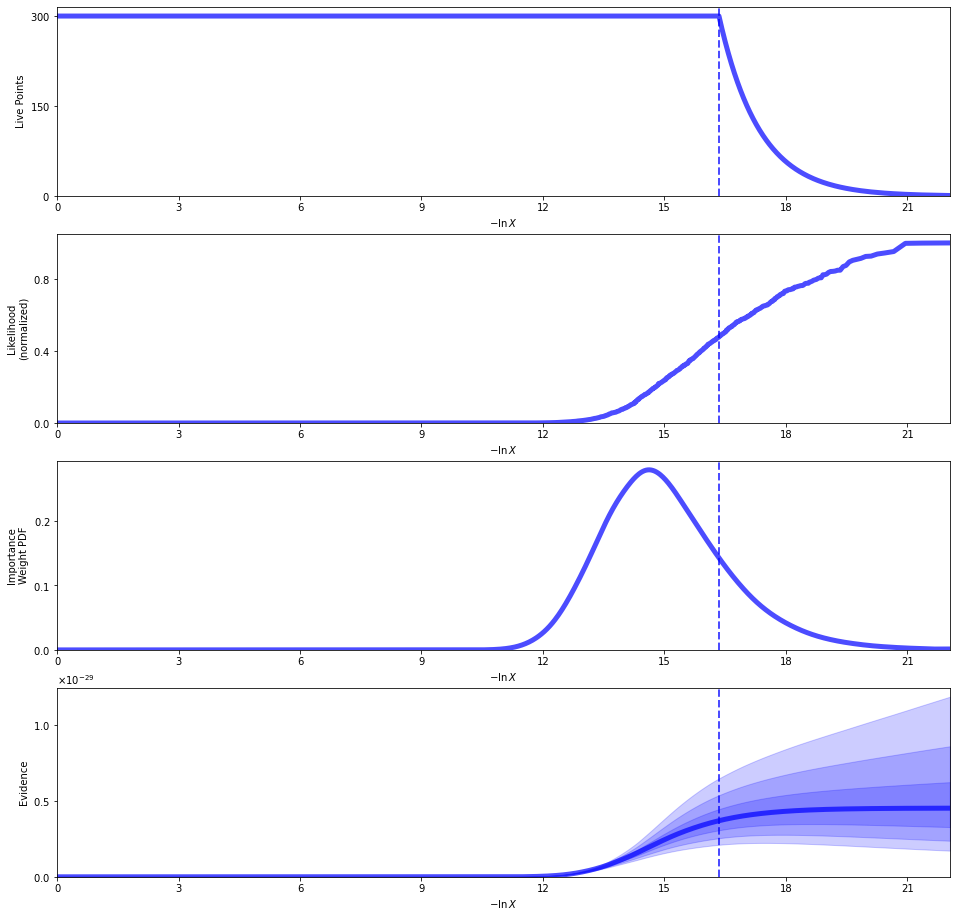

In [28]:
plt.rcParams['figure.figsize'] = [2, 2]
rfig, raxes = dyplot.runplot(sresults_gaussian)

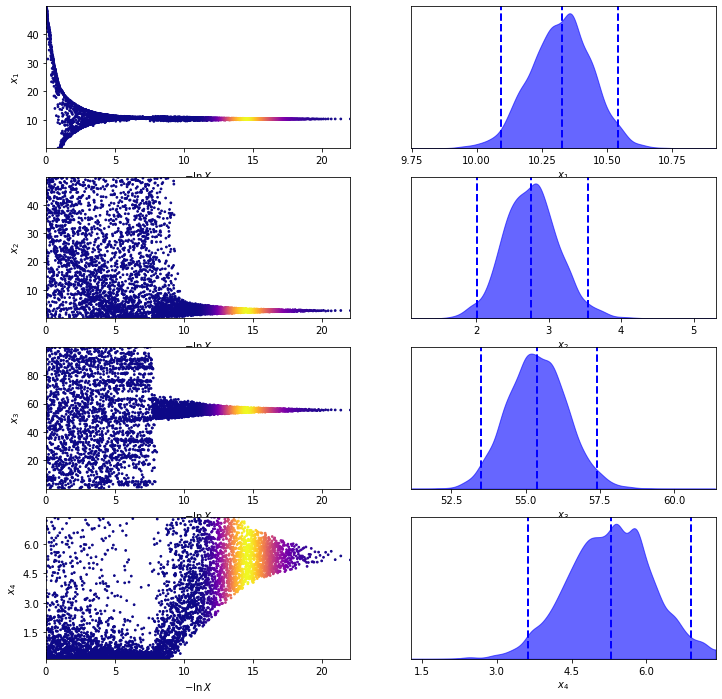

In [29]:
tfig, taxes = dyplot.traceplot(sresults_gaussian)

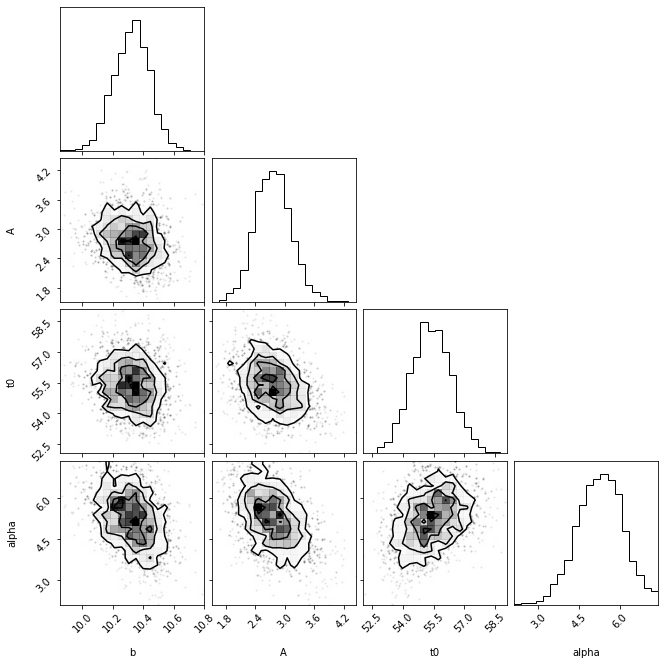

In [30]:
samples_gaussian = sresults_gaussian.samples  # samples
weights_gaussian = np.exp(sresults_gaussian.logwt - sresults_gaussian.logz[-1])  # normalized weights

labels = ["b","A","t0","alpha"]

samples_gaussian_equal = dyfunc.resample_equal(samples_gaussian, weights_gaussian)
corner.corner(samples_gaussian_equal,labels=labels);

In [32]:
evidence_gaussian = sresults_gaussian.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence_gaussian))

# Compute 16%-84% quantiles.
#quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_gaussian) for samps in samples.T]
#for i,j in zip(np.arange(0,4,1), labels):
#    print(j + ": " + str(quantiles[i]) + '\n')

# Compute weighted mean and covariance.
mean_gaussian, cov_gaussian = dyfunc.mean_and_cov(samples_gaussian, weights_gaussian)
print('Mean and covariance of parameters are: ' + str(mean_gaussian) + '\n' + str(cov_gaussian))


Bayesian evidence 4.5189869074188424e-30
Mean and covariance of parameters are: [10.32231378  2.76089997 55.38266554  5.26692174]
[[ 0.01382829 -0.00921543 -0.01713603 -0.03673459]
 [-0.00921543  0.14264348 -0.11887251 -0.14088272]
 [-0.01713603 -0.11887251  0.97304741  0.29843004]
 [-0.03673459 -0.14088272  0.29843004  0.70471015]]


## Model Comparison

To compare the two models, burst and gaussian, we relay on the computation of the Odds Ratio:

$$O_{21} = \frac{p(D\,|\,M_2,I)\,p(M_2\,|\,I)}{p(D\,|\,M_1,I)\,p(M_1\,|\,I)} $$

where $M_{1}$ is the burst model and $M_{2}$ is the gaussian model.

Supposing equal hyperpriors, we can just take the ratio between the two evidences $Z_{1}$ and $Z_{2}$.

In [38]:
O = np.exp(sresults.logz[-1])/np.exp(sresults_gaussian.logz[-1])
print("The Odds ratio is: %.3f" %O)

The Odds ratio is: 82.947


Using the Jeffrey's scale to convert the results in a qualitative phrase we can say there is a "very strong" evidence in favour of the burst model

## Robustness of the Odds Ratio 

let's variate the number of lives point to check if the odds ratio is robust with respect to the nested sampling hyperparameters

In [62]:
from tqdm import tqdm

O21 = []
live_point=np.arange(250, 500, 50)

for i in tqdm(range (5)):
    
    "Burst"
    sampler_b = dynesty.NestedSampler(loglike_burst, ptform_burst, ndim, logl_args=[time], nlive=live_point[i]) 
    sampler_b.run_nested()
    sresults_b = sampler_b.results
    evidence_b = sresults.logz[-1]
    
    "Gaussian"
    sampler_g = dynesty.NestedSampler(loglike_gaussian, ptform_gaussian, ndim, logl_args=[time], nlive=live_point[i]) 
    sampler_g.run_nested()
    sresults_g = sampler_g.results
    evidence_g = sresults.logz[-1]
    
    "Odds Ratio"
    O21.append(np.exp(sresults_b.logz[-1])/np.exp(sresults_g.logz[-1]))
    
    
O21 = np.array(O21)
print(O21)

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

0it [00:00, ?it/s]
28it [00:00, 275.63it/s, bound: 0 | nc: 1 | ncall: 279 | eff(%): 10.036 | loglstar:   -inf < -62315.399 <    inf | logz: -62321.725 +/-  0.159 | dlogz: 63190.785 >  0.259]
56it [00:00, 262.42it/s, bound: 0 | nc: 2 | ncall: 311 | eff(%): 18.006 | loglstar:   -inf < -44588.124 <    inf | logz: -44594.562 +/-  0.160 | dlogz: 46131.584 >  0.259]
83it [00:00, 254.01it/s, bound: 0 | nc: 1 | ncall: 349 | eff(%): 23.782 | loglstar:   -inf < -35620.808 <    inf | logz: -35627.354 +/-  0.162 | dlogz: 35668.845 >  0.259]
109it [00:00, 210.47it/s, bound: 0 | nc: 2 | ncall: 393 | eff(%): 27.735 | loglstar:   -

697it [00:14, 18.23it/s, bound: 0 | nc: 76 | ncall: 4785 | eff(%): 14.566 | loglstar:   -inf < -311.770 <    inf | logz: -319.157 +/-  0.163 | dlogz: 230.252 >  0.259]
702it [00:14, 22.43it/s, bound: 0 | nc: 19 | ncall: 4830 | eff(%): 14.534 | loglstar:   -inf < -306.426 <    inf | logz: -314.411 +/-  0.175 | dlogz: 226.175 >  0.259]
705it [00:14, 23.68it/s, bound: 0 | nc: 1 | ncall: 4862 | eff(%): 14.500 | loglstar:   -inf < -302.361 <    inf | logz: -310.578 +/-  0.176 | dlogz: 222.462 >  0.259] 
708it [00:14, 24.21it/s, bound: 0 | nc: 1 | ncall: 4900 | eff(%): 14.449 | loglstar:   -inf < -301.331 <    inf | logz: -308.902 +/-  0.166 | dlogz: 220.061 >  0.259]
711it [00:14, 17.96it/s, bound: 0 | nc: 20 | ncall: 5003 | eff(%): 14.211 | loglstar:   -inf < -294.470 <    inf | logz: -303.470 +/-  0.187 | dlogz: 217.553 >  0.259]
715it [00:15, 16.49it/s, bound: 0 | nc: 74 | ncall: 5109 | eff(%): 13.995 | loglstar:   -inf < -287.624 <    inf | logz: -296.396 +/-  0.179 | dlogz: 208.670 >  

986it [00:29, 56.57it/s, bound: 4 | nc: 6 | ncall: 9794 | eff(%): 10.067 | loglstar:   -inf < -126.312 <    inf | logz: -134.276 +/-  0.168 | dlogz: 51.799 >  0.259] 
997it [00:30, 71.29it/s, bound: 4 | nc: 9 | ncall: 9828 | eff(%): 10.144 | loglstar:   -inf < -122.750 <    inf | logz: -131.387 +/-  0.170 | dlogz: 49.002 >  0.259]
1005it [00:30, 62.36it/s, bound: 4 | nc: 7 | ncall: 9878 | eff(%): 10.174 | loglstar:   -inf < -121.234 <    inf | logz: -129.130 +/-  0.169 | dlogz: 46.582 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1012it [00:30, 47.00it/s, bound: 5 | nc: 2 | ncall: 9924 | eff(%): 10.198 | loglstar:   -inf < -120.528 <    inf | logz: -128.050 +/-  0.165 | dlogz: 45.391 >  0.259]
1022it [00:30, 57.24it/s, bound: 5 | nc: 3 | ncall: 9957 | eff(%): 10.264 | loglstar:   -inf < -119.198 <    inf | logz: -126.877 +/-  0.162 | dlogz: 44.195 >  0.259]

1511it [00:41, 24.14it/s, bound: 12 | nc: 1 | ncall: 12860 | eff(%): 11.750 | loglstar:   -inf < -88.322 <    inf | logz: -95.467 +/-  0.158 | dlogz: 23.775 >  0.259] 
1514it [00:41, 22.07it/s, bound: 12 | nc: 19 | ncall: 12908 | eff(%): 11.729 | loglstar:   -inf < -88.295 <    inf | logz: -95.431 +/-  0.158 | dlogz: 30.770 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1517it [00:41, 20.81it/s, bound: 13 | nc: 13 | ncall: 12924 | eff(%): 11.738 | loglstar:   -inf < -88.273 <    inf | logz: -95.396 +/-  0.158 | dlogz: 30.722 >  0.259]
1520it [00:41, 20.57it/s, bound: 13 | nc: 9 | ncall: 12968 | eff(%): 11.721 | loglstar:   -inf < -88.260 <    inf | logz: -95.361 +/-  0.158 | dlogz: 30.675 

1708it [00:59, 26.17it/s, bound: 26 | nc: 12 | ncall: 18142 | eff(%):  9.415 | loglstar:   -inf < -87.324 <    inf | logz: -94.099 +/-  0.155 | dlogz: 33.617 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1711it [01:01,  5.63it/s, bound: 28 | nc: 597 | ncall: 18759 | eff(%):  9.121 | loglstar:   -inf < -87.318 <    inf | logz: -94.087 +/-  0.155 | dlogz: 33


1769it [01:10,  9.31it/s, bound: 36 | nc: 69 | ncall: 21632 | eff(%):  8.178 | loglstar:   -inf < -87.208 <    inf | logz: -93.901 +/-  0.154 | dlogz: 33.174 >  0.259]
1771it [01:11,  8.84it/s, bound: 36 | nc: 42 | ncall: 21721 | eff(%):  8.153 | loglstar:   -inf < -87.207 <    inf | logz: -93.895 +/-  0.154 | dlogz: 33.160 >  0.259]
1772it [01:11,  8.29it/s, bound: 36 | nc: 48 | ncall: 21769 | eff(%):  8.140 | loglstar:   -inf < -87.198 <    inf | logz: -93.892 +/-  0.154 | dlogz: 33.154 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1773it [01:11,  4.74it/s, bound: 37 | nc: 169 | ncall: 21938 | eff(%):  8.082 | loglstar:   -inf < -87.197 <    inf | logz: -93.890 +/-  0.154 | dlogz: 33.147 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alp


1826it [01:21,  2.51it/s, bound: 45 | nc: 255 | ncall: 25008 | eff(%):  7.302 | loglstar:   -inf < -87.137 <    inf | logz: -93.764 +/-  0.154 | dlogz: 32.809 >  0.259]
1828it [01:22,  3.14it/s, bound: 45 | nc: 132 | ncall: 25147 | eff(%):  7.269 | loglstar:   -inf < -87.133 <    inf | logz: -93.760 +/-  0.154 | dlogz: 32.797 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1829it [01:22,  2.74it/s, bound: 46 | nc: 160 | ncall: 25307 | eff(%):  7.227 | loglstar:   -inf < -87.133 <    inf | logz: -93.758 +/-  0.154 | dlogz: 32.791 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1830it [01:23,  2.74it/s, bound: 46 | nc: 128 | ncall: 25435 | eff(%):  7.195 | loglstar:   -inf < -87.132 <    inf | logz: -93.756 +/-  0.154 | dlogz: 3

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1870it [01:32,  1.38it/s, bound: 53 | nc: 587 | ncall: 28155 | eff(%):  6.642 | loglstar:   -inf < -87.109 <    inf | logz: -93.683 +/-  0.153 | dlogz: 32.552 >  0.259]
1871it [01:32,  1.77it/s, bound: 53 | nc: 61 | ncall: 28216 | eff(%):  6.631 | loglstar:   -inf < -87.109 <    inf | logz: -93.681 +/-  0.153 | dlogz: 32.546 >  0.259] 
1872it [01:32,  2.31it/s, bound: 53 | nc: 40 | ncall: 28256 | eff(%):  6.625 | loglstar:   -inf < -87.109 <    inf | logz: -93.680 +/-  0.153 | dlogz: 32.541 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alp


1899it [01:45,  2.39it/s, bound: 64 | nc: 43 | ncall: 32073 | eff(%):  5.921 | loglstar:   -inf < -87.098 <    inf | logz: -93.639 +/-  0.153 | dlogz: 32.392 >  0.259]
1900it [01:45,  2.49it/s, bound: 64 | nc: 120 | ncall: 32193 | eff(%):  5.902 | loglstar:   -inf < -87.097 <    inf | logz: -93.637 +/-  0.153 | dlogz: 32.386 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1901it [01:46,  1.97it/s, bound: 65 | nc: 255 | ncall: 32448 | eff(%):  5.859 | loglstar:   -inf < -87.097 <    inf | logz: -93.636 +/-  0.153 | dlogz: 32.381 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alp

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1951it [02:17,  1.02s/it, bound: 92 | nc: 734 | ncall: 42747 | eff(%):  4.564 | loglstar:   -inf < -87.090 <    inf | logz: -93.574 +/-  0.153 | dlogz: 32.119 >  0.259]
1953it [02:17,  1.68it/s, bound: 92 | nc: 15 | ncall: 42772 | eff(%):  4.566 | loglstar:   -inf < -87.090 <    inf | logz: -93.572 +/-  0.153 | dlogz: 32.109 >  0.259] 
1954it [02:17,  1.95it/s, bound: 92 | nc: 57 | ncall: 42829 | eff(%):  4.562 | loglstar:   -inf < -87.090 <    inf | logz: -93.571 +/-  0.153 | dlogz: 32.104 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alp

1980it [02:31,  1.47it/s, bound: 103 | nc: 152 | ncall: 46690 | eff(%):  4.241 | loglstar:   -inf < -87.065 <    inf | logz: -93.545 +/-  0.153 | dlogz: 31.974 >  0.259]
1981it [02:31,  1.80it/s, bound: 103 | nc: 58 | ncall: 46748 | eff(%):  4.238 | loglstar:   -inf < -87.061 <    inf | logz: -93.544 +/-  0.153 | dlogz: 31.969 >  0.259] 
1982it [02:31,  1.75it/s, bound: 103 | nc: 178 | ncall: 46926 | eff(%):  4.224 | loglstar:   -inf < -87.055 <    inf | logz: -93.543 +/-  0.153 | dlogz: 31.964 >  0.259]
1983it [02:32,  2.13it/s, bound: 103 | nc: 49 | ncall: 46975 | eff(%):  4.221 | loglstar:   -inf < -87.052 <    inf | logz: -93.542 +/-  0.153 | dlogz: 31.959 >  0.259] 
1984it [02:32,  2.73it/s, bound: 103 | nc: 27 | ncall: 47002 | eff(%):  4.221 | loglstar:   -inf < -87.050 <    inf | logz: -93.541 +/-  0.153 | dlogz: 31.954 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-


2028it [03:01,  1.76it/s, bound: 129 | nc: 273 | ncall: 56514 | eff(%):  3.588 | loglstar:   -inf < -86.674 <    inf | logz: -93.496 +/-  0.153 | dlogz: 31.733 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2030it [03:02,  1.81it/s, bound: 130 | nc: 328 | ncall: 56852 | eff(%):  3.571 | loglstar:   -inf < -86.660 <    inf | logz: -93.493 +/-  0.153 | dlogz: 31.723 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2032it [03:03,  2.26it/s, bound: 130 | nc: 159 | ncall: 57030 | eff(%):  3.563 | loglstar:   -inf < -86.656 <    inf | logz: -93.491 +/-  0.153 | dlogz: 31.713 >  0.259]C:\Users\LEONARDO\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from b

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp

2124it [03:43,  5.03it/s, bound: 165 | nc: 76 | ncall: 69982 | eff(%):  3.035 | loglstar:   -inf < -84.985 <    inf | logz: -93.320 +/-  0.154 | dlogz: 35.413 >  0.259]
2125it [03:43,  4.79it/s, bound: 165 | nc: 74 | ncall: 70056 | eff(%):  3.033 | loglstar:   -inf < -84.983 <    inf | logz: -93.316 +/-  0.154 | dlogz: 35.406 >  0.259]
2126it [03:43,  5.13it/s, bound: 165 | nc: 49 | ncall: 70105 | eff(%):  3.033 | loglstar:   -inf < -84.958 <    inf | logz: -93.313 +/-  0.154 | dlogz: 35.398 >  0.259]
2128it [03:44,  6.07it/s, bound: 165 | nc: 58 | ncall: 70180 | eff(%):  3.032 | loglstar:   -inf < -84.898 <    inf | logz: -93.306 +/-  0.155 | dlogz: 35.383 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-a

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2215it [04:01,  4.44it/s, bound: 180 | nc: 121 | ncall: 75648 | eff(%):  2.928 | loglstar:   -inf < -82.456 <    inf | logz: -92.605 +/-  0.171 | dlogz: 34.346 >  0.259]
2216it [04:02,  3.93it/s, bound: 180 | nc: 116 | ncall: 75764 | eff(%):  2.925 | loglstar:   -inf < -82.450 <    inf | logz: -92.590 +/-  0.171 | dlogz: 34.327 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2217it [04:02,  3.00it/s, bound: 181 | nc: 167 | ncall: 75931 | eff(%):  2.920 | loglstar:   -inf < -82.404 <    inf | logz: -92.575 +/-  0.171 | dlogz: 34.308 >  0.259]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np

2438it [04:18, 18.31it/s, bound: 193 | nc: 1 | ncall: 80557 | eff(%):  3.026 | loglstar:   -inf < -74.427 <    inf | logz: -86.267 +/-  0.207 | dlogz: 27.136 >  0.259] 
2441it [04:18, 16.52it/s, bound: 193 | nc: 49 | ncall: 80629 | eff(%):  3.027 | loglstar:   -inf < -74.346 <    inf | logz: -86.169 +/-  0.207 | dlogz: 27.026 >  0.259]
2443it [04:18, 16.06it/s, bound: 193 | nc: 37 | ncall: 80674 | eff(%):  3.028 | loglstar:   -inf < -74.244 <    inf | logz: -86.104 +/-  0.207 | dlogz: 26.954 >  0.259]
2447it [04:18, 18.29it/s, bound: 193 | nc: 30 | ncall: 80725 | eff(%):  3.031 | loglstar:   -inf < -74.198 <    inf | logz: -85.980 +/-  0.207 | dlogz: 26.811 >  0.259]
2451it [04:18, 19.95it/s, bound: 193 | nc: 36 | ncall: 80774 | eff(%):  3.034 | loglstar:   -inf < -74.119 <    inf | logz: -85.865 +/-  0.207 | dlogz: 26.678 >  0.259]
2454it [04:18, 18.93it/s, bound: 194 | nc: 1 | ncall: 80797 | eff(%):  3.037 | loglstar:   -inf < -73.913 <    inf | logz: -85.773 +/-  0.207 | dlogz: 26.5

2889it [04:32, 43.77it/s, bound: 204 | nc: 17 | ncall: 84635 | eff(%):  3.413 | loglstar:   -inf < -60.209 <    inf | logz: -73.441 +/-  0.220 | dlogz: 12.920 >  0.259]
2897it [04:32, 51.25it/s, bound: 204 | nc: 7 | ncall: 84668 | eff(%):  3.422 | loglstar:   -inf < -59.940 <    inf | logz: -73.255 +/-  0.220 | dlogz: 12.703 >  0.259] 
2905it [04:32, 56.69it/s, bound: 204 | nc: 1 | ncall: 84701 | eff(%):  3.430 | loglstar:   -inf < -59.739 <    inf | logz: -73.070 +/-  0.221 | dlogz: 12.538 >  0.259]
2911it [04:32, 57.42it/s, bound: 204 | nc: 5 | ncall: 84733 | eff(%):  3.435 | loglstar:   -inf < -59.598 <    inf | logz: -72.936 +/-  0.221 | dlogz: 12.379 >  0.259]
2917it [04:32, 53.37it/s, bound: 204 | nc: 6 | ncall: 84777 | eff(%):  3.441 | loglstar:   -inf < -59.452 <    inf | logz: -72.805 +/-  0.221 | dlogz: 12.223 >  0.259]
2923it [04:33, 48.57it/s, bound: 204 | nc: 18 | ncall: 84825 | eff(%):  3.446 | loglstar:   -inf < -59.127 <    inf | logz: -72.664 +/-  0.221 | dlogz: 12.062

3389it [04:48, 61.96it/s, bound: 216 | nc: 3 | ncall: 89159 | eff(%):  3.801 | loglstar:   -inf < -52.012 <    inf | logz: -66.185 +/-  0.228 | dlogz:  3.917 >  0.259]
3396it [04:48, 61.27it/s, bound: 216 | nc: 6 | ncall: 89191 | eff(%):  3.808 | loglstar:   -inf < -51.947 <    inf | logz: -66.133 +/-  0.228 | dlogz:  3.838 >  0.259]
3404it [04:48, 65.91it/s, bound: 216 | nc: 6 | ncall: 89220 | eff(%):  3.815 | loglstar:   -inf < -51.844 <    inf | logz: -66.072 +/-  0.228 | dlogz:  3.748 >  0.259]
3412it [04:48, 64.47it/s, bound: 216 | nc: 12 | ncall: 89259 | eff(%):  3.823 | loglstar:   -inf < -51.767 <    inf | logz: -66.012 +/-  0.228 | dlogz:  3.658 >  0.259]
3419it [04:48, 65.54it/s, bound: 216 | nc: 1 | ncall: 89291 | eff(%):  3.829 | loglstar:   -inf < -51.725 <    inf | logz: -65.960 +/-  0.228 | dlogz:  3.580 >  0.259] 
3426it [04:48, 61.54it/s, bound: 216 | nc: 5 | ncall: 89334 | eff(%):  3.835 | loglstar:   -inf < -51.658 <    inf | logz: -65.911 +/-  0.228 | dlogz:  3.505 

4059it [05:01, 48.34it/s, bound: 226 | nc: 5 | ncall: 92791 | eff(%):  4.374 | loglstar:   -inf < -49.325 <    inf | logz: -64.060 +/-  0.231 | dlogz:  0.340 >  0.259]
4065it [05:01, 46.89it/s, bound: 226 | nc: 3 | ncall: 92835 | eff(%):  4.379 | loglstar:   -inf < -49.318 <    inf | logz: -64.054 +/-  0.231 | dlogz:  0.332 >  0.259]
4071it [05:01, 43.41it/s, bound: 226 | nc: 1 | ncall: 92883 | eff(%):  4.383 | loglstar:   -inf < -49.316 <    inf | logz: -64.049 +/-  0.231 | dlogz:  0.324 >  0.259]
4076it [05:01, 38.06it/s, bound: 226 | nc: 12 | ncall: 92944 | eff(%):  4.385 | loglstar:   -inf < -49.310 <    inf | logz: -64.044 +/-  0.231 | dlogz:  0.317 >  0.259]
4081it [05:01, 30.99it/s, bound: 226 | nc: 35 | ncall: 93023 | eff(%):  4.387 | loglstar:   -inf < -49.306 <    inf | logz: -64.040 +/-  0.231 | dlogz:  0.310 >  0.259]
4085it [05:02, 28.81it/s, bound: 226 | nc: 9 | ncall: 93081 | eff(%):  4.389 | loglstar:   -inf < -49.301 <    inf | logz: -64.037 +/-  0.231 | dlogz:  0.305 

648it [00:11, 17.05it/s, bound: 0 | nc: 14 | ncall: 3626 | eff(%): 17.871 | loglstar:   -inf < -646.707 <    inf | logz: -654.460 +/-  0.175 | dlogz: 571.693 >  0.259]
651it [00:11, 19.41it/s, bound: 0 | nc: 2 | ncall: 3652 | eff(%): 17.826 | loglstar:   -inf < -642.278 <    inf | logz: -650.877 +/-  0.179 | dlogz: 569.023 >  0.259] 
654it [00:11, 21.04it/s, bound: 0 | nc: 23 | ncall: 3686 | eff(%): 17.743 | loglstar:   -inf < -636.432 <    inf | logz: -644.663 +/-  0.175 | dlogz: 562.150 >  0.259]
660it [00:11, 27.83it/s, bound: 0 | nc: 17 | ncall: 3728 | eff(%): 17.704 | loglstar:   -inf < -618.494 <    inf | logz: -625.989 +/-  0.170 | dlogz: 542.675 >  0.259]
664it [00:11, 29.77it/s, bound: 0 | nc: 15 | ncall: 3759 | eff(%): 17.664 | loglstar:   -inf < -610.914 <    inf | logz: -619.361 +/-  0.177 | dlogz: 537.072 >  0.259]
668it [00:11, 21.52it/s, bound: 0 | nc: 23 | ncall: 3858 | eff(%): 17.315 | loglstar:   -inf < -602.007 <    inf | logz: -609.783 +/-  0.173 | dlogz: 526.779 > 

942it [00:28, 48.36it/s, bound: 1 | nc: 2 | ncall: 9113 | eff(%): 10.337 | loglstar:   -inf < -194.808 <    inf | logz: -203.009 +/-  0.175 | dlogz: 118.335 >  0.259]
947it [00:28, 41.81it/s, bound: 2 | nc: 7 | ncall: 9127 | eff(%): 10.376 | loglstar:   -inf < -192.532 <    inf | logz: -201.096 +/-  0.174 | dlogz: 116.546 >  0.259]
952it [00:28, 40.20it/s, bound: 2 | nc: 4 | ncall: 9164 | eff(%): 10.388 | loglstar:   -inf < -187.516 <    inf | logz: -196.615 +/-  0.185 | dlogz: 112.608 >  0.259]
957it [00:28, 41.01it/s, bound: 2 | nc: 10 | ncall: 9194 | eff(%): 10.409 | loglstar:   -inf < -182.766 <    inf | logz: -191.948 +/-  0.181 | dlogz: 107.669 >  0.259]
962it [00:29, 40.23it/s, bound: 2 | nc: 4 | ncall: 9235 | eff(%): 10.417 | loglstar:   -inf < -179.939 <    inf | logz: -188.914 +/-  0.178 | dlogz: 104.433 >  0.259] 
969it [00:29, 47.40it/s, bound: 2 | nc: 2 | ncall: 9259 | eff(%): 10.465 | loglstar:   -inf < -172.811 <    inf | logz: -182.293 +/-  0.185 | dlogz: 98.346 >  0.25

1373it [00:43, 21.86it/s, bound: 12 | nc: 9 | ncall: 13136 | eff(%): 10.452 | loglstar:   -inf < -97.239 <    inf | logz: -105.510 +/-  0.169 | dlogz: 39.603 >  0.259]
1376it [00:43, 22.71it/s, bound: 12 | nc: 3 | ncall: 13166 | eff(%): 10.451 | loglstar:   -inf < -96.836 <    inf | logz: -105.287 +/-  0.170 | dlogz: 39.381 >  0.259]
1380it [00:43, 25.66it/s, bound: 12 | nc: 4 | ncall: 13196 | eff(%): 10.458 | loglstar:   -inf < -96.409 <    inf | logz: -104.950 +/-  0.171 | dlogz: 39.037 >  0.259]
1383it [00:44, 17.57it/s, bound: 13 | nc: 38 | ncall: 13258 | eff(%): 10.431 | loglstar:   -inf < -96.190 <    inf | logz: -104.695 +/-  0.171 | dlogz: 38.767 >  0.259]
1386it [00:44, 13.10it/s, bound: 13 | nc: 83 | ncall: 13385 | eff(%): 10.355 | loglstar:   -inf < -95.906 <    inf | logz: -104.460 +/-  0.172 | dlogz: 38.518 >  0.259]
1388it [00:44, 13.45it/s, bound: 13 | nc: 35 | ncall: 13424 | eff(%): 10.340 | loglstar:   -inf < -95.863 <    inf | logz: -104.306 +/-  0.172 | dlogz: 38.351

1665it [01:06, 10.99it/s, bound: 29 | nc: 7 | ncall: 19384 | eff(%):  8.590 | loglstar:   -inf < -88.404 <    inf | logz: -96.151 +/-  0.166 | dlogz: 30.391 >  0.259] 
1667it [01:06,  9.89it/s, bound: 29 | nc: 52 | ncall: 19457 | eff(%):  8.568 | loglstar:   -inf < -88.380 <    inf | logz: -96.127 +/-  0.166 | dlogz: 30.360 >  0.259]
1670it [01:07,  8.85it/s, bound: 29 | nc: 121 | ncall: 19591 | eff(%):  8.524 | loglstar:   -inf < -88.332 <    inf | logz: -96.091 +/-  0.166 | dlogz: 30.312 >  0.259]
1672it [01:07,  9.14it/s, bound: 30 | nc: 5 | ncall: 19620 | eff(%):  8.522 | loglstar:   -inf < -88.325 <    inf | logz: -96.068 +/-  0.166 | dlogz: 30.280 >  0.259]  
1674it [01:07,  9.93it/s, bound: 30 | nc: 15 | ncall: 19663 | eff(%):  8.513 | loglstar:   -inf < -88.307 <    inf | logz: -96.045 +/-  0.166 | dlogz: 30.249 >  0.259]
1677it [01:07, 11.60it/s, bound: 30 | nc: 35 | ncall: 19721 | eff(%):  8.504 | loglstar:   -inf < -88.285 <    inf | logz: -96.011 +/-  0.165 | dlogz: 30.203 

1887it [01:33,  1.92it/s, bound: 49 | nc: 296 | ncall: 27047 | eff(%):  6.977 | loglstar:   -inf < -87.159 <    inf | logz: -94.624 +/-  0.163 | dlogz: 33.337 >  0.259]
1889it [01:33,  3.27it/s, bound: 49 | nc: 10 | ncall: 27067 | eff(%):  6.979 | loglstar:   -inf < -87.151 <    inf | logz: -94.616 +/-  0.163 | dlogz: 33.322 >  0.259] 
1890it [01:33,  3.80it/s, bound: 49 | nc: 17 | ncall: 27084 | eff(%):  6.978 | loglstar:   -inf < -87.146 <    inf | logz: -94.613 +/-  0.163 | dlogz: 33.314 >  0.259]
1891it [01:34,  2.31it/s, bound: 50 | nc: 182 | ncall: 27266 | eff(%):  6.935 | loglstar:   -inf < -87.144 <    inf | logz: -94.609 +/-  0.163 | dlogz: 33.306 >  0.259]
1893it [01:34,  3.33it/s, bound: 50 | nc: 74 | ncall: 27342 | eff(%):  6.923 | loglstar:   -inf < -87.141 <    inf | logz: -94.602 +/-  0.163 | dlogz: 33.291 >  0.259] 
1894it [01:34,  3.94it/s, bound: 50 | nc: 25 | ncall: 27367 | eff(%):  6.921 | loglstar:   -inf < -87.141 <    inf | logz: -94.598 +/-  0.163 | dlogz: 33.28

1995it [02:39,  2.51s/it, bound: 103 | nc: 714 | ncall: 47148 | eff(%):  4.231 | loglstar:   -inf < -86.444 <    inf | logz: -94.298 +/-  0.162 | dlogz: 32.579 >  0.259] 
1996it [02:40,  1.99s/it, bound: 103 | nc: 134 | ncall: 47282 | eff(%):  4.221 | loglstar:   -inf < -86.425 <    inf | logz: -94.294 +/-  0.162 | dlogz: 32.572 >  0.259]C:\Users\LEONARDO\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(

1997it [02:41,  1.78s/it, bound: 104 | nc: 346 | ncall: 47628 | eff(%):  4.193 | loglstar:   -inf < -86.423 <    inf | logz: -94.290 +/-  0.162 | dlogz: 32.564 >  0.259]C:\Users\LEONARDO\ana

2098it [03:11, 10.45it/s, bound: 128 | nc: 18 | ncall: 56704 | eff(%):  3.700 | loglstar:   -inf < -83.144 <    inf | logz: -93.131 +/-  0.178 | dlogz: 31.018 >  0.259]
2101it [03:12, 13.69it/s, bound: 128 | nc: 7 | ncall: 56732 | eff(%):  3.703 | loglstar:   -inf < -83.077 <    inf | logz: -93.071 +/-  0.179 | dlogz: 30.946 >  0.259] 
2103it [03:13,  3.68it/s, bound: 130 | nc: 144 | ncall: 57259 | eff(%):  3.673 | loglstar:   -inf < -82.989 <    inf | logz: -93.030 +/-  0.179 | dlogz: 30.898 >  0.259]
2105it [03:13,  4.33it/s, bound: 130 | nc: 69 | ncall: 57335 | eff(%):  3.671 | loglstar:   -inf < -82.922 <    inf | logz: -92.988 +/-  0.180 | dlogz: 30.848 >  0.259] 
2107it [03:14,  4.08it/s, bound: 131 | nc: 136 | ncall: 57493 | eff(%):  3.665 | loglstar:   -inf < -82.852 <    inf | logz: -92.946 +/-  0.180 | dlogz: 30.799 >  0.259]
2110it [03:14,  5.35it/s, bound: 131 | nc: 66 | ncall: 57574 | eff(%):  3.665 | loglstar:   -inf < -82.722 <    inf | logz: -92.881 +/-  0.181 | dlogz: 

2218it [03:48,  1.94it/s, bound: 158 | nc: 37 | ncall: 67941 | eff(%):  3.265 | loglstar:   -inf < -79.344 <    inf | logz: -90.160 +/-  0.195 | dlogz: 27.577 >  0.259]
2219it [03:48,  1.94it/s, bound: 159 | nc: 138 | ncall: 68079 | eff(%):  3.259 | loglstar:   -inf < -79.240 <    inf | logz: -90.131 +/-  0.195 | dlogz: 27.544 >  0.259]
2220it [03:48,  2.09it/s, bound: 159 | nc: 116 | ncall: 68195 | eff(%):  3.255 | loglstar:   -inf < -79.219 <    inf | logz: -90.100 +/-  0.195 | dlogz: 27.511 >  0.259]
2221it [03:49,  2.29it/s, bound: 159 | nc: 107 | ncall: 68302 | eff(%):  3.252 | loglstar:   -inf < -79.193 <    inf | logz: -90.070 +/-  0.195 | dlogz: 27.476 >  0.259]C:\Users\LEONARDO\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. Yo

2505it [04:16, 60.87it/s, bound: 181 | nc: 6 | ncall: 76434 | eff(%):  3.277 | loglstar:   -inf < -71.040 <    inf | logz: -82.857 +/-  0.206 | dlogz: 19.124 >  0.259]
2512it [04:16, 63.14it/s, bound: 181 | nc: 6 | ncall: 76462 | eff(%):  3.285 | loglstar:   -inf < -70.832 <    inf | logz: -82.682 +/-  0.206 | dlogz: 18.921 >  0.259]
2519it [04:16, 62.52it/s, bound: 181 | nc: 6 | ncall: 76492 | eff(%):  3.293 | loglstar:   -inf < -70.542 <    inf | logz: -82.500 +/-  0.207 | dlogz: 18.713 >  0.259]
2526it [04:16, 59.34it/s, bound: 181 | nc: 1 | ncall: 76533 | eff(%):  3.301 | loglstar:   -inf < -70.380 <    inf | logz: -82.317 +/-  0.207 | dlogz: 18.501 >  0.259]
2533it [04:16, 56.96it/s, bound: 181 | nc: 6 | ncall: 76571 | eff(%):  3.308 | loglstar:   -inf < -70.174 <    inf | logz: -82.142 +/-  0.207 | dlogz: 18.297 >  0.259]
2539it [04:17, 53.19it/s, bound: 181 | nc: 1 | ncall: 76606 | eff(%):  3.314 | loglstar:   -inf < -70.030 <    inf | logz: -81.988 +/-  0.208 | dlogz: 18.119 > 

3286it [04:28, 99.64it/s, bound: 190 | nc: 3 | ncall: 79735 | eff(%):  4.121 | loglstar:   -inf < -56.244 <    inf | logz: -69.823 +/-  0.223 | dlogz:  4.238 >  0.259]
3299it [04:28, 107.52it/s, bound: 190 | nc: 1 | ncall: 79760 | eff(%):  4.136 | loglstar:   -inf < -56.142 <    inf | logz: -69.742 +/-  0.223 | dlogz:  4.107 >  0.259]
3312it [04:29, 109.63it/s, bound: 190 | nc: 4 | ncall: 79796 | eff(%):  4.151 | loglstar:   -inf < -56.076 <    inf | logz: -69.664 +/-  0.223 | dlogz:  3.979 >  0.259]
3324it [04:29, 106.94it/s, bound: 190 | nc: 4 | ncall: 79830 | eff(%):  4.164 | loglstar:   -inf < -56.017 <    inf | logz: -69.597 +/-  0.223 | dlogz:  3.866 >  0.259]
3338it [04:29, 111.22it/s, bound: 190 | nc: 1 | ncall: 79858 | eff(%):  4.180 | loglstar:   -inf < -55.924 <    inf | logz: -69.522 +/-  0.223 | dlogz:  3.738 >  0.259]
3351it [04:29, 116.30it/s, bound: 190 | nc: 2 | ncall: 79888 | eff(%):  4.195 | loglstar:   -inf < -55.813 <    inf | logz: -69.455 +/-  0.223 | dlogz:  3.6

444it [00:03, 62.34it/s, bound: 0 | nc: 8 | ncall: 1444 | eff(%): 30.748 | loglstar:   -inf < -2132.855 <    inf | logz: -2139.902 +/-  0.150 | dlogz: 2052.603 >  0.309] 
454it [00:04, 71.21it/s, bound: 0 | nc: 4 | ncall: 1470 | eff(%): 30.884 | loglstar:   -inf < -2041.803 <    inf | logz: -2049.691 +/-  0.161 | dlogz: 1965.691 >  0.309]
462it [00:04, 54.86it/s, bound: 0 | nc: 5 | ncall: 1536 | eff(%): 30.078 | loglstar:   -inf < -1990.529 <    inf | logz: -1998.463 +/-  0.162 | dlogz: 1920.891 >  0.309]
469it [00:04, 54.46it/s, bound: 0 | nc: 6 | ncall: 1576 | eff(%): 29.759 | loglstar:   -inf < -1928.290 <    inf | logz: -1936.248 +/-  0.163 | dlogz: 1857.905 >  0.309]
475it [00:04, 53.57it/s, bound: 0 | nc: 5 | ncall: 1612 | eff(%): 29.467 | loglstar:   -inf < -1887.455 <    inf | logz: -1894.828 +/-  0.152 | dlogz: 1807.637 >  0.309]
481it [00:04, 51.19it/s, bound: 0 | nc: 3 | ncall: 1658 | eff(%): 29.011 | loglstar:   -inf < -1854.967 <    inf | logz: -1862.475 +/-  0.153 | dlogz

847it [00:18, 12.58it/s, bound: 0 | nc: 60 | ncall: 5919 | eff(%): 14.310 | loglstar:   -inf < -322.443 <    inf | logz: -331.385 +/-  0.166 | dlogz: 251.995 >  0.309]
849it [00:18, 12.38it/s, bound: 0 | nc: 27 | ncall: 5970 | eff(%): 14.221 | loglstar:   -inf < -322.117 <    inf | logz: -329.880 +/-  0.157 | dlogz: 249.155 >  0.309]
851it [00:18, 11.52it/s, bound: 0 | nc: 14 | ncall: 6035 | eff(%): 14.101 | loglstar:   -inf < -317.478 <    inf | logz: -326.515 +/-  0.168 | dlogz: 247.457 >  0.309]
855it [00:18, 15.89it/s, bound: 0 | nc: 17 | ncall: 6076 | eff(%): 14.072 | loglstar:   -inf < -314.654 <    inf | logz: -322.863 +/-  0.157 | dlogz: 242.312 >  0.309]
857it [00:19, 15.61it/s, bound: 0 | nc: 26 | ncall: 6115 | eff(%): 14.015 | loglstar:   -inf < -311.428 <    inf | logz: -320.396 +/-  0.165 | dlogz: 240.812 >  0.309]
859it [00:19, 12.77it/s, bound: 0 | nc: 20 | ncall: 6188 | eff(%): 13.882 | loglstar:   -inf < -310.035 <    inf | logz: -318.459 +/-  0.159 | dlogz: 238.050 > 

1114it [00:34, 37.48it/s, bound: 2 | nc: 13 | ncall: 10872 | eff(%): 10.247 | loglstar:   -inf < -148.188 <    inf | logz: -156.595 +/-  0.160 | dlogz: 88.003 >  0.309]
1120it [00:34, 36.70it/s, bound: 2 | nc: 21 | ncall: 10913 | eff(%): 10.263 | loglstar:   -inf < -146.127 <    inf | logz: -154.382 +/-  0.158 | dlogz: 85.669 >  0.309]
1125it [00:35, 37.24it/s, bound: 2 | nc: 18 | ncall: 10950 | eff(%): 10.274 | loglstar:   -inf < -144.509 <    inf | logz: -152.876 +/-  0.156 | dlogz: 84.154 >  0.309]
1129it [00:35, 32.74it/s, bound: 2 | nc: 6 | ncall: 10991 | eff(%): 10.272 | loglstar:   -inf < -143.138 <    inf | logz: -151.615 +/-  0.156 | dlogz: 82.903 >  0.309] 
1133it [00:35, 33.13it/s, bound: 2 | nc: 3 | ncall: 11021 | eff(%): 10.280 | loglstar:   -inf < -141.745 <    inf | logz: -149.955 +/-  0.158 | dlogz: 81.211 >  0.309]
1137it [00:35, 27.49it/s, bound: 3 | nc: 1 | ncall: 11042 | eff(%): 10.297 | loglstar:   -inf < -140.922 <    inf | logz: -148.929 +/-  0.155 | dlogz: 80.08

1549it [00:47, 12.65it/s, bound: 9 | nc: 15 | ncall: 14069 | eff(%): 11.010 | loglstar:   -inf < -91.638 <    inf | logz: -99.098 +/-  0.147 | dlogz: 41.485 >  0.309]
1551it [00:47, 12.34it/s, bound: 9 | nc: 35 | ncall: 14116 | eff(%): 10.988 | loglstar:   -inf < -91.566 <    inf | logz: -99.031 +/-  0.147 | dlogz: 41.411 >  0.309]
1553it [00:47, 13.43it/s, bound: 9 | nc: 13 | ncall: 14138 | eff(%): 10.985 | loglstar:   -inf < -91.525 <    inf | logz: -98.964 +/-  0.147 | dlogz: 41.337 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1557it [00:48, 13.22it/s, bound: 10 | nc: 41 | ncall: 14195 | eff(%): 10.969 | loglstar:   -inf < -91.468 <    inf | logz: -98.841 +/-  0.147 | dlogz: 41.197 >  0.309]
1559it [00:48, 13.78it/s, bound: 10 | nc: 21 | ncall: 14223 | eff(%): 10.961 | loglstar:   -inf < -91.421 <    inf | logz: -98.782 +/-  0.147 | dlogz: 41.131 >  0.3

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1705it [00:55, 12.75it/s, bound: 14 | nc: 10 | ncall: 16070 | eff(%): 10.610 | loglstar:   -inf < -88.713 <    inf | logz: -95.834 +/-  0.144 | dlogz: 37.682 >  0.309]
1707it [00:55, 13.06it/s, bound: 14 | nc: 32 | ncall: 16106 | eff(%): 10.599 | loglstar:   -inf < -88.697 <    inf | logz: -95.806 +/-  0.143 | dlogz: 37.647 >  0.309]
1709it [00:55, 11.78it/s, bound: 14 | nc: 10 | ncall: 16174 | eff(%): 10.566 | loglstar:   -inf < -88.652 <    inf | logz: -95.778 +/-  0.143 | dlogz: 37.612 >  0.309]
1711it [00:56,  9.25it/s, bound: 14 | nc: 72 | ncall: 16277 | eff(%): 10.512 | loglstar:   -inf < -88.622 <    inf | logz: -95.750 +/-  0.143 | dlogz: 37.578 >  0.309]
1714it [00:56, 10.52it/s, bound: 14 | nc: 41 | ncall: 16340 | eff(%): 10.490 | loglstar:   -inf < -88.606 <    inf | logz: -95.709 +/-  0.143 | dlogz: 37.5

1852it [01:13, 13.29it/s, bound: 24 | nc: 15 | ncall: 20816 | eff(%):  8.897 | loglstar:   -inf < -87.656 <    inf | logz: -94.440 +/-  0.141 | dlogz: 35.791 >  0.309]
1854it [01:13, 12.12it/s, bound: 24 | nc: 20 | ncall: 20869 | eff(%):  8.884 | loglstar:   -inf < -87.637 <    inf | logz: -94.428 +/-  0.141 | dlogz: 35.772 >  0.309]
1857it [01:13, 15.14it/s, bound: 24 | nc: 16 | ncall: 20897 | eff(%):  8.886 | loglstar:   -inf < -87.615 <    inf | logz: -94.409 +/-  0.141 | dlogz: 35.743 >  0.309]
1859it [01:13, 11.73it/s, bound: 25 | nc: 24 | ncall: 20939 | eff(%):  8.878 | loglstar:   -inf < -87.599 <    inf | logz: -94.397 +/-  0.141 | dlogz: 35.725 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1929it [01:23,  5.29it/s, bound: 30 | nc: 145 | ncall: 23332 | eff(%):  8.268 | loglstar:   -inf < -87.312 <    inf | logz: -94.024 +/-  0.140 | dlogz: 35.117 >  0.309]
1930it [01:23,  4.42it/s, bound: 30 | nc: 128 | ncall: 23460 | eff(%):  8.227 | loglstar:   -inf < -87.310 <    inf | logz: -94.019 +/-  0.140 | dlogz: 35.109 >  0.309]
1931it [01:23,  4.18it/s, bound: 30 | nc: 81 | ncall: 23541 | eff(%):  8.203 | loglstar:   -inf < -87.310 <    inf | logz: -94.015 +/-  0.140 | dlogz: 35.101 >  0.309] 
1932it [01:23,  4.57it/s, bound: 30 | nc: 41 | ncall: 23582 | eff(%):  8.193 | loglstar:   -inf < -87.308 <    inf | logz: -94.010 +/-  0.140 | dlogz: 35.093 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-a

2043it [01:45, 14.80it/s, bound: 43 | nc: 32 | ncall: 29283 | eff(%):  6.977 | loglstar:   -inf < -87.152 <    inf | logz: -93.644 +/-  0.139 | dlogz: 34.355 >  0.309]
2047it [01:45, 17.95it/s, bound: 43 | nc: 17 | ncall: 29315 | eff(%):  6.983 | loglstar:   -inf < -87.150 <    inf | logz: -93.634 +/-  0.139 | dlogz: 34.332 >  0.309]
2050it [01:45, 16.15it/s, bound: 43 | nc: 12 | ncall: 29366 | eff(%):  6.981 | loglstar:   -inf < -87.146 <    inf | logz: -93.627 +/-  0.139 | dlogz: 34.315 >  0.309]
2052it [01:45, 11.97it/s, bound: 43 | nc: 22 | ncall: 29442 | eff(%):  6.970 | loglstar:   -inf < -87.144 <    inf | logz: -93.622 +/-  0.139 | dlogz: 34.304 >  0.309]
2057it [01:46, 16.27it/s, bound: 43 | nc: 26 | ncall: 29477 | eff(%):  6.978 | loglstar:   -inf < -87.142 <    inf | logz: -93.611 +/-  0.139 | dlogz: 34.276 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-

2130it [02:22,  2.73it/s, bound: 64 | nc: 27 | ncall: 38686 | eff(%):  5.506 | loglstar:   -inf < -87.108 <    inf | logz: -93.471 +/-  0.138 | dlogz: 33.892 >  0.309]
2133it [02:23,  4.63it/s, bound: 64 | nc: 44 | ncall: 38741 | eff(%):  5.506 | loglstar:   -inf < -87.107 <    inf | logz: -93.466 +/-  0.138 | dlogz: 33.877 >  0.309]
2134it [02:23,  4.72it/s, bound: 64 | nc: 47 | ncall: 38788 | eff(%):  5.502 | loglstar:   -inf < -87.107 <    inf | logz: -93.464 +/-  0.138 | dlogz: 33.872 >  0.309]
2138it [02:23,  7.48it/s, bound: 64 | nc: 64 | ncall: 38856 | eff(%):  5.502 | loglstar:   -inf < -87.105 <    inf | logz: -93.458 +/-  0.138 | dlogz: 33.852 >  0.309]
2140it [02:23,  8.18it/s, bound: 64 | nc: 51 | ncall: 38918 | eff(%):  5.499 | loglstar:   -inf < -87.105 <    inf | logz: -93.455 +/-  0.138 | dlogz: 33.843 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-

2245it [02:49,  5.16it/s, bound: 82 | nc: 38 | ncall: 46853 | eff(%):  4.792 | loglstar:   -inf < -87.073 <    inf | logz: -93.326 +/-  0.138 | dlogz: 35.935 >  0.309]
2246it [02:49,  4.17it/s, bound: 82 | nc: 123 | ncall: 46976 | eff(%):  4.781 | loglstar:   -inf < -87.068 <    inf | logz: -93.325 +/-  0.138 | dlogz: 35.931 >  0.309]
2247it [02:50,  4.76it/s, bound: 82 | nc: 35 | ncall: 47011 | eff(%):  4.780 | loglstar:   -inf < -87.067 <    inf | logz: -93.324 +/-  0.138 | dlogz: 35.926 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2248it [02:50,  4.35it/s, bound: 83 | nc: 47 | ncall: 47058 | eff(%):  4.777 | loglstar:   -inf < -87.064 <    inf | logz: -93.323 +/-  0.138 | dlogz: 35.9

2300it [03:22,  1.12it/s, bound: 104 | nc: 544 | ncall: 56783 | eff(%):  4.051 | loglstar:   -inf < -86.671 <    inf | logz: -93.269 +/-  0.137 | dlogz: 35.695 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2301it [03:24,  1.04s/it, bound: 105 | nc: 437 | ncall: 57220 | eff(%):  4.021 | loglstar:   -inf < -86.668 <    inf | logz: -93.267 +/-  0.137 | dlogz: 35.691 >  0.309]
2302it [03:24,  1.18it/s, bound: 105 | nc: 109 | ncall: 57329 | eff(%):  4.015 | loglstar:   -inf < -86.647 <    inf | logz: -93.266 +/-  0.137 | dlogz: 35.686 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-

2383it [03:51, 24.57it/s, bound: 123 | nc: 14 | ncall: 65389 | eff(%):  3.644 | loglstar:   -inf < -85.707 <    inf | logz: -93.143 +/-  0.138 | dlogz: 35.294 >  0.309]
2386it [03:51, 25.36it/s, bound: 123 | nc: 2 | ncall: 65413 | eff(%):  3.648 | loglstar:   -inf < -85.625 <    inf | logz: -93.137 +/-  0.138 | dlogz: 35.278 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2389it [03:52, 13.92it/s, bound: 124 | nc: 77 | ncall: 65520 | eff(%):  3.646 | loglstar:   -inf < -85.508 <    inf | logz: -93.130 +/-  0.138 | dlogz: 35.261 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2392it [03:52, 11.20it/s, bound: 124 | nc: 87 | ncall: 65639 | eff(%):  3.644 | loglstar:   -inf < -85.471 <    inf | logz: -93.123 +/-  0.138 | dlogz: 35

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2468it [04:02,  2.03it/s, bound: 130 | nc: 40 | ncall: 68580 | eff(%):  3.599 | loglstar:   -inf < -83.764 <    inf | logz: -92.750 +/-  0.145 | dlogz: 34.624 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2470it [04:03,  2.52it/s, bound: 131 | nc: 43 | ncall: 68641 | eff(%):  3.598 | loglstar:   -inf < -83.748 <    inf | logz: -92.736 +/-  0.145 | dlogz: 34.602 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(


2613it [04:20,  6.67it/s, bound: 142 | nc: 76 | ncall: 73693 | eff(%):  3.546 | loglstar:   -inf < -79.672 <    inf | logz: -90.462 +/-  0.174 | dlogz: 31.872 >  0.309]
2614it [04:20,  6.53it/s, bound: 142 | nc: 48 | ncall: 73741 | eff(%):  3.545 | loglstar:   -inf < -79.607 <    inf | logz: -90.434 +/-  0.174 | dlogz: 31.842 >  0.309]
2615it [04:21,  5.32it/s, bound: 142 | nc: 109 | ncall: 73850 | eff(%):  3.541 | loglstar:   -inf < -79.465 <    inf | logz: -90.404 +/-  0.175 | dlogz: 31.811 >  0.309]
2616it [04:21,  5.55it/s, bound: 142 | nc: 49 | ncall: 73899 | eff(%):  3.540 | loglstar:   -inf < -79.428 <    inf | logz: -90.373 +/-  0.175 | dlogz: 31.778 >  0.309] 
2617it [04:21,  5.77it/s, bound: 142 | nc: 47 | ncall: 73946 | eff(%):  3.539 | loglstar:   -inf < -79.410 <    inf | logz: -90.342 +/-  0.175 | dlogz: 31.744 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-a

2841it [04:36, 14.48it/s, bound: 152 | nc: 1 | ncall: 78222 | eff(%):  3.632 | loglstar:   -inf < -72.154 <    inf | logz: -83.790 +/-  0.188 | dlogz: 24.870 >  0.309] 
2843it [04:36, 12.77it/s, bound: 152 | nc: 11 | ncall: 78287 | eff(%):  3.632 | loglstar:   -inf < -72.079 <    inf | logz: -83.731 +/-  0.188 | dlogz: 24.804 >  0.309]
2846it [04:36, 15.84it/s, bound: 152 | nc: 7 | ncall: 78311 | eff(%):  3.634 | loglstar:   -inf < -71.946 <    inf | logz: -83.642 +/-  0.188 | dlogz: 24.705 >  0.309] 
2849it [04:36, 18.70it/s, bound: 152 | nc: 14 | ncall: 78338 | eff(%):  3.637 | loglstar:   -inf < -71.860 <    inf | logz: -83.550 +/-  0.188 | dlogz: 24.604 >  0.309]
2854it [04:37, 25.23it/s, bound: 152 | nc: 12 | ncall: 78373 | eff(%):  3.642 | loglstar:   -inf < -71.826 <    inf | logz: -83.407 +/-  0.188 | dlogz: 24.441 >  0.309]
2860it [04:37, 31.23it/s, bound: 152 | nc: 19 | ncall: 78412 | eff(%):  3.647 | loglstar:   -inf < -71.567 <    inf | logz: -83.240 +/-  0.188 | dlogz: 24.

3244it [04:52, 43.94it/s, bound: 161 | nc: 10 | ncall: 82562 | eff(%):  3.929 | loglstar:   -inf < -61.345 <    inf | logz: -74.016 +/-  0.196 | dlogz: 14.311 >  0.309]
3249it [04:52, 28.32it/s, bound: 162 | nc: 14 | ncall: 82627 | eff(%):  3.932 | loglstar:   -inf < -61.197 <    inf | logz: -73.908 +/-  0.196 | dlogz: 14.187 >  0.309]
3254it [04:52, 30.63it/s, bound: 162 | nc: 12 | ncall: 82663 | eff(%):  3.936 | loglstar:   -inf < -61.013 <    inf | logz: -73.795 +/-  0.196 | dlogz: 14.059 >  0.309]
3258it [04:53, 26.98it/s, bound: 162 | nc: 6 | ncall: 82722 | eff(%):  3.938 | loglstar:   -inf < -60.924 <    inf | logz: -73.701 +/-  0.196 | dlogz: 13.952 >  0.309] 
3263it [04:53, 30.61it/s, bound: 162 | nc: 9 | ncall: 82756 | eff(%):  3.943 | loglstar:   -inf < -60.830 <    inf | logz: -73.589 +/-  0.196 | dlogz: 13.822 >  0.309]
3267it [04:53, 27.92it/s, bound: 162 | nc: 19 | ncall: 82817 | eff(%):  3.945 | loglstar:   -inf < -60.747 <    inf | logz: -73.499 +/-  0.197 | dlogz: 13.7

3691it [05:06, 36.06it/s, bound: 170 | nc: 12 | ncall: 86374 | eff(%):  4.273 | loglstar:   -inf < -54.006 <    inf | logz: -67.345 +/-  0.202 | dlogz:  6.142 >  0.309]
3696it [05:06, 39.03it/s, bound: 170 | nc: 5 | ncall: 86403 | eff(%):  4.278 | loglstar:   -inf < -53.943 <    inf | logz: -67.296 +/-  0.202 | dlogz:  6.078 >  0.309] 
3701it [05:06, 36.24it/s, bound: 170 | nc: 19 | ncall: 86450 | eff(%):  4.281 | loglstar:   -inf < -53.903 <    inf | logz: -67.249 +/-  0.202 | dlogz:  6.014 >  0.309]
3705it [05:07, 34.37it/s, bound: 170 | nc: 6 | ncall: 86488 | eff(%):  4.284 | loglstar:   -inf < -53.871 <    inf | logz: -67.212 +/-  0.202 | dlogz:  5.963 >  0.309] 
3709it [05:07, 35.66it/s, bound: 170 | nc: 8 | ncall: 86519 | eff(%):  4.287 | loglstar:   -inf < -53.846 <    inf | logz: -67.176 +/-  0.202 | dlogz:  5.914 >  0.309]
3713it [05:07, 30.94it/s, bound: 170 | nc: 14 | ncall: 86566 | eff(%):  4.289 | loglstar:   -inf < -53.815 <    inf | logz: -67.140 +/-  0.202 | dlogz:  5.8

4292it [05:20, 52.42it/s, bound: 178 | nc: 11 | ncall: 89871 | eff(%):  4.776 | loglstar:   -inf < -50.217 <    inf | logz: -64.139 +/-  0.206 | dlogz:  1.382 >  0.309]
4298it [05:20, 50.31it/s, bound: 178 | nc: 14 | ncall: 89906 | eff(%):  4.781 | loglstar:   -inf < -50.206 <    inf | logz: -64.125 +/-  0.206 | dlogz:  1.357 >  0.309]
4305it [05:20, 54.44it/s, bound: 178 | nc: 3 | ncall: 89935 | eff(%):  4.787 | loglstar:   -inf < -50.176 <    inf | logz: -64.109 +/-  0.206 | dlogz:  1.328 >  0.309] 
4311it [05:20, 43.98it/s, bound: 178 | nc: 10 | ncall: 90001 | eff(%):  4.790 | loglstar:   -inf < -50.170 <    inf | logz: -64.096 +/-  0.206 | dlogz:  1.304 >  0.309]
4316it [05:20, 40.85it/s, bound: 178 | nc: 20 | ncall: 90049 | eff(%):  4.793 | loglstar:   -inf < -50.156 <    inf | logz: -64.085 +/-  0.206 | dlogz:  1.284 >  0.309]
4321it [05:21, 32.68it/s, bound: 178 | nc: 19 | ncall: 90127 | eff(%):  4.794 | loglstar:   -inf < -50.139 <    inf | logz: -64.075 +/-  0.206 | dlogz:  1.

364it [00:02, 94.99it/s, bound: 0 | nc: 1 | ncall: 1044 | eff(%): 34.866 | loglstar:   -inf < -4351.286 <    inf | logz: -4358.894 +/-  0.159 | dlogz: 4281.963 >  0.309]
374it [00:02, 82.42it/s, bound: 0 | nc: 2 | ncall: 1095 | eff(%): 34.155 | loglstar:   -inf < -4169.810 <    inf | logz: -4177.452 +/-  0.159 | dlogz: 4105.266 >  0.309]
383it [00:02, 80.19it/s, bound: 0 | nc: 8 | ncall: 1126 | eff(%): 34.014 | loglstar:   -inf < -4052.043 <    inf | logz: -4059.463 +/-  0.152 | dlogz: 3973.039 >  0.309]
395it [00:03, 85.09it/s, bound: 0 | nc: 6 | ncall: 1159 | eff(%): 34.081 | loglstar:   -inf < -3918.965 <    inf | logz: -3926.676 +/-  0.160 | dlogz: 3869.980 >  0.309]
406it [00:03, 86.32it/s, bound: 0 | nc: 13 | ncall: 1201 | eff(%): 33.805 | loglstar:   -inf < -3554.699 <    inf | logz: -3562.447 +/-  0.161 | dlogz: 3503.884 >  0.309]
415it [00:03, 83.10it/s, bound: 0 | nc: 3 | ncall: 1233 | eff(%): 33.658 | loglstar:   -inf < -3375.128 <    inf | logz: -3382.906 +/-  0.161 | dlogz

854it [00:16, 16.84it/s, bound: 0 | nc: 29 | ncall: 5367 | eff(%): 15.912 | loglstar:   -inf < -541.205 <    inf | logz: -549.621 +/-  0.160 | dlogz: 470.089 >  0.309]
856it [00:16, 17.42it/s, bound: 0 | nc: 1 | ncall: 5396 | eff(%): 15.864 | loglstar:   -inf < -539.289 <    inf | logz: -547.736 +/-  0.159 | dlogz: 468.182 >  0.309] 
858it [00:17, 16.76it/s, bound: 0 | nc: 21 | ncall: 5433 | eff(%): 15.792 | loglstar:   -inf < -536.506 <    inf | logz: -544.692 +/-  0.162 | dlogz: 465.189 >  0.309]
860it [00:17, 16.34it/s, bound: 0 | nc: 33 | ncall: 5474 | eff(%): 15.711 | loglstar:   -inf < -534.187 <    inf | logz: -542.824 +/-  0.160 | dlogz: 463.392 >  0.309]
863it [00:17, 16.48it/s, bound: 0 | nc: 37 | ncall: 5536 | eff(%): 15.589 | loglstar:   -inf < -529.124 <    inf | logz: -538.193 +/-  0.168 | dlogz: 459.856 >  0.309]
865it [00:17, 14.11it/s, bound: 0 | nc: 30 | ncall: 5602 | eff(%): 15.441 | loglstar:   -inf < -527.658 <    inf | logz: -535.742 +/-  0.161 | dlogz: 456.054 > 

1129it [00:34, 36.40it/s, bound: 2 | nc: 2 | ncall: 10884 | eff(%): 10.373 | loglstar:   -inf < -222.451 <    inf | logz: -230.711 +/-  0.158 | dlogz: 149.600 >  0.309] 
1140it [00:34, 49.92it/s, bound: 2 | nc: 17 | ncall: 10922 | eff(%): 10.438 | loglstar:   -inf < -217.786 <    inf | logz: -226.329 +/-  0.160 | dlogz: 145.278 >  0.309]
1148it [00:35, 55.46it/s, bound: 2 | nc: 3 | ncall: 10946 | eff(%): 10.488 | loglstar:   -inf < -208.970 <    inf | logz: -218.006 +/-  0.168 | dlogz: 137.220 >  0.309] 
1157it [00:35, 62.37it/s, bound: 2 | nc: 6 | ncall: 10979 | eff(%): 10.538 | loglstar:   -inf < -203.815 <    inf | logz: -212.754 +/-  0.164 | dlogz: 131.870 >  0.309]
1164it [00:35, 61.86it/s, bound: 2 | nc: 1 | ncall: 11006 | eff(%): 10.576 | loglstar:   -inf < -199.316 <    inf | logz: -208.414 +/-  0.165 | dlogz: 127.488 >  0.309]
1171it [00:35, 61.49it/s, bound: 2 | nc: 1 | ncall: 11038 | eff(%): 10.609 | loglstar:   -inf < -196.854 <    inf | logz: -205.210 +/-  0.160 | dlogz: 1

1637it [00:49, 37.16it/s, bound: 10 | nc: 20 | ncall: 14920 | eff(%): 10.972 | loglstar:   -inf < -100.342 <    inf | logz: -108.702 +/-  0.157 | dlogz: 48.069 >  0.309]
1641it [00:50, 25.08it/s, bound: 11 | nc: 9 | ncall: 14974 | eff(%): 10.959 | loglstar:   -inf < -100.160 <    inf | logz: -108.459 +/-  0.157 | dlogz: 47.808 >  0.309] 
1645it [00:50, 27.23it/s, bound: 11 | nc: 10 | ncall: 15008 | eff(%): 10.961 | loglstar:   -inf < -99.962 <    inf | logz: -108.243 +/-  0.157 | dlogz: 47.576 >  0.309]
1649it [00:50, 29.80it/s, bound: 11 | nc: 6 | ncall: 15033 | eff(%): 10.969 | loglstar:   -inf < -99.829 <    inf | logz: -108.034 +/-  0.156 | dlogz: 47.350 >  0.309] 
1657it [00:50, 39.89it/s, bound: 11 | nc: 5 | ncall: 15071 | eff(%): 10.995 | loglstar:   -inf < -99.525 <    inf | logz: -107.630 +/-  0.156 | dlogz: 46.914 >  0.309]
1663it [00:50, 39.92it/s, bound: 11 | nc: 26 | ncall: 15114 | eff(%): 11.003 | loglstar:   -inf < -98.781 <    inf | logz: -107.261 +/-  0.156 | dlogz: 46

1948it [01:07, 16.64it/s, bound: 21 | nc: 12 | ncall: 19616 | eff(%):  9.931 | loglstar:   -inf < -89.469 <    inf | logz: -97.625 +/-  0.155 | dlogz: 35.913 >  0.309]
1951it [01:07, 18.26it/s, bound: 21 | nc: 35 | ncall: 19655 | eff(%):  9.926 | loglstar:   -inf < -89.422 <    inf | logz: -97.573 +/-  0.155 | dlogz: 35.850 >  0.309]
1954it [01:07, 17.23it/s, bound: 21 | nc: 18 | ncall: 19710 | eff(%):  9.914 | loglstar:   -inf < -89.410 <    inf | logz: -97.521 +/-  0.155 | dlogz: 35.789 >  0.309]
1956it [01:07, 17.48it/s, bound: 21 | nc: 6 | ncall: 19734 | eff(%):  9.912 | loglstar:   -inf < -89.396 <    inf | logz: -97.488 +/-  0.155 | dlogz: 35.749 >  0.309] 
1958it [01:07, 15.89it/s, bound: 21 | nc: 22 | ncall: 19780 | eff(%):  9.899 | loglstar:   -inf < -89.394 <    inf | logz: -97.457 +/-  0.155 | dlogz: 35.709 >  0.309]
1961it [01:08, 18.20it/s, bound: 21 | nc: 11 | ncall: 19816 | eff(%):  9.896 | loglstar:   -inf < -89.353 <    inf | logz: -97.410 +/-  0.155 | dlogz: 35.652 > 

2165it [01:31,  3.35it/s, bound: 36 | nc: 64 | ncall: 26399 | eff(%):  8.201 | loglstar:   -inf < -87.510 <    inf | logz: -95.296 +/-  0.152 | dlogz: 32.850 >  0.309] 
2169it [01:32,  6.76it/s, bound: 36 | nc: 19 | ncall: 26435 | eff(%):  8.205 | loglstar:   -inf < -87.503 <    inf | logz: -95.273 +/-  0.152 | dlogz: 32.813 >  0.309]
2171it [01:32,  5.41it/s, bound: 36 | nc: 119 | ncall: 26607 | eff(%):  8.160 | loglstar:   -inf < -87.496 <    inf | logz: -95.261 +/-  0.152 | dlogz: 32.795 >  0.309]
2172it [01:32,  5.08it/s, bound: 37 | nc: 32 | ncall: 26639 | eff(%):  8.153 | loglstar:   -inf < -87.495 <    inf | logz: -95.255 +/-  0.152 | dlogz: 32.786 >  0.309] 
2174it [01:33,  6.56it/s, bound: 37 | nc: 15 | ncall: 26671 | eff(%):  8.151 | loglstar:   -inf < -87.481 <    inf | logz: -95.244 +/-  0.152 | dlogz: 32.768 >  0.309]
2176it [01:33,  7.28it/s, bound: 37 | nc: 14 | ncall: 26734 | eff(%):  8.139 | loglstar:   -inf < -87.465 <    inf | logz: -95.233 +/-  0.152 | dlogz: 32.750

2298it [02:14,  2.85it/s, bound: 64 | nc: 61 | ncall: 38902 | eff(%):  5.907 | loglstar:   -inf < -87.141 <    inf | logz: -94.714 +/-  0.151 | dlogz: 31.822 >  0.309]
2299it [02:15,  2.41it/s, bound: 64 | nc: 195 | ncall: 39097 | eff(%):  5.880 | loglstar:   -inf < -87.139 <    inf | logz: -94.711 +/-  0.151 | dlogz: 31.816 >  0.309]
2301it [02:15,  3.14it/s, bound: 64 | nc: 113 | ncall: 39218 | eff(%):  5.867 | loglstar:   -inf < -87.138 <    inf | logz: -94.704 +/-  0.151 | dlogz: 31.803 >  0.309]
2302it [02:16,  2.87it/s, bound: 65 | nc: 97 | ncall: 39315 | eff(%):  5.855 | loglstar:   -inf < -87.132 <    inf | logz: -94.701 +/-  0.151 | dlogz: 31.797 >  0.309] 
2303it [02:16,  3.34it/s, bound: 65 | nc: 41 | ncall: 39356 | eff(%):  5.852 | loglstar:   -inf < -87.128 <    inf | logz: -94.698 +/-  0.151 | dlogz: 31.790 >  0.309]
2304it [02:16,  2.93it/s, bound: 65 | nc: 150 | ncall: 39506 | eff(%):  5.832 | loglstar:   -inf < -87.124 <    inf | logz: -94.695 +/-  0.151 | dlogz: 31.78

2413it [03:02,  1.30it/s, bound: 96 | nc: 46 | ncall: 53261 | eff(%):  4.531 | loglstar:   -inf < -86.673 <    inf | logz: -94.425 +/-  0.150 | dlogz: 31.150 >  0.309] 
2414it [03:03,  1.46it/s, bound: 96 | nc: 148 | ncall: 53409 | eff(%):  4.520 | loglstar:   -inf < -86.654 <    inf | logz: -94.422 +/-  0.150 | dlogz: 31.144 >  0.309]
2415it [03:03,  1.76it/s, bound: 96 | nc: 80 | ncall: 53489 | eff(%):  4.515 | loglstar:   -inf < -86.640 <    inf | logz: -94.420 +/-  0.150 | dlogz: 31.139 >  0.309] 
2416it [03:04,  1.30it/s, bound: 97 | nc: 375 | ncall: 53864 | eff(%):  4.485 | loglstar:   -inf < -86.630 <    inf | logz: -94.417 +/-  0.150 | dlogz: 31.133 >  0.309]
2417it [03:05,  1.42it/s, bound: 97 | nc: 172 | ncall: 54036 | eff(%):  4.473 | loglstar:   -inf < -86.624 <    inf | logz: -94.415 +/-  0.150 | dlogz: 31.127 >  0.309]
2418it [03:05,  1.87it/s, bound: 97 | nc: 39 | ncall: 54075 | eff(%):  4.472 | loglstar:   -inf < -86.622 <    inf | logz: -94.412 +/-  0.150 | dlogz: 31.1

2557it [03:42,  3.86it/s, bound: 122 | nc: 49 | ncall: 65151 | eff(%):  3.925 | loglstar:   -inf < -83.721 <    inf | logz: -93.559 +/-  0.159 | dlogz: 29.815 >  0.309] 
2558it [03:42,  3.82it/s, bound: 122 | nc: 85 | ncall: 65236 | eff(%):  3.921 | loglstar:   -inf < -83.719 <    inf | logz: -93.547 +/-  0.159 | dlogz: 29.800 >  0.309]
2560it [03:42,  5.46it/s, bound: 122 | nc: 19 | ncall: 65273 | eff(%):  3.922 | loglstar:   -inf < -83.701 <    inf | logz: -93.522 +/-  0.159 | dlogz: 29.768 >  0.309]
2561it [03:43,  5.72it/s, bound: 122 | nc: 45 | ncall: 65318 | eff(%):  3.921 | loglstar:   -inf < -83.622 <    inf | logz: -93.510 +/-  0.160 | dlogz: 29.753 >  0.309]
2562it [03:43,  5.11it/s, bound: 123 | nc: 34 | ncall: 65352 | eff(%):  3.920 | loglstar:   -inf < -83.616 <    inf | logz: -93.497 +/-  0.160 | dlogz: 29.737 >  0.309]
2563it [03:43,  5.79it/s, bound: 123 | nc: 31 | ncall: 65383 | eff(%):  3.920 | loglstar:   -inf < -83.605 <    inf | logz: -93.484 +/-  0.160 | dlogz: 29

2691it [04:17,  1.01s/it, bound: 142 | nc: 112 | ncall: 74269 | eff(%):  3.623 | loglstar:   -inf < -80.352 <    inf | logz: -91.243 +/-  0.177 | dlogz: 27.554 >  0.309] 
2692it [04:18,  1.07it/s, bound: 143 | nc: 129 | ncall: 74398 | eff(%):  3.618 | loglstar:   -inf < -80.347 <    inf | logz: -91.220 +/-  0.177 | dlogz: 27.528 >  0.309]
2693it [04:18,  1.25it/s, bound: 143 | nc: 103 | ncall: 74501 | eff(%):  3.615 | loglstar:   -inf < -80.309 <    inf | logz: -91.198 +/-  0.177 | dlogz: 28.551 >  0.309]
2695it [04:19,  1.40it/s, bound: 144 | nc: 268 | ncall: 74785 | eff(%):  3.604 | loglstar:   -inf < -80.268 <    inf | logz: -91.152 +/-  0.178 | dlogz: 28.498 >  0.309]
2696it [04:19,  1.60it/s, bound: 144 | nc: 76 | ncall: 74861 | eff(%):  3.601 | loglstar:   -inf < -80.232 <    inf | logz: -91.129 +/-  0.178 | dlogz: 28.472 >  0.309] 
2697it [04:20,  1.66it/s, bound: 144 | nc: 126 | ncall: 74987 | eff(%):  3.597 | loglstar:   -inf < -80.212 <    inf | logz: -91.107 +/-  0.178 | dlo

2898it [04:48, 15.08it/s, bound: 160 | nc: 77 | ncall: 82306 | eff(%):  3.521 | loglstar:   -inf < -75.070 <    inf | logz: -86.537 +/-  0.186 | dlogz: 24.191 >  0.309]
2902it [04:49,  9.32it/s, bound: 161 | nc: 198 | ncall: 82607 | eff(%):  3.513 | loglstar:   -inf < -74.952 <    inf | logz: -86.455 +/-  0.186 | dlogz: 24.096 >  0.309]
2905it [04:50,  6.55it/s, bound: 162 | nc: 105 | ncall: 82918 | eff(%):  3.503 | loglstar:   -inf < -74.843 <    inf | logz: -86.389 +/-  0.186 | dlogz: 24.021 >  0.309]
2907it [04:50,  7.04it/s, bound: 162 | nc: 10 | ncall: 82972 | eff(%):  3.504 | loglstar:   -inf < -74.776 <    inf | logz: -86.345 +/-  0.186 | dlogz: 23.971 >  0.309] 
2909it [04:50,  7.60it/s, bound: 162 | nc: 39 | ncall: 83014 | eff(%):  3.504 | loglstar:   -inf < -74.702 <    inf | logz: -86.300 +/-  0.186 | dlogz: 23.920 >  0.309]
2911it [04:51,  6.06it/s, bound: 162 | nc: 60 | ncall: 83216 | eff(%):  3.498 | loglstar:   -inf < -74.603 <    inf | logz: -86.254 +/-  0.186 | dlogz: 

3537it [05:06, 68.42it/s, bound: 172 | nc: 6 | ncall: 87463 | eff(%):  4.044 | loglstar:   -inf < -60.468 <    inf | logz: -73.525 +/-  0.199 | dlogz:  9.139 >  0.309]
3545it [05:07, 65.68it/s, bound: 172 | nc: 5 | ncall: 87500 | eff(%):  4.051 | loglstar:   -inf < -60.298 <    inf | logz: -73.426 +/-  0.199 | dlogz:  9.014 >  0.309]
3553it [05:07, 68.88it/s, bound: 172 | nc: 7 | ncall: 87526 | eff(%):  4.059 | loglstar:   -inf < -60.208 <    inf | logz: -73.328 +/-  0.200 | dlogz:  8.889 >  0.309]
3561it [05:07, 69.33it/s, bound: 172 | nc: 2 | ncall: 87564 | eff(%):  4.067 | loglstar:   -inf < -60.089 <    inf | logz: -73.232 +/-  0.200 | dlogz:  8.766 >  0.309]
3570it [05:07, 74.10it/s, bound: 172 | nc: 4 | ncall: 87592 | eff(%):  4.076 | loglstar:   -inf < -59.998 <    inf | logz: -73.125 +/-  0.200 | dlogz:  8.629 >  0.309]
3579it [05:07, 76.62it/s, bound: 172 | nc: 4 | ncall: 87617 | eff(%):  4.085 | loglstar:   -inf < -59.851 <    inf | logz: -73.021 +/-  0.200 | dlogz:  8.495 > 

4717it [05:18, 69.55it/s, bound: 179 | nc: 5 | ncall: 90529 | eff(%):  5.210 | loglstar:   -inf < -53.606 <    inf | logz: -68.024 +/-  0.207 | dlogz:  0.625 >  0.309]
4740it [05:19, 100.16it/s, bound: 179 | nc: 1 | ncall: 90558 | eff(%):  5.234 | loglstar:   -inf < -53.566 <    inf | logz: -68.003 +/-  0.207 | dlogz:  0.588 >  0.309]
4763it [05:19, 124.95it/s, bound: 179 | nc: 2 | ncall: 90591 | eff(%):  5.258 | loglstar:   -inf < -53.520 <    inf | logz: -67.983 +/-  0.208 | dlogz:  0.546 >  0.309]
4778it [05:19, 129.97it/s, bound: 179 | nc: 3 | ncall: 90617 | eff(%):  5.273 | loglstar:   -inf < -53.488 <    inf | logz: -67.971 +/-  0.208 | dlogz:  0.520 >  0.309]
4795it [05:19, 137.72it/s, bound: 179 | nc: 2 | ncall: 90645 | eff(%):  5.290 | loglstar:   -inf < -53.445 <    inf | logz: -67.958 +/-  0.208 | dlogz:  0.492 >  0.309]
4812it [05:19, 142.67it/s, bound: 179 | nc: 1 | ncall: 90673 | eff(%):  5.307 | loglstar:   -inf < -53.415 <    inf | logz: -67.945 +/-  0.208 | dlogz:  0.4

737it [00:10, 26.74it/s, bound: 0 | nc: 9 | ncall: 3300 | eff(%): 22.333 | loglstar:   -inf < -869.287 <    inf | logz: -876.892 +/-  0.145 | dlogz: 821.218 >  0.359] 
740it [00:10, 25.60it/s, bound: 0 | nc: 11 | ncall: 3335 | eff(%): 22.189 | loglstar:   -inf < -862.597 <    inf | logz: -870.837 +/-  0.148 | dlogz: 815.782 >  0.359]
744it [00:10, 23.88it/s, bound: 0 | nc: 33 | ncall: 3401 | eff(%): 21.876 | loglstar:   -inf < -854.372 <    inf | logz: -862.336 +/-  0.144 | dlogz: 806.675 >  0.359]
747it [00:10, 21.92it/s, bound: 0 | nc: 32 | ncall: 3445 | eff(%): 21.684 | loglstar:   -inf < -846.115 <    inf | logz: -854.123 +/-  0.148 | dlogz: 798.771 >  0.359]
754it [00:10, 29.78it/s, bound: 0 | nc: 12 | ncall: 3484 | eff(%): 21.642 | loglstar:   -inf < -813.742 <    inf | logz: -822.444 +/-  0.158 | dlogz: 778.610 >  0.359]
760it [00:11, 33.87it/s, bound: 0 | nc: 11 | ncall: 3522 | eff(%): 21.579 | loglstar:   -inf < -803.294 <    inf | logz: -811.428 +/-  0.143 | dlogz: 755.741 > 

1037it [00:25, 14.53it/s, bound: 0 | nc: 20 | ncall: 7914 | eff(%): 13.103 | loglstar:   -inf < -298.519 <    inf | logz: -306.964 +/-  0.147 | dlogz: 250.129 >  0.359]
1040it [00:25, 17.58it/s, bound: 0 | nc: 7 | ncall: 7943 | eff(%): 13.093 | loglstar:   -inf < -295.982 <    inf | logz: -304.026 +/-  0.148 | dlogz: 247.005 >  0.359] 
1042it [00:26, 13.46it/s, bound: 0 | nc: 54 | ncall: 8029 | eff(%): 12.978 | loglstar:   -inf < -294.320 <    inf | logz: -302.802 +/-  0.146 | dlogz: 245.891 >  0.359]
1044it [00:26, 12.29it/s, bound: 0 | nc: 51 | ncall: 8087 | eff(%): 12.910 | loglstar:   -inf < -291.177 <    inf | logz: -300.466 +/-  0.156 | dlogz: 244.625 >  0.359]
1046it [00:26, 10.92it/s, bound: 0 | nc: 33 | ncall: 8166 | eff(%): 12.809 | loglstar:   -inf < -287.604 <    inf | logz: -296.950 +/-  0.159 | dlogz: 241.525 >  0.359]
1048it [00:26,  9.88it/s, bound: 0 | nc: 16 | ncall: 8238 | eff(%): 12.722 | loglstar:   -inf < -284.623 <    inf | logz: -293.609 +/-  0.154 | dlogz: 237.

1262it [00:42, 46.84it/s, bound: 3 | nc: 4 | ncall: 12915 | eff(%):  9.772 | loglstar:   -inf < -165.996 <    inf | logz: -173.921 +/-  0.144 | dlogz: 115.939 >  0.359] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

1268it [00:42, 42.31it/s, bound: 3 | nc: 1 | ncall: 12958 | eff(%):  9.785 | loglstar:   -inf < -162.067 <    inf | logz: -170.859 +/-  0.152 | dlogz: 113.314 >  0.359]
1276it [00:42, 45.13it/s, bound: 3 | nc: 20 | ncall: 12999 | eff(%):  9.816 | loglstar:   -inf < -159.342 <    inf | logz: -167.323 +/-  0.146 | dlogz: 109.297 >  0.359]
1281it [00:42, 41.44it/s, bound: 3 | nc: 1 | ncall: 13044 | eff(%):  9.821 | loglstar:   -inf < -155.928 <    inf | logz: -164.987 +/-  0.150 | dlogz: 107.288 >  0.359] 
1286it [00:43, 41.51it/s, bound: 3 | nc: 9 | ncall: 13071 | eff(%):  9.839 | loglstar:   -inf < -154.367 <    inf | logz: -162.714 +/-  0.149 | dlogz

1820it [00:55, 35.75it/s, bound: 9 | nc: 4 | ncall: 16321 | eff(%): 11.151 | loglstar:   -inf < -91.100 <    inf | logz: -98.469 +/-  0.135 | dlogz: 38.679 >  0.359] 
1827it [00:55, 40.35it/s, bound: 9 | nc: 7 | ncall: 16352 | eff(%): 11.173 | loglstar:   -inf < -90.970 <    inf | logz: -98.301 +/-  0.135 | dlogz: 38.489 >  0.359]
1832it [00:56, 40.96it/s, bound: 9 | nc: 6 | ncall: 16378 | eff(%): 11.186 | loglstar:   -inf < -90.855 <    inf | logz: -98.181 +/-  0.135 | dlogz: 38.355 >  0.359]
1840it [00:56, 49.90it/s, bound: 9 | nc: 3 | ncall: 16406 | eff(%): 11.215 | loglstar:   -inf < -90.639 <    inf | logz: -97.995 +/-  0.135 | dlogz: 38.146 >  0.359]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)


2112it [01:09, 20.81it/s, bound: 16 | nc: 27 | ncall: 19720 | eff(%): 10.710 | loglstar:   -inf < -87.873 <    inf | logz: -94.660 +/-  0.130 | dlogz: 34.018 >  0.359]
2115it [01:10, 22.23it/s, bound: 16 | nc: 8 | ncall: 19744 | eff(%): 10.712 | loglstar:   -inf < -87.867 <    inf | logz: -94.642 +/-  0.130 | dlogz: 33.991 >  0.359] 
2118it [01:10, 20.53it/s, bound: 16 | nc: 18 | ncall: 19793 | eff(%): 10.701 | loglstar:   -inf < -87.862 <    inf | logz: -94.624 +/-  0.130 | dlogz: 33.964 >  0.359]
2122it [01:10, 23.99it/s, bound: 16 | nc: 9 | ncall: 19824 | eff(%): 10.704 | loglstar:   -inf < -87.854 <    inf | logz: -94.601 +/-  0.130 | dlogz: 33.930 >  0.359] 
2125it [01:10, 18.10it/s, bound: 16 | nc: 78 | ncall: 19913 | eff(%): 10.671 | loglstar:   -inf < -87.840 <    inf | logz: -94.584 +/-  0.130 | dlogz: 33.904 >  0.359]
2128it [01:10, 19.37it/s, bound: 16 | nc: 8 | ncall: 19946 | eff(%): 10.669 | loglstar:   -inf < -87.815 <    inf | logz: -94.567 +/-  0.130 | dlogz: 33.879 > 

2320it [01:28, 10.13it/s, bound: 25 | nc: 63 | ncall: 24771 | eff(%):  9.366 | loglstar:   -inf < -87.299 <    inf | logz: -93.824 +/-  0.128 | dlogz: 34.211 >  0.359]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2322it [01:28,  8.25it/s, bound: 26 | nc: 25 | ncall: 24836 | eff(%):  9.349 | loglstar:   -inf < -87.294 <    inf | logz: -93.819 +/-  0.128 | dlogz: 34.200 >  0.359]
2323it [01:29,  5.65it/s, bound: 26 | nc: 152 | ncall: 24988 | eff(%):  9.296 | loglstar:   -inf < -87.288 <    inf | logz: -93.816 +/-  0.128 | dlogz: 34.195 >  0.359]
2325it [01:29,  5.62it/s, bound: 26 | nc: 101 | ncall: 25090 | eff(%):  9.267 | loglstar:   -inf < -87.285 <    inf | logz: -93.811 +/-  0.128 | dlogz: 34.1

2464it [01:48,  6.76it/s, bound: 36 | nc: 61 | ncall: 30136 | eff(%):  8.176 | loglstar:   -inf < -87.151 <    inf | logz: -93.536 +/-  0.128 | dlogz: 33.511 >  0.359]
2465it [01:48,  5.79it/s, bound: 36 | nc: 78 | ncall: 30214 | eff(%):  8.158 | loglstar:   -inf < -87.150 <    inf | logz: -93.534 +/-  0.128 | dlogz: 33.507 >  0.359]
2468it [01:49,  8.49it/s, bound: 36 | nc: 20 | ncall: 30247 | eff(%):  8.159 | loglstar:   -inf < -87.150 <    inf | logz: -93.530 +/-  0.128 | dlogz: 33.494 >  0.359]
2470it [01:49,  8.15it/s, bound: 36 | nc: 65 | ncall: 30331 | eff(%):  8.143 | loglstar:   -inf < -87.147 <    inf | logz: -93.527 +/-  0.127 | dlogz: 33.485 >  0.359]
2471it [01:49,  7.15it/s, bound: 36 | nc: 61 | ncall: 30392 | eff(%):  8.130 | loglstar:   -inf < -87.147 <    inf | logz: -93.525 +/-  0.127 | dlogz: 33.481 >  0.359]
2472it [01:49,  6.97it/s, bound: 36 | nc: 37 | ncall: 30429 | eff(%):  8.124 | loglstar:   -inf < -87.147 <    inf | logz: -93.524 +/-  0.127 | dlogz: 33.476 > 

2593it [02:09,  4.51it/s, bound: 47 | nc: 171 | ncall: 35899 | eff(%):  7.223 | loglstar:   -inf < -87.099 <    inf | logz: -93.382 +/-  0.127 | dlogz: 32.989 >  0.359]
2595it [02:09,  5.14it/s, bound: 47 | nc: 69 | ncall: 35982 | eff(%):  7.212 | loglstar:   -inf < -87.098 <    inf | logz: -93.380 +/-  0.127 | dlogz: 32.981 >  0.359] 
2596it [02:10,  4.71it/s, bound: 47 | nc: 78 | ncall: 36060 | eff(%):  7.199 | loglstar:   -inf < -87.098 <    inf | logz: -93.379 +/-  0.127 | dlogz: 32.977 >  0.359]
2597it [02:10,  4.93it/s, bound: 47 | nc: 55 | ncall: 36115 | eff(%):  7.191 | loglstar:   -inf < -87.098 <    inf | logz: -93.378 +/-  0.127 | dlogz: 32.973 >  0.359]
2598it [02:10,  5.13it/s, bound: 47 | nc: 48 | ncall: 36163 | eff(%):  7.184 | loglstar:   -inf < -87.098 <    inf | logz: -93.377 +/-  0.127 | dlogz: 32.970 >  0.359]
2600it [02:10,  6.80it/s, bound: 47 | nc: 35 | ncall: 36206 | eff(%):  7.181 | loglstar:   -inf < -87.098 <    inf | logz: -93.375 +/-  0.127 | dlogz: 32.962 

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2689it [02:36,  1.21s/it, bound: 62 | nc: 1555 | ncall: 43734 | eff(%):  6.149 | loglstar:   -inf < -87.090 <    inf | logz: -93.306 +/-  0.127 | dlogz: 32.638 >  0.359]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2692it [02:36,  1.43it/s, bound: 62 | nc: 168 | ncall: 43910 | eff(%):  6.131 | loglstar:   -inf < -87.090 <    inf | logz: -93.304 +/-  0.127 | dlogz:

2794it [03:02,  3.46it/s, bound: 77 | nc: 142 | ncall: 51877 | eff(%):  5.386 | loglstar:   -inf < -86.388 <    inf | logz: -93.231 +/-  0.126 | dlogz: 32.264 >  0.359]
2795it [03:03,  3.07it/s, bound: 77 | nc: 135 | ncall: 52012 | eff(%):  5.374 | loglstar:   -inf < -86.360 <    inf | logz: -93.230 +/-  0.126 | dlogz: 32.260 >  0.359]
2796it [03:03,  3.21it/s, bound: 77 | nc: 90 | ncall: 52102 | eff(%):  5.366 | loglstar:   -inf < -86.345 <    inf | logz: -93.229 +/-  0.126 | dlogz: 32.256 >  0.359] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2798it [03:03,  4.27it/s, bound: 78 | nc: 38 | ncall: 52145 | eff(%):  5.366 | loglstar:   -inf < -86.329 <    inf | logz: -93.227 +/-  0.126 | dlogz: 32.249 >  0.359]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-al

2858it [03:14,  2.84it/s, bound: 84 | nc: 88 | ncall: 55328 | eff(%):  5.166 | loglstar:   -inf < -85.398 <    inf | logz: -93.141 +/-  0.127 | dlogz: 34.827 >  0.359]
2860it [03:15,  3.49it/s, bound: 84 | nc: 110 | ncall: 55442 | eff(%):  5.159 | loglstar:   -inf < -85.336 <    inf | logz: -93.137 +/-  0.127 | dlogz: 34.818 >  0.359]
2861it [03:15,  3.89it/s, bound: 84 | nc: 37 | ncall: 55479 | eff(%):  5.157 | loglstar:   -inf < -85.328 <    inf | logz: -93.135 +/-  0.127 | dlogz: 34.813 >  0.359] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2864it [03:15,  6.09it/s, bound: 84 | nc: 32 | ncall: 55544 | eff(%):  5.156 | loglstar:   -inf < -85.216 <    inf | logz: -93.129 +/-  0.127 | dlogz: 34.798 >  0.359]
2865it [03:15,  6.02it/s, bound: 84 | nc: 47 | ncall: 55591 | eff(%):  5.154 | loglstar:   -inf < -85.178 <    inf | logz: -93.126 +/-  0.127 | dlogz: 34.

3103it [03:31, 22.23it/s, bound: 92 | nc: 24 | ncall: 59942 | eff(%):  5.177 | loglstar:   -inf < -79.883 <    inf | logz: -90.703 +/-  0.160 | dlogz: 32.590 >  0.359]
3106it [03:32, 23.30it/s, bound: 92 | nc: 16 | ncall: 59967 | eff(%):  5.180 | loglstar:   -inf < -79.796 <    inf | logz: -90.641 +/-  0.161 | dlogz: 32.520 >  0.359]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3109it [03:32, 11.62it/s, bound: 93 | nc: 104 | ncall: 60130 | eff(%):  5.170 | loglstar:   -inf < -79.711 <    inf | logz: -90.580 +/-  0.161 | dlogz: 32.450 >  0.359]
3112it [03:33,  9.87it/s, bound: 93 | nc: 63 | ncall: 60280 | eff(%):  5.163 | loglstar:   -inf < -79.644 <    inf | logz: -90.517 +/-  0.162 | dlogz: 32.37

3409it [03:47, 31.22it/s, bound: 100 | nc: 3 | ncall: 64041 | eff(%):  5.323 | loglstar:   -inf < -71.858 <    inf | logz: -83.478 +/-  0.174 | dlogz: 24.491 >  0.359] 
3413it [03:47, 32.88it/s, bound: 100 | nc: 13 | ncall: 64072 | eff(%):  5.327 | loglstar:   -inf < -71.702 <    inf | logz: -83.400 +/-  0.174 | dlogz: 24.403 >  0.359]
3418it [03:47, 34.47it/s, bound: 100 | nc: 11 | ncall: 64106 | eff(%):  5.332 | loglstar:   -inf < -71.559 <    inf | logz: -83.298 +/-  0.174 | dlogz: 24.286 >  0.359]
3422it [03:47, 30.09it/s, bound: 100 | nc: 6 | ncall: 64156 | eff(%):  5.334 | loglstar:   -inf < -71.460 <    inf | logz: -83.213 +/-  0.174 | dlogz: 24.190 >  0.359] 
3426it [03:47, 23.58it/s, bound: 101 | nc: 18 | ncall: 64192 | eff(%):  5.337 | loglstar:   -inf < -71.430 <    inf | logz: -83.133 +/-  0.174 | dlogz: 24.097 >  0.359]
3431it [03:48, 28.14it/s, bound: 101 | nc: 8 | ncall: 64219 | eff(%):  5.343 | loglstar:   -inf < -71.270 <    inf | logz: -83.033 +/-  0.174 | dlogz: 23.9

3848it [04:02, 24.87it/s, bound: 108 | nc: 3 | ncall: 68034 | eff(%):  5.656 | loglstar:   -inf < -61.888 <    inf | logz: -74.636 +/-  0.183 | dlogz: 14.646 >  0.359] 
3853it [04:02, 30.27it/s, bound: 108 | nc: 4 | ncall: 68064 | eff(%):  5.661 | loglstar:   -inf < -61.772 <    inf | logz: -74.551 +/-  0.183 | dlogz: 14.548 >  0.359]
3858it [04:02, 34.81it/s, bound: 108 | nc: 8 | ncall: 68093 | eff(%):  5.666 | loglstar:   -inf < -61.685 <    inf | logz: -74.467 +/-  0.183 | dlogz: 14.450 >  0.359]
3863it [04:03, 25.54it/s, bound: 108 | nc: 8 | ncall: 68188 | eff(%):  5.665 | loglstar:   -inf < -61.646 <    inf | logz: -74.386 +/-  0.183 | dlogz: 14.353 >  0.359]
3868it [04:03, 29.58it/s, bound: 108 | nc: 1 | ncall: 68220 | eff(%):  5.670 | loglstar:   -inf < -61.543 <    inf | logz: -74.306 +/-  0.183 | dlogz: 14.259 >  0.359]
3874it [04:03, 31.86it/s, bound: 108 | nc: 22 | ncall: 68271 | eff(%):  5.674 | loglstar:   -inf < -61.483 <    inf | logz: -74.212 +/-  0.183 | dlogz: 14.147 

4405it [04:18, 54.24it/s, bound: 116 | nc: 5 | ncall: 72221 | eff(%):  6.099 | loglstar:   -inf < -53.593 <    inf | logz: -67.283 +/-  0.189 | dlogz:  5.845 >  0.359]
4411it [04:18, 55.37it/s, bound: 116 | nc: 6 | ncall: 72246 | eff(%):  6.106 | loglstar:   -inf < -53.534 <    inf | logz: -67.231 +/-  0.189 | dlogz:  5.776 >  0.359]
4417it [04:18, 56.07it/s, bound: 116 | nc: 7 | ncall: 72270 | eff(%):  6.112 | loglstar:   -inf < -53.506 <    inf | logz: -67.181 +/-  0.189 | dlogz:  5.708 >  0.359]
4423it [04:18, 55.61it/s, bound: 116 | nc: 5 | ncall: 72302 | eff(%):  6.117 | loglstar:   -inf < -53.486 <    inf | logz: -67.132 +/-  0.189 | dlogz:  5.642 >  0.359]
4429it [04:18, 54.93it/s, bound: 116 | nc: 13 | ncall: 72332 | eff(%):  6.123 | loglstar:   -inf < -53.436 <    inf | logz: -67.084 +/-  0.189 | dlogz:  5.577 >  0.359]
4435it [04:18, 51.87it/s, bound: 116 | nc: 12 | ncall: 72366 | eff(%):  6.129 | loglstar:   -inf < -53.381 <    inf | logz: -67.037 +/-  0.189 | dlogz:  5.514 

5015it [04:30, 62.43it/s, bound: 122 | nc: 2 | ncall: 75468 | eff(%):  6.645 | loglstar:   -inf < -50.225 <    inf | logz: -64.334 +/-  0.192 | dlogz:  1.513 >  0.359]
5025it [04:31, 69.82it/s, bound: 122 | nc: 4 | ncall: 75504 | eff(%):  6.655 | loglstar:   -inf < -50.203 <    inf | logz: -64.311 +/-  0.192 | dlogz:  1.473 >  0.359]
5033it [04:31, 66.23it/s, bound: 122 | nc: 5 | ncall: 75540 | eff(%):  6.663 | loglstar:   -inf < -50.186 <    inf | logz: -64.293 +/-  0.192 | dlogz:  1.442 >  0.359]
5040it [04:31, 57.84it/s, bound: 122 | nc: 3 | ncall: 75584 | eff(%):  6.668 | loglstar:   -inf < -50.172 <    inf | logz: -64.278 +/-  0.192 | dlogz:  1.415 >  0.359]
5047it [04:31, 54.66it/s, bound: 122 | nc: 9 | ncall: 75630 | eff(%):  6.673 | loglstar:   -inf < -50.159 <    inf | logz: -64.263 +/-  0.192 | dlogz:  1.389 >  0.359]
5053it [04:31, 51.47it/s, bound: 122 | nc: 1 | ncall: 75663 | eff(%):  6.678 | loglstar:   -inf < -50.144 <    inf | logz: -64.250 +/-  0.192 | dlogz:  1.366 > 

476it [00:03, 81.19it/s, bound: 0 | nc: 1 | ncall: 1299 | eff(%): 36.644 | loglstar:   -inf < -3782.074 <    inf | logz: -3789.983 +/-  0.150 | dlogz: 3723.954 >  0.359]
485it [00:03, 82.63it/s, bound: 0 | nc: 4 | ncall: 1326 | eff(%): 36.576 | loglstar:   -inf < -3549.308 <    inf | logz: -3556.769 +/-  0.141 | dlogz: 3481.878 >  0.359]
494it [00:03, 75.29it/s, bound: 0 | nc: 6 | ncall: 1360 | eff(%): 36.324 | loglstar:   -inf < -3453.157 <    inf | logz: -3460.035 +/-  0.140 | dlogz: 3384.557 >  0.359]
504it [00:03, 81.25it/s, bound: 0 | nc: 8 | ncall: 1390 | eff(%): 36.259 | loglstar:   -inf < -3391.286 <    inf | logz: -3399.275 +/-  0.151 | dlogz: 3343.722 >  0.359]
513it [00:03, 67.12it/s, bound: 0 | nc: 1 | ncall: 1451 | eff(%): 35.355 | loglstar:   -inf < -3230.245 <    inf | logz: -3238.212 +/-  0.149 | dlogz: 3165.347 >  0.359]
521it [00:04, 64.69it/s, bound: 0 | nc: 5 | ncall: 1494 | eff(%): 34.873 | loglstar:   -inf < -3076.591 <    inf | logz: -3084.628 +/-  0.151 | dlogz:

980it [00:16, 22.28it/s, bound: 0 | nc: 11 | ncall: 5198 | eff(%): 18.853 | loglstar:   -inf < -592.763 <    inf | logz: -601.084 +/-  0.148 | dlogz: 523.988 >  0.359]
985it [00:16, 25.79it/s, bound: 0 | nc: 20 | ncall: 5235 | eff(%): 18.816 | loglstar:   -inf < -582.315 <    inf | logz: -591.284 +/-  0.155 | dlogz: 515.096 >  0.359]
988it [00:17, 23.68it/s, bound: 0 | nc: 4 | ncall: 5277 | eff(%): 18.723 | loglstar:   -inf < -581.012 <    inf | logz: -588.902 +/-  0.146 | dlogz: 511.508 >  0.359] 
991it [00:17, 22.88it/s, bound: 0 | nc: 31 | ncall: 5325 | eff(%): 18.610 | loglstar:   -inf < -578.829 <    inf | logz: -587.364 +/-  0.145 | dlogz: 510.090 >  0.359]
995it [00:17, 25.49it/s, bound: 0 | nc: 12 | ncall: 5360 | eff(%): 18.563 | loglstar:   -inf < -569.816 <    inf | logz: -579.192 +/-  0.163 | dlogz: 506.007 >  0.359]
998it [00:17, 24.75it/s, bound: 0 | nc: 1 | ncall: 5399 | eff(%): 18.485 | loglstar:   -inf < -564.185 <    inf | logz: -572.642 +/-  0.153 | dlogz: 495.791 >  

1206it [00:35, 11.15it/s, bound: 0 | nc: 53 | ncall: 10977 | eff(%): 10.987 | loglstar:   -inf < -307.341 <    inf | logz: -316.663 +/-  0.155 | dlogz: 239.036 >  0.359]
1209it [00:35, 14.46it/s, bound: 0 | nc: 7 | ncall: 11000 | eff(%): 10.991 | loglstar:   -inf < -305.138 <    inf | logz: -314.163 +/-  0.153 | dlogz: 236.383 >  0.359] 
1212it [00:35, 14.70it/s, bound: 0 | nc: 48 | ncall: 11065 | eff(%): 10.953 | loglstar:   -inf < -302.905 <    inf | logz: -311.538 +/-  0.152 | dlogz: 233.448 >  0.359]
1214it [00:35, 15.06it/s, bound: 0 | nc: 18 | ncall: 11100 | eff(%): 10.937 | loglstar:   -inf < -302.115 <    inf | logz: -310.679 +/-  0.149 | dlogz: 232.475 >  0.359]
1217it [00:36, 13.39it/s, bound: 0 | nc: 90 | ncall: 11194 | eff(%): 10.872 | loglstar:   -inf < -299.716 <    inf | logz: -308.979 +/-  0.151 | dlogz: 231.147 >  0.359]
1219it [00:36, 14.24it/s, bound: 0 | nc: 22 | ncall: 11227 | eff(%): 10.858 | loglstar:   -inf < -299.327 <    inf | logz: -307.844 +/-  0.149 | dlogz

1699it [00:50, 31.92it/s, bound: 5 | nc: 25 | ncall: 15009 | eff(%): 11.320 | loglstar:   -inf < -122.309 <    inf | logz: -130.844 +/-  0.148 | dlogz: 67.448 >  0.359]
1703it [00:50, 28.50it/s, bound: 5 | nc: 7 | ncall: 15059 | eff(%): 11.309 | loglstar:   -inf < -121.831 <    inf | logz: -130.406 +/-  0.147 | dlogz: 67.003 >  0.359] 
1707it [00:50, 27.67it/s, bound: 5 | nc: 16 | ncall: 15101 | eff(%): 11.304 | loglstar:   -inf < -121.540 <    inf | logz: -129.971 +/-  0.147 | dlogz: 66.538 >  0.359]
1714it [00:50, 35.76it/s, bound: 5 | nc: 6 | ncall: 15136 | eff(%): 11.324 | loglstar:   -inf < -119.701 <    inf | logz: -129.019 +/-  0.149 | dlogz: 65.660 >  0.359] 
1718it [00:50, 29.25it/s, bound: 5 | nc: 17 | ncall: 15203 | eff(%): 11.300 | loglstar:   -inf < -119.252 <    inf | logz: -128.220 +/-  0.151 | dlogz: 64.827 >  0.359]
1724it [00:51, 24.23it/s, bound: 6 | nc: 24 | ncall: 15256 | eff(%): 11.300 | loglstar:   -inf < -118.466 <    inf | logz: -127.233 +/-  0.151 | dlogz: 63.

2117it [01:07, 16.29it/s, bound: 14 | nc: 4 | ncall: 19621 | eff(%): 10.789 | loglstar:   -inf < -92.330 <    inf | logz: -100.572 +/-  0.144 | dlogz: 35.892 >  0.359] 
2119it [01:08, 13.27it/s, bound: 14 | nc: 31 | ncall: 19685 | eff(%): 10.765 | loglstar:   -inf < -92.311 <    inf | logz: -100.521 +/-  0.144 | dlogz: 35.836 >  0.359]
2122it [01:08, 12.36it/s, bound: 14 | nc: 79 | ncall: 19772 | eff(%): 10.732 | loglstar:   -inf < -92.272 <    inf | logz: -100.448 +/-  0.144 | dlogz: 35.753 >  0.359]
2124it [01:08, 10.88it/s, bound: 14 | nc: 39 | ncall: 19840 | eff(%): 10.706 | loglstar:   -inf < -92.214 <    inf | logz: -100.400 +/-  0.144 | dlogz: 35.699 >  0.359]
2126it [01:08, 11.87it/s, bound: 14 | nc: 30 | ncall: 19878 | eff(%): 10.695 | loglstar:   -inf < -92.198 <    inf | logz: -100.353 +/-  0.144 | dlogz: 35.646 >  0.359]
2128it [01:09, 10.58it/s, bound: 14 | nc: 40 | ncall: 19944 | eff(%): 10.670 | loglstar:   -inf < -92.109 <    inf | logz: -100.306 +/-  0.144 | dlogz: 35.

2380it [01:25, 16.21it/s, bound: 23 | nc: 3 | ncall: 24183 | eff(%):  9.842 | loglstar:   -inf < -88.454 <    inf | logz: -96.412 +/-  0.142 | dlogz: 30.967 >  0.359] 
2383it [01:25, 17.03it/s, bound: 23 | nc: 22 | ncall: 24233 | eff(%):  9.834 | loglstar:   -inf < -88.413 <    inf | logz: -96.385 +/-  0.142 | dlogz: 30.930 >  0.359]
2388it [01:26, 22.47it/s, bound: 23 | nc: 11 | ncall: 24266 | eff(%):  9.841 | loglstar:   -inf < -88.368 <    inf | logz: -96.339 +/-  0.142 | dlogz: 30.870 >  0.359]
2391it [01:26, 22.57it/s, bound: 23 | nc: 5 | ncall: 24301 | eff(%):  9.839 | loglstar:   -inf < -88.363 <    inf | logz: -96.312 +/-  0.142 | dlogz: 30.835 >  0.359] 
2394it [01:26, 20.56it/s, bound: 23 | nc: 23 | ncall: 24358 | eff(%):  9.828 | loglstar:   -inf < -88.344 <    inf | logz: -96.286 +/-  0.141 | dlogz: 30.800 >  0.359]
2397it [01:26, 22.33it/s, bound: 23 | nc: 2 | ncall: 24385 | eff(%):  9.830 | loglstar:   -inf < -88.331 <    inf | logz: -96.260 +/-  0.141 | dlogz: 30.765 >  

2626it [01:45, 13.15it/s, bound: 31 | nc: 3 | ncall: 28619 | eff(%):  9.176 | loglstar:   -inf < -87.263 <    inf | logz: -94.983 +/-  0.140 | dlogz: 28.913 >  0.359] 
2629it [01:45, 15.67it/s, bound: 31 | nc: 10 | ncall: 28645 | eff(%):  9.178 | loglstar:   -inf < -87.258 <    inf | logz: -94.972 +/-  0.140 | dlogz: 28.894 >  0.359]
2633it [01:46, 14.24it/s, bound: 31 | nc: 51 | ncall: 28714 | eff(%):  9.170 | loglstar:   -inf < -87.240 <    inf | logz: -94.958 +/-  0.140 | dlogz: 28.868 >  0.359]
2636it [01:46, 16.65it/s, bound: 31 | nc: 9 | ncall: 28738 | eff(%):  9.173 | loglstar:   -inf < -87.231 <    inf | logz: -94.947 +/-  0.140 | dlogz: 28.849 >  0.359] 
2638it [01:46, 13.60it/s, bound: 31 | nc: 2 | ncall: 28791 | eff(%):  9.163 | loglstar:   -inf < -87.228 <    inf | logz: -94.941 +/-  0.140 | dlogz: 28.836 >  0.359]
2640it [01:46, 10.84it/s, bound: 31 | nc: 16 | ncall: 28867 | eff(%):  9.145 | loglstar:   -inf < -87.220 <    inf | logz: -94.934 +/-  0.140 | dlogz: 28.824 >  

2783it [02:13,  5.50it/s, bound: 45 | nc: 37 | ncall: 36072 | eff(%):  7.715 | loglstar:   -inf < -86.960 <    inf | logz: -94.568 +/-  0.139 | dlogz: 30.461 >  0.359] 
2784it [02:13,  5.59it/s, bound: 45 | nc: 51 | ncall: 36123 | eff(%):  7.707 | loglstar:   -inf < -86.948 <    inf | logz: -94.566 +/-  0.139 | dlogz: 30.456 >  0.359]
2785it [02:13,  6.11it/s, bound: 45 | nc: 25 | ncall: 36148 | eff(%):  7.704 | loglstar:   -inf < -86.945 <    inf | logz: -94.564 +/-  0.139 | dlogz: 30.452 >  0.359]
2787it [02:14,  6.18it/s, bound: 45 | nc: 81 | ncall: 36241 | eff(%):  7.690 | loglstar:   -inf < -86.937 <    inf | logz: -94.560 +/-  0.139 | dlogz: 30.442 >  0.359]
2788it [02:14,  3.85it/s, bound: 46 | nc: 172 | ncall: 36413 | eff(%):  7.657 | loglstar:   -inf < -86.917 <    inf | logz: -94.558 +/-  0.139 | dlogz: 30.437 >  0.359]
2789it [02:15,  3.48it/s, bound: 46 | nc: 125 | ncall: 36538 | eff(%):  7.633 | loglstar:   -inf < -86.911 <    inf | logz: -94.556 +/-  0.139 | dlogz: 30.432

2997it [02:48,  7.83it/s, bound: 65 | nc: 109 | ncall: 46489 | eff(%):  6.447 | loglstar:   -inf < -83.653 <    inf | logz: -93.518 +/-  0.148 | dlogz: 31.008 >  0.359]
3000it [02:49,  8.60it/s, bound: 65 | nc: 63 | ncall: 46583 | eff(%):  6.440 | loglstar:   -inf < -83.582 <    inf | logz: -93.486 +/-  0.149 | dlogz: 30.968 >  0.359] 
3002it [02:49,  9.50it/s, bound: 65 | nc: 23 | ncall: 46622 | eff(%):  6.439 | loglstar:   -inf < -83.509 <    inf | logz: -93.463 +/-  0.149 | dlogz: 30.940 >  0.359]
3004it [02:49, 10.30it/s, bound: 65 | nc: 9 | ncall: 46665 | eff(%):  6.437 | loglstar:   -inf < -83.481 <    inf | logz: -93.441 +/-  0.149 | dlogz: 30.911 >  0.359] 
3006it [02:49,  7.01it/s, bound: 66 | nc: 66 | ncall: 46796 | eff(%):  6.424 | loglstar:   -inf < -83.472 <    inf | logz: -93.418 +/-  0.150 | dlogz: 30.883 >  0.359]
3009it [02:50,  7.45it/s, bound: 66 | nc: 92 | ncall: 46912 | eff(%):  6.414 | loglstar:   -inf < -83.324 <    inf | logz: -93.381 +/-  0.150 | dlogz: 30.839 

3213it [03:12, 18.89it/s, bound: 78 | nc: 10 | ncall: 53242 | eff(%):  6.035 | loglstar:   -inf < -78.968 <    inf | logz: -90.178 +/-  0.167 | dlogz: 27.195 >  0.359]
3216it [03:12, 17.53it/s, bound: 78 | nc: 12 | ncall: 53305 | eff(%):  6.033 | loglstar:   -inf < -78.870 <    inf | logz: -90.113 +/-  0.167 | dlogz: 27.121 >  0.359]
3218it [03:12, 17.26it/s, bound: 78 | nc: 20 | ncall: 53338 | eff(%):  6.033 | loglstar:   -inf < -78.812 <    inf | logz: -90.068 +/-  0.167 | dlogz: 27.071 >  0.359]
3220it [03:12, 16.69it/s, bound: 78 | nc: 29 | ncall: 53377 | eff(%):  6.033 | loglstar:   -inf < -78.800 <    inf | logz: -90.023 +/-  0.168 | dlogz: 27.020 >  0.359]
3222it [03:12, 15.68it/s, bound: 78 | nc: 27 | ncall: 53424 | eff(%):  6.031 | loglstar:   -inf < -78.752 <    inf | logz: -89.979 +/-  0.168 | dlogz: 26.970 >  0.359]
3224it [03:13, 14.40it/s, bound: 78 | nc: 4 | ncall: 53477 | eff(%):  6.029 | loglstar:   -inf < -78.724 <    inf | logz: -89.936 +/-  0.168 | dlogz: 26.921 >  

3414it [03:39,  8.93it/s, bound: 93 | nc: 38 | ncall: 61358 | eff(%):  5.564 | loglstar:   -inf < -75.099 <    inf | logz: -86.501 +/-  0.172 | dlogz: 22.937 >  0.359]
3418it [03:39, 10.90it/s, bound: 93 | nc: 62 | ncall: 61436 | eff(%):  5.564 | loglstar:   -inf < -74.972 <    inf | logz: -86.440 +/-  0.172 | dlogz: 22.865 >  0.359]
3420it [03:39, 10.43it/s, bound: 94 | nc: 12 | ncall: 61456 | eff(%):  5.565 | loglstar:   -inf < -74.871 <    inf | logz: -86.407 +/-  0.172 | dlogz: 22.828 >  0.359]
3423it [03:40, 12.62it/s, bound: 94 | nc: 31 | ncall: 61490 | eff(%):  5.567 | loglstar:   -inf < -74.773 <    inf | logz: -86.354 +/-  0.172 | dlogz: 22.767 >  0.359]
3426it [03:40, 14.71it/s, bound: 94 | nc: 14 | ncall: 61524 | eff(%):  5.569 | loglstar:   -inf < -74.679 <    inf | logz: -86.301 +/-  0.172 | dlogz: 22.706 >  0.359]
3430it [03:40, 17.94it/s, bound: 94 | nc: 28 | ncall: 61564 | eff(%):  5.571 | loglstar:   -inf < -74.591 <    inf | logz: -86.228 +/-  0.172 | dlogz: 22.622 > 

4133it [03:52, 76.49it/s, bound: 100 | nc: 9 | ncall: 64696 | eff(%):  6.388 | loglstar:   -inf < -61.635 <    inf | logz: -74.892 +/-  0.186 | dlogz: 10.526 >  0.359]
4143it [03:52, 82.40it/s, bound: 100 | nc: 5 | ncall: 64721 | eff(%):  6.401 | loglstar:   -inf < -61.508 <    inf | logz: -74.770 +/-  0.186 | dlogz: 10.374 >  0.359]
4153it [03:52, 83.61it/s, bound: 100 | nc: 1 | ncall: 64752 | eff(%):  6.414 | loglstar:   -inf < -61.410 <    inf | logz: -74.654 +/-  0.186 | dlogz: 10.229 >  0.359]
4162it [03:52, 85.30it/s, bound: 100 | nc: 5 | ncall: 64781 | eff(%):  6.425 | loglstar:   -inf < -61.250 <    inf | logz: -74.546 +/-  0.186 | dlogz: 10.096 >  0.359]
4171it [03:52, 85.11it/s, bound: 100 | nc: 4 | ncall: 64809 | eff(%):  6.436 | loglstar:   -inf < -61.113 <    inf | logz: -74.438 +/-  0.186 | dlogz:  9.963 >  0.359]
4185it [03:52, 93.89it/s, bound: 100 | nc: 7 | ncall: 64847 | eff(%):  6.454 | loglstar:   -inf < -60.914 <    inf | logz: -74.272 +/-  0.186 | dlogz:  9.756 > 

5281it [04:04, 97.40it/s, bound: 106 | nc: 3 | ncall: 67802 | eff(%):  7.789 | loglstar:   -inf < -54.102 <    inf | logz: -68.662 +/-  0.194 | dlogz:  1.401 >  0.359]
5302it [04:04, 119.22it/s, bound: 106 | nc: 1 | ncall: 67834 | eff(%):  7.816 | loglstar:   -inf < -54.051 <    inf | logz: -68.627 +/-  0.194 | dlogz:  1.330 >  0.359]
5316it [04:04, 123.22it/s, bound: 106 | nc: 3 | ncall: 67857 | eff(%):  7.834 | loglstar:   -inf < -54.030 <    inf | logz: -68.604 +/-  0.194 | dlogz:  1.285 >  0.359]
5330it [04:04, 125.50it/s, bound: 106 | nc: 2 | ncall: 67881 | eff(%):  7.852 | loglstar:   -inf < -53.989 <    inf | logz: -68.582 +/-  0.194 | dlogz:  1.240 >  0.359]
5348it [04:04, 136.93it/s, bound: 106 | nc: 2 | ncall: 67912 | eff(%):  7.875 | loglstar:   -inf < -53.947 <    inf | logz: -68.555 +/-  0.194 | dlogz:  1.185 >  0.359]
5363it [04:04, 133.59it/s, bound: 106 | nc: 2 | ncall: 67944 | eff(%):  7.893 | loglstar:   -inf < -53.922 <    inf | logz: -68.533 +/-  0.194 | dlogz:  1.1

773it [00:07, 56.34it/s, bound: 0 | nc: 7 | ncall: 2534 | eff(%): 30.505 | loglstar:   -inf < -1355.339 <    inf | logz: -1363.283 +/-  0.138 | dlogz: 1296.169 >  0.409]
779it [00:07, 56.96it/s, bound: 0 | nc: 3 | ncall: 2565 | eff(%): 30.370 | loglstar:   -inf < -1339.338 <    inf | logz: -1347.916 +/-  0.145 | dlogz: 1283.061 >  0.409]
785it [00:07, 51.63it/s, bound: 0 | nc: 5 | ncall: 2613 | eff(%): 30.042 | loglstar:   -inf < -1288.317 <    inf | logz: -1296.962 +/-  0.147 | dlogz: 1237.537 >  0.409]
791it [00:07, 47.78it/s, bound: 0 | nc: 5 | ncall: 2654 | eff(%): 29.804 | loglstar:   -inf < -1263.375 <    inf | logz: -1272.035 +/-  0.147 | dlogz: 1216.494 >  0.409]
796it [00:08, 42.96it/s, bound: 0 | nc: 2 | ncall: 2698 | eff(%): 29.503 | loglstar:   -inf < -1237.519 <    inf | logz: -1245.191 +/-  0.136 | dlogz: 1177.704 >  0.409]
801it [00:08, 39.78it/s, bound: 0 | nc: 4 | ncall: 2741 | eff(%): 29.223 | loglstar:   -inf < -1220.500 <    inf | logz: -1227.515 +/-  0.130 | dlogz:

1142it [00:22, 19.64it/s, bound: 0 | nc: 58 | ncall: 7023 | eff(%): 16.261 | loglstar:   -inf < -349.220 <    inf | logz: -358.058 +/-  0.142 | dlogz: 289.675 >  0.409]
1145it [00:22, 20.79it/s, bound: 0 | nc: 23 | ncall: 7059 | eff(%): 16.220 | loglstar:   -inf < -346.708 <    inf | logz: -355.527 +/-  0.140 | dlogz: 287.047 >  0.409]
1148it [00:22, 17.05it/s, bound: 0 | nc: 3 | ncall: 7144 | eff(%): 16.069 | loglstar:   -inf < -346.114 <    inf | logz: -353.995 +/-  0.135 | dlogz: 284.918 >  0.409] 
1150it [00:22, 15.01it/s, bound: 0 | nc: 41 | ncall: 7203 | eff(%): 15.966 | loglstar:   -inf < -344.059 <    inf | logz: -352.428 +/-  0.138 | dlogz: 283.715 >  0.409]
1152it [00:23, 13.31it/s, bound: 0 | nc: 15 | ncall: 7265 | eff(%): 15.857 | loglstar:   -inf < -342.216 <    inf | logz: -350.997 +/-  0.139 | dlogz: 282.379 >  0.409]
1155it [00:23, 10.35it/s, bound: 0 | nc: 134 | ncall: 7412 | eff(%): 15.583 | loglstar:   -inf < -340.591 <    inf | logz: -348.912 +/-  0.137 | dlogz: 280

1381it [00:40,  8.99it/s, bound: 0 | nc: 41 | ncall: 12874 | eff(%): 10.727 | loglstar:   -inf < -184.947 <    inf | logz: -193.355 +/-  0.136 | dlogz: 123.644 >  0.409]
1384it [00:41, 12.14it/s, bound: 0 | nc: 10 | ncall: 12907 | eff(%): 10.723 | loglstar:   -inf < -183.644 <    inf | logz: -192.321 +/-  0.136 | dlogz: 122.675 >  0.409]
1386it [00:41, 13.48it/s, bound: 0 | nc: 2 | ncall: 12937 | eff(%): 10.713 | loglstar:   -inf < -182.399 <    inf | logz: -191.386 +/-  0.138 | dlogz: 121.869 >  0.409] 
1388it [00:41, 10.19it/s, bound: 0 | nc: 77 | ncall: 13040 | eff(%): 10.644 | loglstar:   -inf < -182.253 <    inf | logz: -190.514 +/-  0.138 | dlogz: 120.813 >  0.409]
1390it [00:42,  6.25it/s, bound: 0 | nc: 106 | ncall: 13270 | eff(%): 10.475 | loglstar:   -inf < -181.654 <    inf | logz: -189.846 +/-  0.137 | dlogz: 120.104 >  0.409]
1392it [00:42,  7.63it/s, bound: 0 | nc: 5 | ncall: 13303 | eff(%): 10.464 | loglstar:   -inf < -181.030 <    inf | logz: -189.286 +/-  0.136 | dlogz

1672it [00:56, 27.26it/s, bound: 6 | nc: 10 | ncall: 17075 | eff(%):  9.792 | loglstar:   -inf < -118.112 <    inf | logz: -125.919 +/-  0.132 | dlogz: 63.067 >  0.409]
1676it [00:57, 18.46it/s, bound: 6 | nc: 71 | ncall: 17213 | eff(%):  9.737 | loglstar:   -inf < -117.646 <    inf | logz: -125.507 +/-  0.132 | dlogz: 62.655 >  0.409]
1679it [00:57, 19.17it/s, bound: 6 | nc: 2 | ncall: 17256 | eff(%):  9.730 | loglstar:   -inf < -117.074 <    inf | logz: -125.159 +/-  0.132 | dlogz: 62.324 >  0.409] 
1682it [00:57, 19.85it/s, bound: 6 | nc: 3 | ncall: 17292 | eff(%):  9.727 | loglstar:   -inf < -116.080 <    inf | logz: -124.725 +/-  0.133 | dlogz: 61.928 >  0.409]
1685it [00:57, 18.02it/s, bound: 6 | nc: 6 | ncall: 17355 | eff(%):  9.709 | loglstar:   -inf < -115.604 <    inf | logz: -124.100 +/-  0.135 | dlogz: 61.310 >  0.409]
1691it [00:58, 23.81it/s, bound: 6 | nc: 17 | ncall: 17403 | eff(%):  9.717 | loglstar:   -inf < -114.994 <    inf | logz: -123.148 +/-  0.135 | dlogz: 60.29

2086it [01:11, 25.01it/s, bound: 12 | nc: 3 | ncall: 20688 | eff(%): 10.083 | loglstar:   -inf < -91.904 <    inf | logz: -99.314 +/-  0.127 | dlogz: 38.491 >  0.409] 
2090it [01:11, 27.69it/s, bound: 12 | nc: 3 | ncall: 20719 | eff(%): 10.087 | loglstar:   -inf < -91.892 <    inf | logz: -99.227 +/-  0.127 | dlogz: 38.392 >  0.409]
2094it [01:11, 26.83it/s, bound: 12 | nc: 7 | ncall: 20768 | eff(%): 10.083 | loglstar:   -inf < -91.760 <    inf | logz: -99.143 +/-  0.127 | dlogz: 38.298 >  0.409]
2103it [01:11, 38.73it/s, bound: 12 | nc: 3 | ncall: 20794 | eff(%): 10.113 | loglstar:   -inf < -91.612 <    inf | logz: -98.955 +/-  0.127 | dlogz: 38.086 >  0.409]
2110it [01:11, 41.22it/s, bound: 12 | nc: 15 | ncall: 20832 | eff(%): 10.129 | loglstar:   -inf < -91.400 <    inf | logz: -98.809 +/-  0.127 | dlogz: 37.924 >  0.409]
2115it [01:11, 40.99it/s, bound: 12 | nc: 8 | ncall: 20865 | eff(%): 10.137 | loglstar:   -inf < -91.261 <    inf | logz: -98.699 +/-  0.127 | dlogz: 37.802 >  0.4

2425it [01:27, 19.81it/s, bound: 19 | nc: 1 | ncall: 25002 | eff(%):  9.699 | loglstar:   -inf < -87.993 <    inf | logz: -95.006 +/-  0.124 | dlogz: 36.200 >  0.409] 
2428it [01:27, 16.07it/s, bound: 19 | nc: 11 | ncall: 25085 | eff(%):  9.679 | loglstar:   -inf < -87.979 <    inf | logz: -94.986 +/-  0.124 | dlogz: 36.173 >  0.409]
2432it [01:27, 19.40it/s, bound: 19 | nc: 19 | ncall: 25115 | eff(%):  9.683 | loglstar:   -inf < -87.930 <    inf | logz: -94.960 +/-  0.124 | dlogz: 36.138 >  0.409]
2435it [01:28, 16.52it/s, bound: 19 | nc: 21 | ncall: 25185 | eff(%):  9.668 | loglstar:   -inf < -87.924 <    inf | logz: -94.941 +/-  0.124 | dlogz: 36.111 >  0.409]
2439it [01:28, 19.09it/s, bound: 19 | nc: 18 | ncall: 25220 | eff(%):  9.671 | loglstar:   -inf < -87.903 <    inf | logz: -94.916 +/-  0.124 | dlogz: 36.075 >  0.409]
2442it [01:28, 17.03it/s, bound: 19 | nc: 15 | ncall: 25282 | eff(%):  9.659 | loglstar:   -inf < -87.884 <    inf | logz: -94.897 +/-  0.124 | dlogz: 36.049 > 

2547it [01:36,  7.23it/s, bound: 23 | nc: 9 | ncall: 27274 | eff(%):  9.339 | loglstar:   -inf < -87.553 <    inf | logz: -94.382 +/-  0.123 | dlogz: 35.269 >  0.409]  C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2549it [01:36,  5.90it/s, bound: 23 | nc: 65 | ncall: 27420 | eff(%):  9.296 | loglstar:   -inf < -87.543 <    inf | logz: -94.374 +/-  0.123 | dlogz: 35.256 >  0.409]
2551it [01:36,  7.10it/s, bound: 23 | nc: 29 | ncall: 27454 | eff(%):  9.292 | loglstar:   -inf < -87.535 <    inf | logz: -94.366 +/-  0.123 | dlogz: 35.243 >  0.409]
2553it [01:37,  6.94it/s, bound: 23 | nc: 73 | ncall: 27544 | eff(%):  9.269 | loglstar:   -inf < -87.523 <    inf | logz: -94.358 +/-  0.123 | dlogz: 35.230 >  0.409]
2555it [01:37,  7.44it/s, bound: 23 | nc: 60 | ncall: 27608 | eff(%):  9.255 | loglstar:   -inf < -87.518 <    inf | logz: -94.350 +/-  0.123 | dlogz: 35.2

2662it [01:57,  6.96it/s, bound: 32 | nc: 12 | ncall: 33079 | eff(%):  8.047 | loglstar:   -inf < -87.293 <    inf | logz: -94.002 +/-  0.122 | dlogz: 37.223 >  0.409]
2663it [01:57,  5.88it/s, bound: 32 | nc: 83 | ncall: 33162 | eff(%):  8.030 | loglstar:   -inf < -87.292 <    inf | logz: -94.000 +/-  0.122 | dlogz: 37.218 >  0.409]
2664it [01:58,  6.03it/s, bound: 32 | nc: 48 | ncall: 33210 | eff(%):  8.022 | loglstar:   -inf < -87.289 <    inf | logz: -93.997 +/-  0.122 | dlogz: 37.212 >  0.409]
2666it [01:58,  7.65it/s, bound: 32 | nc: 15 | ncall: 33242 | eff(%):  8.020 | loglstar:   -inf < -87.283 <    inf | logz: -93.992 +/-  0.122 | dlogz: 37.202 >  0.409]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha

2712it [02:09,  2.36it/s, bound: 38 | nc: 31 | ncall: 36290 | eff(%):  7.473 | loglstar:   -inf < -87.219 <    inf | logz: -93.880 +/-  0.122 | dlogz: 36.975 >  0.409] 
2713it [02:09,  2.75it/s, bound: 38 | nc: 49 | ncall: 36339 | eff(%):  7.466 | loglstar:   -inf < -87.219 <    inf | logz: -93.878 +/-  0.122 | dlogz: 36.971 >  0.409]
2714it [02:09,  3.27it/s, bound: 38 | nc: 33 | ncall: 36372 | eff(%):  7.462 | loglstar:   -inf < -87.216 <    inf | logz: -93.876 +/-  0.122 | dlogz: 36.966 >  0.409]
2715it [02:10,  2.65it/s, bound: 38 | nc: 116 | ncall: 36488 | eff(%):  7.441 | loglstar:   -inf < -87.213 <    inf | logz: -93.874 +/-  0.122 | dlogz: 36.961 >  0.409]
2718it [02:10,  4.90it/s, bound: 38 | nc: 22 | ncall: 36532 | eff(%):  7.440 | loglstar:   -inf < -87.211 <    inf | logz: -93.867 +/-  0.121 | dlogz: 36.947 >  0.409] 
2719it [02:10,  4.79it/s, bound: 38 | nc: 71 | ncall: 36603 | eff(%):  7.428 | loglstar:   -inf < -87.211 <    inf | logz: -93.865 +/-  0.121 | dlogz: 36.942

2844it [02:32,  1.63it/s, bound: 48 | nc: 203 | ncall: 42759 | eff(%):  6.651 | loglstar:   -inf < -87.128 <    inf | logz: -93.646 +/-  0.121 | dlogz: 36.410 >  0.409]
2845it [02:33,  1.92it/s, bound: 48 | nc: 86 | ncall: 42845 | eff(%):  6.640 | loglstar:   -inf < -87.127 <    inf | logz: -93.644 +/-  0.121 | dlogz: 36.407 >  0.409] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2846it [02:33,  1.84it/s, bound: 49 | nc: 137 | ncall: 42982 | eff(%):  6.621 | loglstar:   -inf < -87.127 <    inf | logz: -93.643 +/-  0.121 | dlogz: 36.403 >  0.409]
2847it [02:34,  1.98it/s, bound: 49 | nc: 130 | ncall: 43112 | eff(%):  6.604 | loglstar:   -inf < -87.127 <    inf | logz: -93.641 +/-  0.121 | dlogz: 36

2943it [02:59,  3.22it/s, bound: 61 | nc: 197 | ncall: 50090 | eff(%):  5.875 | loglstar:   -inf < -87.095 <    inf | logz: -93.528 +/-  0.120 | dlogz: 36.046 >  0.409]
2944it [02:59,  2.54it/s, bound: 61 | nc: 288 | ncall: 50378 | eff(%):  5.844 | loglstar:   -inf < -87.095 <    inf | logz: -93.527 +/-  0.120 | dlogz: 36.042 >  0.409]
2945it [03:00,  2.60it/s, bound: 61 | nc: 128 | ncall: 50506 | eff(%):  5.831 | loglstar:   -inf < -87.095 <    inf | logz: -93.526 +/-  0.120 | dlogz: 36.039 >  0.409]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2946it [03:01,  1.55it/s, bound: 62 | nc: 513 | ncall: 51019 | eff(%):  5.774 | loglstar:   -inf < -87.095 <    inf | logz: -93.525 +/-  0.120 | dlogz: 36


3025it [03:30,  2.80it/s, bound: 77 | nc: 190 | ncall: 59861 | eff(%):  5.053 | loglstar:   -inf < -87.085 <    inf | logz: -93.457 +/-  0.120 | dlogz: 35.769 >  0.409]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3026it [03:32,  1.35it/s, bound: 78 | nc: 544 | ncall: 60405 | eff(%):  5.010 | loglstar:   -inf < -87.085 <    inf | logz: -93.456 +/-  0.120 | dlogz: 35.766 >  0.409]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3060it [03:51,  1.07s/it, bound: 88 | nc: 822 | ncall: 66358 | eff(%):  4.611 | loglstar:   -inf < -86.941 <    inf | logz: -93.430 +/-  0.120 | dlogz: 35.655 >  0.409]
3061it [03:51,  1.00it/s, bound: 88 | nc: 269 | ncall: 66627 | eff(%):  4.594 | loglstar:   -inf < -86.936 <    inf | logz: -93.429 +/-  0.120 | dlogz: 35.651 >  0.409]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3122it [04:29,  1.50it/s, bound: 108 | nc: 35 | ncall: 78281 | eff(%):  3.988 | loglstar:   -inf < -86.560 <    inf | logz: -93.379 +/-  0.120 | dlogz: 35.449 >  0.409] 
3123it [04:30,  1.78it/s, bound: 108 | nc: 98 | ncall: 78379 | eff(%):  3.984 | loglstar:   -inf < -86.541 <    inf | logz: -93.378 +/-  0.120 | dlogz: 35.445 >  0.409]
3124it [04:30,  1.59it/s, bound: 108 | nc: 250 | ncall: 78629 | eff(%):  3.973 | loglstar:   -inf < -86.539 <    inf | logz: -93.377 +/-  0.120 | dlogz: 35.442 >  0.409]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3125it [04:31,  1.33it/s, bound: 109 | nc: 286 | ncall: 78915 | eff(%):  3.960 | loglstar:   -inf < -86.537 <    inf | logz: -93.376 +/-  0.120 | dlogz

3209it [05:05, 18.61it/s, bound: 125 | nc: 11 | ncall: 88659 | eff(%):  3.619 | loglstar:   -inf < -85.456 <    inf | logz: -93.257 +/-  0.121 | dlogz: 35.210 >  0.409]
3212it [05:06, 13.94it/s, bound: 125 | nc: 38 | ncall: 88773 | eff(%):  3.618 | loglstar:   -inf < -85.360 <    inf | logz: -93.251 +/-  0.121 | dlogz: 35.196 >  0.409]
3216it [05:06, 16.45it/s, bound: 125 | nc: 24 | ncall: 88814 | eff(%):  3.621 | loglstar:   -inf < -85.282 <    inf | logz: -93.242 +/-  0.121 | dlogz: 35.177 >  0.409]
3219it [05:06, 13.28it/s, bound: 125 | nc: 40 | ncall: 88921 | eff(%):  3.620 | loglstar:   -inf < -85.202 <    inf | logz: -93.235 +/-  0.121 | dlogz: 35.162 >  0.409]
3221it [05:07, 12.87it/s, bound: 125 | nc: 37 | ncall: 88974 | eff(%):  3.620 | loglstar:   -inf < -85.175 <    inf | logz: -93.230 +/-  0.121 | dlogz: 35.152 >  0.409]
3223it [05:07, 11.32it/s, bound: 125 | nc: 65 | ncall: 89046 | eff(%):  3.619 | loglstar:   -inf < -85.121 <    inf | logz: -93.224 +/-  0.121 | dlogz: 35.

3403it [05:25, 20.37it/s, bound: 134 | nc: 2 | ncall: 94287 | eff(%):  3.609 | loglstar:   -inf < -81.688 <    inf | logz: -91.856 +/-  0.141 | dlogz: 33.335 >  0.409] 
3406it [05:26, 18.05it/s, bound: 134 | nc: 2 | ncall: 94347 | eff(%):  3.610 | loglstar:   -inf < -81.613 <    inf | logz: -91.816 +/-  0.142 | dlogz: 33.287 >  0.409]
3409it [05:26, 16.84it/s, bound: 134 | nc: 18 | ncall: 94408 | eff(%):  3.611 | loglstar:   -inf < -81.602 <    inf | logz: -91.776 +/-  0.142 | dlogz: 33.240 >  0.409]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3412it [05:27,  6.08it/s, bound: 135 | nc: 371 | ncall: 94802 | eff(%):  3.599 | loglstar:   -inf < -81.549 <    inf | logz: -91.736 +/-  0.143 | dlogz: 33

3657it [05:45, 18.85it/s, bound: 144 | nc: 1 | ncall: 99904 | eff(%):  3.661 | loglstar:   -inf < -74.898 <    inf | logz: -86.392 +/-  0.160 | dlogz: 27.249 >  0.409] 
3662it [05:46, 23.13it/s, bound: 144 | nc: 28 | ncall: 99951 | eff(%):  3.664 | loglstar:   -inf < -74.737 <    inf | logz: -86.257 +/-  0.160 | dlogz: 27.103 >  0.409]
3667it [05:46, 27.60it/s, bound: 144 | nc: 13 | ncall: 99982 | eff(%):  3.668 | loglstar:   -inf < -74.628 <    inf | logz: -86.124 +/-  0.161 | dlogz: 26.957 >  0.409]
3671it [05:46, 23.09it/s, bound: 144 | nc: 37 | ncall: 100053 | eff(%):  3.669 | loglstar:   -inf < -74.575 <    inf | logz: -86.023 +/-  0.161 | dlogz: 26.844 >  0.409]
3676it [05:46, 28.10it/s, bound: 144 | nc: 17 | ncall: 100082 | eff(%):  3.673 | loglstar:   -inf < -74.529 <    inf | logz: -85.907 +/-  0.161 | dlogz: 26.713 >  0.409]
3680it [05:46, 30.46it/s, bound: 144 | nc: 18 | ncall: 100116 | eff(%):  3.676 | loglstar:   -inf < -74.428 <    inf | logz: -85.816 +/-  0.161 | dlogz: 

4161it [05:59, 28.91it/s, bound: 150 | nc: 5 | ncall: 103481 | eff(%):  4.021 | loglstar:   -inf < -64.106 <    inf | logz: -76.314 +/-  0.167 | dlogz: 16.727 >  0.409]
4165it [05:59, 31.22it/s, bound: 150 | nc: 3 | ncall: 103507 | eff(%):  4.024 | loglstar:   -inf < -64.038 <    inf | logz: -76.252 +/-  0.167 | dlogz: 16.654 >  0.409]
4169it [06:00, 24.40it/s, bound: 150 | nc: 14 | ncall: 103588 | eff(%):  4.025 | loglstar:   -inf < -64.012 <    inf | logz: -76.192 +/-  0.167 | dlogz: 16.584 >  0.409]
4174it [06:00, 28.72it/s, bound: 150 | nc: 8 | ncall: 103620 | eff(%):  4.028 | loglstar:   -inf < -63.846 <    inf | logz: -76.116 +/-  0.167 | dlogz: 16.496 >  0.409] 
4178it [06:00, 30.84it/s, bound: 150 | nc: 2 | ncall: 103645 | eff(%):  4.031 | loglstar:   -inf < -63.741 <    inf | logz: -76.051 +/-  0.167 | dlogz: 16.663 >  0.409]
4184it [06:00, 36.95it/s, bound: 150 | nc: 2 | ncall: 103677 | eff(%):  4.036 | loglstar:   -inf < -63.677 <    inf | logz: -75.956 +/-  0.167 | dlogz: 1

4583it [06:14, 32.88it/s, bound: 156 | nc: 8 | ncall: 107440 | eff(%):  4.266 | loglstar:   -inf < -57.318 <    inf | logz: -70.213 +/-  0.172 | dlogz:  9.887 >  0.409]
4588it [06:14, 34.72it/s, bound: 156 | nc: 13 | ncall: 107482 | eff(%):  4.269 | loglstar:   -inf < -57.219 <    inf | logz: -70.158 +/-  0.172 | dlogz:  9.821 >  0.409]
4592it [06:14, 35.76it/s, bound: 156 | nc: 6 | ncall: 107511 | eff(%):  4.271 | loglstar:   -inf < -57.147 <    inf | logz: -70.114 +/-  0.172 | dlogz:  9.767 >  0.409] 
4596it [06:15, 31.40it/s, bound: 156 | nc: 7 | ncall: 107557 | eff(%):  4.273 | loglstar:   -inf < -57.096 <    inf | logz: -70.069 +/-  0.172 | dlogz:  9.712 >  0.409]
4600it [06:15, 31.13it/s, bound: 156 | nc: 3 | ncall: 107589 | eff(%):  4.276 | loglstar:   -inf < -57.029 <    inf | logz: -70.024 +/-  0.172 | dlogz:  9.657 >  0.409]
4604it [06:15, 19.60it/s, bound: 157 | nc: 11 | ncall: 107664 | eff(%):  4.276 | loglstar:   -inf < -56.981 <    inf | logz: -69.979 +/-  0.172 | dlogz: 

5107it [06:28, 59.57it/s, bound: 162 | nc: 7 | ncall: 111087 | eff(%):  4.597 | loglstar:   -inf < -52.423 <    inf | logz: -65.915 +/-  0.175 | dlogz:  4.305 >  0.409]
5114it [06:28, 51.34it/s, bound: 162 | nc: 4 | ncall: 111144 | eff(%):  4.601 | loglstar:   -inf < -52.379 <    inf | logz: -65.879 +/-  0.175 | dlogz:  4.252 >  0.409]
5120it [06:28, 53.14it/s, bound: 162 | nc: 8 | ncall: 111169 | eff(%):  4.606 | loglstar:   -inf < -52.315 <    inf | logz: -65.848 +/-  0.176 | dlogz:  4.207 >  0.409]
5126it [06:28, 44.56it/s, bound: 162 | nc: 3 | ncall: 111231 | eff(%):  4.608 | loglstar:   -inf < -52.257 <    inf | logz: -65.816 +/-  0.176 | dlogz:  4.160 >  0.409]
5131it [06:29, 34.37it/s, bound: 163 | nc: 2 | ncall: 111255 | eff(%):  4.612 | loglstar:   -inf < -52.246 <    inf | logz: -65.790 +/-  0.176 | dlogz:  4.122 >  0.409]
5136it [06:29, 37.37it/s, bound: 163 | nc: 2 | ncall: 111279 | eff(%):  4.615 | loglstar:   -inf < -52.226 <    inf | logz: -65.764 +/-  0.176 | dlogz:  4.

5722it [06:41, 52.16it/s, bound: 168 | nc: 1 | ncall: 114474 | eff(%):  4.999 | loglstar:   -inf < -50.081 <    inf | logz: -63.944 +/-  0.178 | dlogz:  1.235 >  0.409]
5728it [06:41, 42.32it/s, bound: 168 | nc: 1 | ncall: 114537 | eff(%):  5.001 | loglstar:   -inf < -50.075 <    inf | logz: -63.934 +/-  0.178 | dlogz:  1.217 >  0.409]
5733it [06:41, 43.67it/s, bound: 168 | nc: 6 | ncall: 114569 | eff(%):  5.004 | loglstar:   -inf < -50.067 <    inf | logz: -63.926 +/-  0.178 | dlogz:  1.203 >  0.409]
5738it [06:41, 43.36it/s, bound: 168 | nc: 3 | ncall: 114598 | eff(%):  5.007 | loglstar:   -inf < -50.056 <    inf | logz: -63.918 +/-  0.178 | dlogz:  1.189 >  0.409]
5744it [06:42, 44.16it/s, bound: 168 | nc: 18 | ncall: 114639 | eff(%):  5.011 | loglstar:   -inf < -50.041 <    inf | logz: -63.909 +/-  0.178 | dlogz:  1.172 >  0.409]
5749it [06:42, 45.24it/s, bound: 168 | nc: 3 | ncall: 114664 | eff(%):  5.014 | loglstar:   -inf < -50.037 <    inf | logz: -63.901 +/-  0.178 | dlogz:  1

554it [00:04, 58.51it/s, bound: 0 | nc: 1 | ncall: 1623 | eff(%): 34.134 | loglstar:   -inf < -2972.665 <    inf | logz: -2980.733 +/-  0.142 | dlogz: 2902.178 >  0.409]
561it [00:04, 58.80it/s, bound: 0 | nc: 2 | ncall: 1653 | eff(%): 33.938 | loglstar:   -inf < -2853.633 <    inf | logz: -2861.719 +/-  0.142 | dlogz: 2795.862 >  0.409]
568it [00:04, 59.40it/s, bound: 0 | nc: 2 | ncall: 1684 | eff(%): 33.729 | loglstar:   -inf < -2811.246 <    inf | logz: -2818.597 +/-  0.131 | dlogz: 2731.317 >  0.409]
575it [00:04, 61.69it/s, bound: 0 | nc: 1 | ncall: 1715 | eff(%): 33.528 | loglstar:   -inf < -2771.798 <    inf | logz: -2779.755 +/-  0.137 | dlogz: 2693.444 >  0.409]
587it [00:04, 71.13it/s, bound: 0 | nc: 7 | ncall: 1755 | eff(%): 33.447 | loglstar:   -inf < -2679.240 <    inf | logz: -2687.386 +/-  0.142 | dlogz: 2604.624 >  0.409]
595it [00:04, 69.84it/s, bound: 0 | nc: 13 | ncall: 1791 | eff(%): 33.222 | loglstar:   -inf < -2591.732 <    inf | logz: -2599.902 +/-  0.143 | dlogz

1043it [00:17, 18.05it/s, bound: 0 | nc: 2 | ncall: 5599 | eff(%): 18.628 | loglstar:   -inf < -718.917 <    inf | logz: -727.805 +/-  0.145 | dlogz: 639.890 >  0.409] 
1046it [00:18, 18.74it/s, bound: 0 | nc: 17 | ncall: 5644 | eff(%): 18.533 | loglstar:   -inf < -717.833 <    inf | logz: -725.766 +/-  0.135 | dlogz: 636.603 >  0.409]
1048it [00:18, 18.80it/s, bound: 0 | nc: 17 | ncall: 5675 | eff(%): 18.467 | loglstar:   -inf < -714.290 <    inf | logz: -723.301 +/-  0.143 | dlogz: 635.293 >  0.409]
1050it [00:18, 17.18it/s, bound: 0 | nc: 8 | ncall: 5720 | eff(%): 18.357 | loglstar:   -inf < -708.525 <    inf | logz: -717.758 +/-  0.150 | dlogz: 631.284 >  0.409] 
1052it [00:18, 17.70it/s, bound: 0 | nc: 15 | ncall: 5748 | eff(%): 18.302 | loglstar:   -inf < -702.998 <    inf | logz: -712.224 +/-  0.149 | dlogz: 625.603 >  0.409]
1056it [00:18, 16.29it/s, bound: 0 | nc: 58 | ncall: 5836 | eff(%): 18.095 | loglstar:   -inf < -696.999 <    inf | logz: -705.801 +/-  0.142 | dlogz: 617.

1308it [00:34,  8.14it/s, bound: 0 | nc: 55 | ncall: 10587 | eff(%): 12.355 | loglstar:   -inf < -362.178 <    inf | logz: -370.800 +/-  0.137 | dlogz: 289.421 >  0.409] 
1310it [00:34,  8.77it/s, bound: 0 | nc: 55 | ncall: 10649 | eff(%): 12.302 | loglstar:   -inf < -361.847 <    inf | logz: -370.006 +/-  0.136 | dlogz: 288.473 >  0.409]
1312it [00:34,  9.50it/s, bound: 0 | nc: 29 | ncall: 10704 | eff(%): 12.257 | loglstar:   -inf < -361.084 <    inf | logz: -369.218 +/-  0.136 | dlogz: 287.707 >  0.409]
1314it [00:34,  9.89it/s, bound: 0 | nc: 18 | ncall: 10763 | eff(%): 12.208 | loglstar:   -inf < -360.501 <    inf | logz: -368.641 +/-  0.134 | dlogz: 287.040 >  0.409]
1316it [00:35,  8.93it/s, bound: 0 | nc: 38 | ncall: 10832 | eff(%): 12.149 | loglstar:   -inf < -357.766 <    inf | logz: -366.716 +/-  0.143 | dlogz: 285.720 >  0.409]
1317it [00:35,  8.45it/s, bound: 0 | nc: 41 | ncall: 10873 | eff(%): 12.113 | loglstar:   -inf < -356.803 <    inf | logz: -365.883 +/-  0.143 | dlog

1672it [00:52, 24.95it/s, bound: 3 | nc: 16 | ncall: 15867 | eff(%): 10.538 | loglstar:   -inf < -171.892 <    inf | logz: -180.467 +/-  0.139 | dlogz: 109.139 >  0.409]
1675it [00:52, 16.91it/s, bound: 4 | nc: 25 | ncall: 15927 | eff(%): 10.517 | loglstar:   -inf < -171.395 <    inf | logz: -179.827 +/-  0.139 | dlogz: 108.487 >  0.409]
1679it [00:52, 20.65it/s, bound: 4 | nc: 5 | ncall: 15956 | eff(%): 10.523 | loglstar:   -inf < -170.118 <    inf | logz: -178.941 +/-  0.139 | dlogz: 107.687 >  0.409] 
1688it [00:52, 32.77it/s, bound: 4 | nc: 9 | ncall: 15990 | eff(%): 10.557 | loglstar:   -inf < -168.221 <    inf | logz: -176.936 +/-  0.138 | dlogz: 105.584 >  0.409]
1693it [00:53, 34.13it/s, bound: 4 | nc: 10 | ncall: 16022 | eff(%): 10.567 | loglstar:   -inf < -166.970 <    inf | logz: -175.700 +/-  0.140 | dlogz: 104.377 >  0.409]
1700it [00:53, 40.39it/s, bound: 4 | nc: 13 | ncall: 16056 | eff(%): 10.588 | loglstar:   -inf < -165.236 <    inf | logz: -174.145 +/-  0.139 | dlogz:

2170it [01:07, 23.27it/s, bound: 10 | nc: 12 | ncall: 19728 | eff(%): 11.000 | loglstar:   -inf < -101.362 <    inf | logz: -110.132 +/-  0.138 | dlogz: 48.343 >  0.409]
2173it [01:07, 22.37it/s, bound: 10 | nc: 36 | ncall: 19767 | eff(%): 10.993 | loglstar:   -inf < -101.215 <    inf | logz: -109.924 +/-  0.138 | dlogz: 48.123 >  0.409]
2177it [01:07, 23.22it/s, bound: 10 | nc: 37 | ncall: 19809 | eff(%): 10.990 | loglstar:   -inf < -101.153 <    inf | logz: -109.684 +/-  0.138 | dlogz: 47.861 >  0.409]
2180it [01:07, 22.79it/s, bound: 10 | nc: 9 | ncall: 19851 | eff(%): 10.982 | loglstar:   -inf < -100.922 <    inf | logz: -109.509 +/-  0.138 | dlogz: 47.681 >  0.409] 
2183it [01:07, 23.43it/s, bound: 10 | nc: 14 | ncall: 19887 | eff(%): 10.977 | loglstar:   -inf < -100.819 <    inf | logz: -109.344 +/-  0.138 | dlogz: 47.503 >  0.409]
2186it [01:07, 20.96it/s, bound: 10 | nc: 17 | ncall: 19937 | eff(%): 10.965 | loglstar:   -inf < -100.693 <    inf | logz: -109.190 +/-  0.138 | dlog

2446it [01:24, 10.38it/s, bound: 17 | nc: 31 | ncall: 24070 | eff(%): 10.162 | loglstar:   -inf < -91.610 <    inf | logz: -99.813 +/-  0.134 | dlogz: 37.282 >  0.409]
2448it [01:24, 11.83it/s, bound: 17 | nc: 20 | ncall: 24095 | eff(%): 10.160 | loglstar:   -inf < -91.604 <    inf | logz: -99.773 +/-  0.134 | dlogz: 37.237 >  0.409]
2452it [01:24, 11.90it/s, bound: 17 | nc: 92 | ncall: 24194 | eff(%): 10.135 | loglstar:   -inf < -91.579 <    inf | logz: -99.697 +/-  0.134 | dlogz: 37.150 >  0.409]
2454it [01:25,  8.44it/s, bound: 18 | nc: 1 | ncall: 24286 | eff(%): 10.105 | loglstar:   -inf < -91.529 <    inf | logz: -99.660 +/-  0.134 | dlogz: 37.108 >  0.409] 
2459it [01:25, 13.54it/s, bound: 18 | nc: 4 | ncall: 24308 | eff(%): 10.116 | loglstar:   -inf < -91.430 <    inf | logz: -99.568 +/-  0.134 | dlogz: 37.003 >  0.409]
2462it [01:25, 14.94it/s, bound: 18 | nc: 14 | ncall: 24352 | eff(%): 10.110 | loglstar:   -inf < -91.361 <    inf | logz: -99.512 +/-  0.134 | dlogz: 36.940 >  

2696it [01:46, 11.58it/s, bound: 26 | nc: 19 | ncall: 29670 | eff(%):  9.087 | loglstar:   -inf < -88.545 <    inf | logz: -96.482 +/-  0.133 | dlogz: 33.315 >  0.409]
2698it [01:47,  9.98it/s, bound: 27 | nc: 10 | ncall: 29697 | eff(%):  9.085 | loglstar:   -inf < -88.542 <    inf | logz: -96.466 +/-  0.133 | dlogz: 33.294 >  0.409]
2702it [01:47, 15.48it/s, bound: 27 | nc: 1 | ncall: 29716 | eff(%):  9.093 | loglstar:   -inf < -88.513 <    inf | logz: -96.433 +/-  0.133 | dlogz: 33.251 >  0.409] 
2704it [01:47, 14.70it/s, bound: 27 | nc: 14 | ncall: 29757 | eff(%):  9.087 | loglstar:   -inf < -88.506 <    inf | logz: -96.417 +/-  0.133 | dlogz: 33.230 >  0.409]
2707it [01:47, 17.36it/s, bound: 27 | nc: 14 | ncall: 29794 | eff(%):  9.086 | loglstar:   -inf < -88.496 <    inf | logz: -96.394 +/-  0.133 | dlogz: 33.199 >  0.409]
2711it [01:47, 22.36it/s, bound: 27 | nc: 5 | ncall: 29817 | eff(%):  9.092 | loglstar:   -inf < -88.476 <    inf | logz: -96.363 +/-  0.133 | dlogz: 33.158 >  

2904it [02:12,  6.56it/s, bound: 38 | nc: 45 | ncall: 36589 | eff(%):  7.937 | loglstar:   -inf < -87.428 <    inf | logz: -95.201 +/-  0.131 | dlogz: 33.595 >  0.409]
2905it [02:12,  6.67it/s, bound: 38 | nc: 33 | ncall: 36622 | eff(%):  7.932 | loglstar:   -inf < -87.427 <    inf | logz: -95.197 +/-  0.131 | dlogz: 33.588 >  0.409]
2906it [02:12,  5.75it/s, bound: 38 | nc: 77 | ncall: 36699 | eff(%):  7.918 | loglstar:   -inf < -87.427 <    inf | logz: -95.192 +/-  0.131 | dlogz: 33.581 >  0.409]
2907it [02:12,  4.98it/s, bound: 38 | nc: 93 | ncall: 36792 | eff(%):  7.901 | loglstar:   -inf < -87.425 <    inf | logz: -95.188 +/-  0.131 | dlogz: 33.575 >  0.409]
2908it [02:13,  3.31it/s, bound: 39 | nc: 136 | ncall: 36928 | eff(%):  7.875 | loglstar:   -inf < -87.423 <    inf | logz: -95.184 +/-  0.131 | dlogz: 33.568 >  0.409]
2911it [02:13,  5.73it/s, bound: 39 | nc: 15 | ncall: 36964 | eff(%):  7.875 | loglstar:   -inf < -87.410 <    inf | logz: -95.172 +/-  0.131 | dlogz: 33.548 >

3029it [02:55,  6.62it/s, bound: 60 | nc: 30 | ncall: 49718 | eff(%):  6.092 | loglstar:   -inf < -87.174 <    inf | logz: -94.784 +/-  0.131 | dlogz: 32.864 >  0.409]
3030it [02:55,  6.61it/s, bound: 60 | nc: 34 | ncall: 49752 | eff(%):  6.090 | loglstar:   -inf < -87.174 <    inf | logz: -94.781 +/-  0.131 | dlogz: 32.859 >  0.409]
3031it [02:55,  6.65it/s, bound: 60 | nc: 49 | ncall: 49801 | eff(%):  6.086 | loglstar:   -inf < -87.174 <    inf | logz: -94.779 +/-  0.131 | dlogz: 32.854 >  0.409]
3033it [02:56,  6.09it/s, bound: 60 | nc: 112 | ncall: 49916 | eff(%):  6.076 | loglstar:   -inf < -87.171 <    inf | logz: -94.774 +/-  0.131 | dlogz: 32.844 >  0.409]
3035it [02:56,  5.40it/s, bound: 60 | nc: 137 | ncall: 50062 | eff(%):  6.062 | loglstar:   -inf < -87.167 <    inf | logz: -94.769 +/-  0.131 | dlogz: 32.834 >  0.409]
3038it [02:56,  7.02it/s, bound: 61 | nc: 13 | ncall: 50085 | eff(%):  6.066 | loglstar:   -inf < -87.162 <    inf | logz: -94.761 +/-  0.131 | dlogz: 32.819 

3182it [03:27,  2.41it/s, bound: 76 | nc: 119 | ncall: 59235 | eff(%):  5.372 | loglstar:   -inf < -86.880 <    inf | logz: -94.476 +/-  0.130 | dlogz: 32.173 >  0.409]
3183it [03:28,  2.86it/s, bound: 76 | nc: 39 | ncall: 59274 | eff(%):  5.370 | loglstar:   -inf < -86.877 <    inf | logz: -94.474 +/-  0.130 | dlogz: 32.169 >  0.409] 
3184it [03:28,  3.36it/s, bound: 76 | nc: 35 | ncall: 59309 | eff(%):  5.368 | loglstar:   -inf < -86.868 <    inf | logz: -94.473 +/-  0.130 | dlogz: 32.165 >  0.409]
3185it [03:28,  2.75it/s, bound: 76 | nc: 175 | ncall: 59484 | eff(%):  5.354 | loglstar:   -inf < -86.842 <    inf | logz: -94.471 +/-  0.130 | dlogz: 32.161 >  0.409]
3186it [03:28,  2.88it/s, bound: 76 | nc: 84 | ncall: 59568 | eff(%):  5.349 | loglstar:   -inf < -86.836 <    inf | logz: -94.469 +/-  0.130 | dlogz: 32.156 >  0.409] 
3187it [03:30,  1.45it/s, bound: 77 | nc: 496 | ncall: 60064 | eff(%):  5.306 | loglstar:   -inf < -86.823 <    inf | logz: -94.467 +/-  0.130 | dlogz: 32.1


3233it [03:57,  1.92s/it, bound: 91 | nc: 1024 | ncall: 68262 | eff(%):  4.736 | loglstar:   -inf < -86.381 <    inf | logz: -94.373 +/-  0.130 | dlogz: 31.944 >  0.409]
3235it [03:58,  1.22s/it, bound: 91 | nc: 70 | ncall: 68338 | eff(%):  4.734 | loglstar:   -inf < -86.358 <    inf | logz: -94.369 +/-  0.130 | dlogz: 31.934 >  0.409]  
3237it [03:58,  1.14it/s, bound: 91 | nc: 158 | ncall: 68506 | eff(%):  4.725 | loglstar:   -inf < -86.324 <    inf | logz: -94.364 +/-  0.130 | dlogz: 31.925 >  0.409]
3239it [03:58,  1.64it/s, bound: 91 | nc: 50 | ncall: 68557 | eff(%):  4.725 | loglstar:   -inf < -86.310 <    inf | logz: -94.359 +/-  0.130 | dlogz: 31.915 >  0.409] 
3241it [03:59,  2.28it/s, bound: 91 | nc: 36 | ncall: 68607 | eff(%):  4.724 | loglstar:   -inf < -86.269 <    inf | logz: -94.354 +/-  0.130 | dlogz: 31.905 >  0.409]
3242it [03:59,  2.60it/s, bound: 91 | nc: 44 | ncall: 68651 | eff(%):  4.722 | loglstar:   -inf < -86.265 <    inf | logz: -94.352 +/-  0.130 | dlogz: 31


3264it [04:39,  2.26s/it, bound: 112 | nc: 266 | ncall: 80925 | eff(%):  4.033 | loglstar:   -inf < -85.816 <    inf | logz: -94.289 +/-  0.130 | dlogz: 31.783 >  0.409] 
3266it [04:40,  1.51s/it, bound: 113 | nc: 353 | ncall: 81285 | eff(%):  4.018 | loglstar:   -inf < -85.786 <    inf | logz: -94.282 +/-  0.130 | dlogz: 31.771 >  0.409]
3268it [04:41,  1.06it/s, bound: 113 | nc: 27 | ncall: 81320 | eff(%):  4.019 | loglstar:   -inf < -85.696 <    inf | logz: -94.274 +/-  0.130 | dlogz: 31.759 >  0.409] 
3270it [04:41,  1.55it/s, bound: 113 | nc: 51 | ncall: 81393 | eff(%):  4.018 | loglstar:   -inf < -85.673 <    inf | logz: -94.267 +/-  0.130 | dlogz: 31.746 >  0.409]
3275it [04:41,  3.41it/s, bound: 113 | nc: 8 | ncall: 81425 | eff(%):  4.022 | loglstar:   -inf < -85.590 <    inf | logz: -94.247 +/-  0.131 | dlogz: 31.714 >  0.409] 
3277it [04:41,  4.01it/s, bound: 113 | nc: 40 | ncall: 81498 | eff(%):  4.021 | loglstar:   -inf < -85.580 <    inf | logz: -94.239 +/-  0.131 | dlogz

3461it [05:06,  5.69it/s, bound: 125 | nc: 91 | ncall: 88858 | eff(%):  3.895 | loglstar:   -inf < -82.134 <    inf | logz: -92.473 +/-  0.147 | dlogz: 29.486 >  0.409]
3463it [05:08,  3.80it/s, bound: 126 | nc: 28 | ncall: 89199 | eff(%):  3.882 | loglstar:   -inf < -82.121 <    inf | logz: -92.446 +/-  0.147 | dlogz: 29.453 >  0.409]
3465it [05:08,  4.48it/s, bound: 126 | nc: 41 | ncall: 89260 | eff(%):  3.882 | loglstar:   -inf < -82.111 <    inf | logz: -92.420 +/-  0.148 | dlogz: 29.422 >  0.409]
3467it [05:08,  5.10it/s, bound: 126 | nc: 29 | ncall: 89325 | eff(%):  3.881 | loglstar:   -inf < -82.092 <    inf | logz: -92.394 +/-  0.148 | dlogz: 29.391 >  0.409]
3469it [05:08,  6.26it/s, bound: 126 | nc: 27 | ncall: 89356 | eff(%):  3.882 | loglstar:   -inf < -82.073 <    inf | logz: -92.368 +/-  0.148 | dlogz: 29.360 >  0.409]
3471it [05:08,  7.33it/s, bound: 126 | nc: 25 | ncall: 89399 | eff(%):  3.883 | loglstar:   -inf < -82.034 <    inf | logz: -92.342 +/-  0.148 | dlogz: 29.

3652it [05:31,  5.29it/s, bound: 137 | nc: 31 | ncall: 95696 | eff(%):  3.816 | loglstar:   -inf < -78.713 <    inf | logz: -89.661 +/-  0.156 | dlogz: 26.865 >  0.409]
3653it [05:31,  4.59it/s, bound: 137 | nc: 104 | ncall: 95800 | eff(%):  3.813 | loglstar:   -inf < -78.679 <    inf | logz: -89.645 +/-  0.156 | dlogz: 26.847 >  0.409]
3654it [05:31,  4.33it/s, bound: 137 | nc: 79 | ncall: 95879 | eff(%):  3.811 | loglstar:   -inf < -78.657 <    inf | logz: -89.630 +/-  0.156 | dlogz: 26.829 >  0.409] 
3656it [05:31,  6.32it/s, bound: 137 | nc: 7 | ncall: 95913 | eff(%):  3.812 | loglstar:   -inf < -78.655 <    inf | logz: -89.598 +/-  0.156 | dlogz: 26.792 >  0.409] 
3658it [05:32,  8.06it/s, bound: 137 | nc: 28 | ncall: 95948 | eff(%):  3.812 | loglstar:   -inf < -78.633 <    inf | logz: -89.568 +/-  0.156 | dlogz: 26.756 >  0.409]
3662it [05:32, 11.46it/s, bound: 137 | nc: 45 | ncall: 96018 | eff(%):  3.814 | loglstar:   -inf < -78.598 <    inf | logz: -89.509 +/-  0.156 | dlogz: 2

3972it [05:52, 45.23it/s, bound: 146 | nc: 3 | ncall: 101448 | eff(%):  3.915 | loglstar:   -inf < -72.606 <    inf | logz: -84.530 +/-  0.164 | dlogz: 21.214 >  0.409] 
3979it [05:52, 48.99it/s, bound: 146 | nc: 16 | ncall: 101486 | eff(%):  3.921 | loglstar:   -inf < -72.468 <    inf | logz: -84.400 +/-  0.164 | dlogz: 21.066 >  0.409]
3986it [05:52, 52.03it/s, bound: 146 | nc: 9 | ncall: 101517 | eff(%):  3.926 | loglstar:   -inf < -72.322 <    inf | logz: -84.270 +/-  0.164 | dlogz: 20.918 >  0.409] 
3992it [05:52, 49.84it/s, bound: 146 | nc: 13 | ncall: 101555 | eff(%):  3.931 | loglstar:   -inf < -72.231 <    inf | logz: -84.160 +/-  0.164 | dlogz: 20.793 >  0.409]
3998it [05:52, 41.06it/s, bound: 146 | nc: 1 | ncall: 101618 | eff(%):  3.934 | loglstar:   -inf < -72.133 <    inf | logz: -84.055 +/-  0.164 | dlogz: 20.672 >  0.409] 
4003it [05:52, 41.04it/s, bound: 146 | nc: 12 | ncall: 101655 | eff(%):  3.938 | loglstar:   -inf < -72.078 <    inf | logz: -83.969 +/-  0.164 | dlog

4774it [06:04, 47.00it/s, bound: 151 | nc: 5 | ncall: 104568 | eff(%):  4.565 | loglstar:   -inf < -60.451 <    inf | logz: -73.650 +/-  0.173 | dlogz:  9.150 >  0.409]
4779it [06:04, 47.13it/s, bound: 151 | nc: 7 | ncall: 104588 | eff(%):  4.569 | loglstar:   -inf < -60.376 <    inf | logz: -73.605 +/-  0.173 | dlogz:  9.093 >  0.409]
4784it [06:05, 40.30it/s, bound: 151 | nc: 15 | ncall: 104634 | eff(%):  4.572 | loglstar:   -inf < -60.361 <    inf | logz: -73.561 +/-  0.173 | dlogz:  9.036 >  0.409]
4791it [06:05, 46.47it/s, bound: 151 | nc: 2 | ncall: 104661 | eff(%):  4.578 | loglstar:   -inf < -60.291 <    inf | logz: -73.500 +/-  0.173 | dlogz:  8.958 >  0.409] 
4797it [06:05, 34.31it/s, bound: 152 | nc: 4 | ncall: 104684 | eff(%):  4.582 | loglstar:   -inf < -60.231 <    inf | logz: -73.448 +/-  0.173 | dlogz:  8.891 >  0.409]
4805it [06:05, 41.99it/s, bound: 152 | nc: 5 | ncall: 104714 | eff(%):  4.589 | loglstar:   -inf < -60.167 <    inf | logz: -73.380 +/-  0.174 | dlogz:  

5629it [06:17, 90.72it/s, bound: 156 | nc: 3 | ncall: 107622 | eff(%):  5.230 | loglstar:   -inf < -55.098 <    inf | logz: -69.248 +/-  0.179 | dlogz:  2.758 >  0.409]
5639it [06:17, 86.05it/s, bound: 156 | nc: 1 | ncall: 107662 | eff(%):  5.238 | loglstar:   -inf < -55.064 <    inf | logz: -69.221 +/-  0.179 | dlogz:  2.709 >  0.409]
5648it [06:17, 62.06it/s, bound: 157 | nc: 1 | ncall: 107686 | eff(%):  5.245 | loglstar:   -inf < -55.041 <    inf | logz: -69.197 +/-  0.179 | dlogz:  2.666 >  0.409]
5660it [06:17, 72.71it/s, bound: 157 | nc: 4 | ncall: 107715 | eff(%):  5.255 | loglstar:   -inf < -55.003 <    inf | logz: -69.166 +/-  0.179 | dlogz:  2.609 >  0.409]
5678it [06:17, 96.05it/s, bound: 157 | nc: 1 | ncall: 107741 | eff(%):  5.270 | loglstar:   -inf < -54.965 <    inf | logz: -69.121 +/-  0.179 | dlogz:  2.526 >  0.409]
5691it [06:17, 100.78it/s, bound: 157 | nc: 1 | ncall: 107767 | eff(%):  5.281 | loglstar:   -inf < -54.918 <    inf | logz: -69.089 +/-  0.179 | dlogz:  2

493it [00:03, 79.03it/s, bound: 0 | nc: 1 | ncall: 1362 | eff(%): 36.197 | loglstar:   -inf < -5045.828 <    inf | logz: -5053.434 +/-  0.126 | dlogz: 4967.228 >  0.459]
502it [00:03, 74.58it/s, bound: 0 | nc: 3 | ncall: 1394 | eff(%): 36.011 | loglstar:   -inf < -4800.929 <    inf | logz: -4808.846 +/-  0.133 | dlogz: 4748.207 >  0.459]
510it [00:04, 66.22it/s, bound: 0 | nc: 4 | ncall: 1443 | eff(%): 35.343 | loglstar:   -inf < -4672.294 <    inf | logz: -4680.228 +/-  0.133 | dlogz: 4600.313 >  0.459]
522it [00:04, 77.02it/s, bound: 0 | nc: 8 | ncall: 1472 | eff(%): 35.462 | loglstar:   -inf < -4486.190 <    inf | logz: -4494.104 +/-  0.131 | dlogz: 4409.324 >  0.459]
531it [00:04, 74.61it/s, bound: 0 | nc: 1 | ncall: 1502 | eff(%): 35.353 | loglstar:   -inf < -4354.374 <    inf | logz: -4362.355 +/-  0.133 | dlogz: 4301.462 >  0.459]
539it [00:04, 72.46it/s, bound: 0 | nc: 7 | ncall: 1534 | eff(%): 35.137 | loglstar:   -inf < -4180.797 <    inf | logz: -4188.791 +/-  0.133 | dlogz:

1101it [00:17, 34.67it/s, bound: 0 | nc: 9 | ncall: 5164 | eff(%): 21.321 | loglstar:   -inf < -666.073 <    inf | logz: -675.316 +/-  0.143 | dlogz: 612.818 >  0.459]
1105it [00:17, 35.80it/s, bound: 0 | nc: 1 | ncall: 5192 | eff(%): 21.283 | loglstar:   -inf < -663.203 <    inf | logz: -671.350 +/-  0.131 | dlogz: 603.319 >  0.459]
1109it [00:17, 31.91it/s, bound: 0 | nc: 6 | ncall: 5244 | eff(%): 21.148 | loglstar:   -inf < -643.832 <    inf | logz: -653.096 +/-  0.143 | dlogz: 596.263 >  0.459]
1113it [00:17, 30.07it/s, bound: 0 | nc: 13 | ncall: 5291 | eff(%): 21.036 | loglstar:   -inf < -642.240 <    inf | logz: -650.109 +/-  0.127 | dlogz: 581.650 >  0.459]
1117it [00:17, 29.99it/s, bound: 0 | nc: 6 | ncall: 5332 | eff(%): 20.949 | loglstar:   -inf < -634.180 <    inf | logz: -643.413 +/-  0.142 | dlogz: 578.052 >  0.459] 
1121it [00:17, 25.70it/s, bound: 0 | nc: 8 | ncall: 5403 | eff(%): 20.748 | loglstar:   -inf < -625.624 <    inf | logz: -634.813 +/-  0.140 | dlogz: 568.462 

1419it [00:33, 14.91it/s, bound: 0 | nc: 48 | ncall: 10145 | eff(%): 13.987 | loglstar:   -inf < -284.175 <    inf | logz: -292.620 +/-  0.133 | dlogz: 223.551 >  0.459]
1423it [00:33, 15.72it/s, bound: 0 | nc: 56 | ncall: 10216 | eff(%): 13.929 | loglstar:   -inf < -278.234 <    inf | logz: -287.344 +/-  0.137 | dlogz: 218.672 >  0.459]
1426it [00:33, 16.64it/s, bound: 0 | nc: 22 | ncall: 10255 | eff(%): 13.905 | loglstar:   -inf < -276.078 <    inf | logz: -284.992 +/-  0.134 | dlogz: 216.021 >  0.459]
1428it [00:33, 15.15it/s, bound: 0 | nc: 19 | ncall: 10313 | eff(%): 13.847 | loglstar:   -inf < -274.250 <    inf | logz: -283.279 +/-  0.135 | dlogz: 214.467 >  0.459]
1431it [00:33, 16.77it/s, bound: 0 | nc: 17 | ncall: 10359 | eff(%): 13.814 | loglstar:   -inf < -273.277 <    inf | logz: -281.681 +/-  0.131 | dlogz: 212.489 >  0.459]
1436it [00:34, 18.14it/s, bound: 0 | nc: 69 | ncall: 10441 | eff(%): 13.753 | loglstar:   -inf < -269.803 <    inf | logz: -278.221 +/-  0.132 | dlogz

1648it [00:52, 22.87it/s, bound: 1 | nc: 7 | ncall: 16413 | eff(%): 10.041 | loglstar:   -inf < -165.023 <    inf | logz: -173.725 +/-  0.129 | dlogz: 103.906 >  0.459] 
1652it [00:52, 22.67it/s, bound: 1 | nc: 4 | ncall: 16453 | eff(%): 10.041 | loglstar:   -inf < -164.212 <    inf | logz: -172.640 +/-  0.129 | dlogz: 102.754 >  0.459]
1656it [00:53, 25.80it/s, bound: 1 | nc: 9 | ncall: 16472 | eff(%): 10.053 | loglstar:   -inf < -162.980 <    inf | logz: -171.418 +/-  0.130 | dlogz: 101.528 >  0.459]
1665it [00:53, 38.53it/s, bound: 1 | nc: 7 | ncall: 16506 | eff(%): 10.087 | loglstar:   -inf < -159.841 <    inf | logz: -168.626 +/-  0.132 | dlogz: 98.837 >  0.459] 
1670it [00:53, 41.08it/s, bound: 1 | nc: 10 | ncall: 16533 | eff(%): 10.101 | loglstar:   -inf < -158.944 <    inf | logz: -167.301 +/-  0.130 | dlogz: 97.362 >  0.459]
1676it [00:53, 44.05it/s, bound: 1 | nc: 11 | ncall: 16563 | eff(%): 10.119 | loglstar:   -inf < -158.293 <    inf | logz: -166.186 +/-  0.127 | dlogz: 96

2183it [01:04, 43.76it/s, bound: 5 | nc: 6 | ncall: 19435 | eff(%): 11.232 | loglstar:   -inf < -97.723 <    inf | logz: -105.297 +/-  0.122 | dlogz: 41.781 >  0.459]
2188it [01:04, 44.64it/s, bound: 5 | nc: 1 | ncall: 19465 | eff(%): 11.241 | loglstar:   -inf < -97.451 <    inf | logz: -105.111 +/-  0.122 | dlogz: 41.587 >  0.459]
2195it [01:05, 48.93it/s, bound: 5 | nc: 2 | ncall: 19495 | eff(%): 11.259 | loglstar:   -inf < -97.225 <    inf | logz: -104.849 +/-  0.122 | dlogz: 41.308 >  0.459]
2201it [01:05, 42.87it/s, bound: 5 | nc: 8 | ncall: 19542 | eff(%): 11.263 | loglstar:   -inf < -96.808 <    inf | logz: -104.620 +/-  0.122 | dlogz: 41.071 >  0.459]
2206it [01:05, 42.87it/s, bound: 5 | nc: 3 | ncall: 19575 | eff(%): 11.269 | loglstar:   -inf < -96.570 <    inf | logz: -104.417 +/-  0.122 | dlogz: 40.858 >  0.459]
2211it [01:05, 39.74it/s, bound: 5 | nc: 10 | ncall: 19614 | eff(%): 11.273 | loglstar:   -inf < -96.502 <    inf | logz: -104.220 +/-  0.122 | dlogz: 40.645 >  0.45

2402it [01:11, 22.53it/s, bound: 8 | nc: 8 | ncall: 21072 | eff(%): 11.399 | loglstar:   -inf < -91.362 <    inf | logz: -98.835 +/-  0.121 | dlogz: 34.818 >  0.459] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2405it [01:11, 23.74it/s, bound: 8 | nc: 5 | ncall: 21095 | eff(%): 11.401 | loglstar:   -inf < -91.304 <    inf | logz: -98.778 +/-  0.121 | dlogz: 34.754 >  0.459]
2411it [01:11, 30.40it/s, bound: 8 | nc: 1 | ncall: 21122 | eff(%): 11.415 | loglstar:   -inf < -91.208 <    inf | logz: -98.670 +/-  0.121 | dlogz: 34.632 >  0.459]
2415it [01:11, 32.20it/s, bound: 8 | nc: 3 | ncall: 21147 | eff(%): 11.420 | loglstar:   -inf < -91.074 <    inf | logz: -98.592 +/-  0.121 | dlogz: 34.546 >  0.459]
2420it [01:11, 35.23it/s, bound: 8 | nc: 4 | ncall: 21178 | eff(%): 11.427 | loglstar:   -inf < -91.021 <    inf | logz: -98.498 +/-  0.120 | dlogz: 34.441 >  0.45

2728it [01:26, 38.55it/s, bound: 13 | nc: 3 | ncall: 24990 | eff(%): 10.916 | loglstar:   -inf < -88.031 <    inf | logz: -95.083 +/-  0.117 | dlogz: 30.329 >  0.459] 
2733it [01:26, 39.44it/s, bound: 13 | nc: 9 | ncall: 25020 | eff(%): 10.923 | loglstar:   -inf < -88.014 <    inf | logz: -95.053 +/-  0.117 | dlogz: 30.288 >  0.459]
2738it [01:26, 41.93it/s, bound: 13 | nc: 1 | ncall: 25049 | eff(%): 10.931 | loglstar:   -inf < -87.975 <    inf | logz: -95.024 +/-  0.117 | dlogz: 30.248 >  0.459]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

2743it [01:27, 26.01it/s, bound: 14 | nc: 17 | ncall: 25095 | eff(%): 10.930 | loglstar:   -inf < -87.962 <    inf | logz: -94.995 +/-  0.117 | dlogz: 30.208 >

2965it [01:43, 19.07it/s, bound: 20 | nc: 8 | ncall: 29442 | eff(%): 10.071 | loglstar:   -inf < -87.354 <    inf | logz: -94.118 +/-  0.116 | dlogz: 31.622 >  0.459]
2968it [01:44, 19.85it/s, bound: 20 | nc: 10 | ncall: 29483 | eff(%): 10.067 | loglstar:   -inf < -87.349 <    inf | logz: -94.110 +/-  0.116 | dlogz: 31.607 >  0.459]
2971it [01:44, 16.79it/s, bound: 20 | nc: 43 | ncall: 29559 | eff(%): 10.051 | loglstar:   -inf < -87.347 <    inf | logz: -94.102 +/-  0.116 | dlogz: 31.593 >  0.459]
2973it [01:44, 15.02it/s, bound: 20 | nc: 23 | ncall: 29613 | eff(%): 10.040 | loglstar:   -inf < -87.338 <    inf | logz: -94.097 +/-  0.116 | dlogz: 31.583 >  0.459]
2975it [01:44, 15.80it/s, bound: 20 | nc: 16 | ncall: 29641 | eff(%): 10.037 | loglstar:   -inf < -87.335 <    inf | logz: -94.092 +/-  0.116 | dlogz: 31.573 >  0.459]
2977it [01:44, 16.28it/s, bound: 20 | nc: 2 | ncall: 29668 | eff(%): 10.034 | loglstar:   -inf < -87.333 <    inf | logz: -94.087 +/-  0.115 | dlogz: 31.564 >  0

3117it [02:04,  7.26it/s, bound: 28 | nc: 53 | ncall: 35168 | eff(%):  8.863 | loglstar:   -inf < -87.184 <    inf | logz: -93.799 +/-  0.115 | dlogz: 30.964 >  0.459]
3119it [02:04,  6.49it/s, bound: 29 | nc: 39 | ncall: 35218 | eff(%):  8.856 | loglstar:   -inf < -87.183 <    inf | logz: -93.795 +/-  0.115 | dlogz: 30.956 >  0.459]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3122it [02:05,  8.91it/s, bound: 29 | nc: 41 | ncall: 35272 | eff(%):  8.851 | loglstar:   -inf < -87.183 <    inf | logz: -93.790 +/-  0.115 | dlogz: 30.945 >  0.459]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3124it [02:05,  9.63it/s, bound: 29 | nc: 40 | ncall: 35316 | eff(%):  8.846 | loglstar:   -inf < -87.182 <    inf | logz: -93.787 +/-  0.115 | dlogz: 30.937

3247it [02:29,  2.19it/s, bound: 39 | nc: 163 | ncall: 42304 | eff(%):  7.675 | loglstar:   -inf < -87.115 <    inf | logz: -93.623 +/-  0.114 | dlogz: 30.500 >  0.459]
3249it [02:29,  2.67it/s, bound: 39 | nc: 144 | ncall: 42471 | eff(%):  7.650 | loglstar:   -inf < -87.114 <    inf | logz: -93.621 +/-  0.114 | dlogz: 30.493 >  0.459]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3251it [02:30,  2.20it/s, bound: 40 | nc: 363 | ncall: 42837 | eff(%):  7.589 | loglstar:   -inf < -87.114 <    inf | logz: -93.619 +/-  0.114 | dlogz: 30.486 >  0.459]
3252it [02:31,  2.47it/s, bound: 40 | nc: 58 | ncall: 42895 | eff(%):  7.581 | loglstar:   -inf < -87.113 <    inf | logz: -93.618 +/-  0.114 | dlogz: 30.

3293it [02:43,  2.34it/s, bound: 46 | nc: 298 | ncall: 46738 | eff(%):  7.046 | loglstar:   -inf < -87.103 <    inf | logz: -93.576 +/-  0.114 | dlogz: 31.452 >  0.459]
3294it [02:43,  2.57it/s, bound: 46 | nc: 93 | ncall: 46831 | eff(%):  7.034 | loglstar:   -inf < -87.103 <    inf | logz: -93.575 +/-  0.114 | dlogz: 31.449 >  0.459] 
3296it [02:43,  3.84it/s, bound: 46 | nc: 56 | ncall: 46888 | eff(%):  7.030 | loglstar:   -inf < -87.103 <    inf | logz: -93.573 +/-  0.114 | dlogz: 31.443 >  0.459]
3298it [02:44,  4.72it/s, bound: 46 | nc: 79 | ncall: 46971 | eff(%):  7.021 | loglstar:   -inf < -87.102 <    inf | logz: -93.571 +/-  0.114 | dlogz: 31.437 >  0.459]
3299it [02:44,  4.70it/s, bound: 46 | nc: 67 | ncall: 47038 | eff(%):  7.013 | loglstar:   -inf < -87.102 <    inf | logz: -93.570 +/-  0.114 | dlogz: 31.433 >  0.459]
3301it [02:44,  5.24it/s, bound: 46 | nc: 99 | ncall: 47141 | eff(%):  7.002 | loglstar:   -inf < -87.102 <    inf | logz: -93.568 +/-  0.114 | dlogz: 31.427 

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3338it [03:01,  1.27s/it, bound: 53 | nc: 916 | ncall: 51578 | eff(%):  6.472 | loglstar:   -inf < -87.096 <    inf | logz: -93.535 +/-  0.114 | dlogz: 31.800 >  0.459]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3339it [03:04,  1.85s/it, bound: 54 | nc: 672 | ncall: 52250 | eff(%):  6.390 | loglstar:   -inf < -87.095 <    inf | logz: -93.535 +/-  0.114 | dlogz: 

3410it [03:42,  3.32it/s, bound: 71 | nc: 135 | ncall: 63849 | eff(%):  5.341 | loglstar:   -inf < -87.090 <    inf | logz: -93.481 +/-  0.114 | dlogz: 34.786 >  0.459]
3412it [03:42,  4.06it/s, bound: 71 | nc: 78 | ncall: 63945 | eff(%):  5.336 | loglstar:   -inf < -87.090 <    inf | logz: -93.479 +/-  0.114 | dlogz: 34.780 >  0.459] 
3414it [03:43,  5.04it/s, bound: 71 | nc: 55 | ncall: 64008 | eff(%):  5.334 | loglstar:   -inf < -87.090 <    inf | logz: -93.478 +/-  0.114 | dlogz: 34.774 >  0.459]
3415it [03:43,  5.29it/s, bound: 71 | nc: 44 | ncall: 64052 | eff(%):  5.332 | loglstar:   -inf < -87.090 <    inf | logz: -93.477 +/-  0.114 | dlogz: 34.772 >  0.459]
3417it [03:43,  4.97it/s, bound: 71 | nc: 130 | ncall: 64200 | eff(%):  5.322 | loglstar:   -inf < -87.090 <    inf | logz: -93.476 +/-  0.114 | dlogz: 34.766 >  0.459]
3419it [03:43,  6.40it/s, bound: 71 | nc: 14 | ncall: 64240 | eff(%):  5.322 | loglstar:   -inf < -87.090 <    inf | logz: -93.475 +/-  0.114 | dlogz: 34.760


3510it [04:15,  1.48s/it, bound: 85 | nc: 800 | ncall: 73638 | eff(%):  4.767 | loglstar:   -inf < -86.782 <    inf | logz: -93.416 +/-  0.113 | dlogz: 34.839 >  0.459]
3511it [04:15,  1.08s/it, bound: 85 | nc: 37 | ncall: 73675 | eff(%):  4.766 | loglstar:   -inf < -86.781 <    inf | logz: -93.415 +/-  0.113 | dlogz: 34.836 >  0.459] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3512it [04:16,  1.01it/s, bound: 86 | nc: 187 | ncall: 73862 | eff(%):  4.755 | loglstar:   -inf < -86.777 <    inf | logz: -93.414 +/-  0.113 | dlogz: 34.833 >  0.459]
3513it [04:17,  1.04it/s, bound: 86 | nc: 298 | ncall: 74160 | eff(%):  4.737 | loglstar:   -inf < -86.748 <    inf | logz: -93.414 +/-  0.113 | dlogz: 3

3603it [04:49, 18.51it/s, bound: 100 | nc: 14 | ncall: 83771 | eff(%):  4.301 | loglstar:   -inf < -85.901 <    inf | logz: -93.330 +/-  0.114 | dlogz: 35.510 >  0.459]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3605it [04:50, 10.70it/s, bound: 101 | nc: 66 | ncall: 83859 | eff(%):  4.299 | loglstar:   -inf < -85.847 <    inf | logz: -93.328 +/-  0.114 | dlogz: 35.503 >  0.459]
3608it [04:50,  8.55it/s, bound: 101 | nc: 148 | ncall: 84030 | eff(%):  4.294 | loglstar:   -inf < -85.803 <    inf | logz: -93.324 +/-  0.114 | dlogz: 35.493 >  0.459]
3611it [04:51,  8.99it/s, bound: 101 | nc: 73 | ncall: 84120 | eff(%):  4.293 | loglstar:   -inf < -85.771 <    inf | logz: -93.320 +/-  0.114 | dlogz: 3

3775it [05:09, 11.11it/s, bound: 109 | nc: 29 | ncall: 89298 | eff(%):  4.227 | loglstar:   -inf < -82.901 <    inf | logz: -92.676 +/-  0.124 | dlogz: 34.481 >  0.459]
3777it [05:09, 10.23it/s, bound: 109 | nc: 19 | ncall: 89381 | eff(%):  4.226 | loglstar:   -inf < -82.888 <    inf | logz: -92.658 +/-  0.124 | dlogz: 34.459 >  0.459]
3779it [05:10,  8.95it/s, bound: 109 | nc: 94 | ncall: 89477 | eff(%):  4.223 | loglstar:   -inf < -82.878 <    inf | logz: -92.640 +/-  0.124 | dlogz: 34.437 >  0.459]
3781it [05:10,  9.14it/s, bound: 109 | nc: 61 | ncall: 89543 | eff(%):  4.223 | loglstar:   -inf < -82.783 <    inf | logz: -92.622 +/-  0.125 | dlogz: 34.414 >  0.459]
3783it [05:10,  9.53it/s, bound: 109 | nc: 39 | ncall: 89596 | eff(%):  4.222 | loglstar:   -inf < -82.774 <    inf | logz: -92.603 +/-  0.125 | dlogz: 34.391 >  0.459]
3785it [05:10, 10.34it/s, bound: 109 | nc: 26 | ncall: 89644 | eff(%):  4.222 | loglstar:   -inf < -82.727 <    inf | logz: -92.584 +/-  0.125 | dlogz: 34.

3929it [05:32,  9.01it/s, bound: 119 | nc: 11 | ncall: 95991 | eff(%):  4.093 | loglstar:   -inf < -78.971 <    inf | logz: -90.132 +/-  0.146 | dlogz: 31.611 >  0.459]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_12520\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

3931it [05:32, 10.25it/s, bound: 119 | nc: 14 | ncall: 96027 | eff(%):  4.094 | loglstar:   -inf < -78.943 <    inf | logz: -90.081 +/-  0.146 | dlogz: 31.557 >  0.459]
3933it [05:32,  9.38it/s, bound: 119 | nc: 31 | ncall: 96104 | eff(%):  4.092 | loglstar:   -inf < -78.909 <    inf | logz: -90.032 +/-  0.147 | dlogz: 31.502 >  0.459]
3935it [05:32, 10.60it/s, bound: 119 | nc: 29 | ncall: 96142 | eff(%):  4.093 | loglstar:   -inf < -78.802 <    inf | logz: -89.982 +/-  0.147 | dlogz: 31.449 >  0.459]
3937it [05:33,  8.12it/s, bound: 119 | nc: 57 | ncall: 96259 | eff(%):  4.090 | loglstar:   -inf < -78.758 <    inf | logz: -89.931 +/-  0.147 | dlogz: 

4253it [05:49, 18.66it/s, bound: 126 | nc: 32 | ncall: 100718 | eff(%):  4.223 | loglstar:   -inf < -72.220 <    inf | logz: -83.786 +/-  0.152 | dlogz: 24.805 >  0.459]
4256it [05:50, 15.55it/s, bound: 126 | nc: 25 | ncall: 100813 | eff(%):  4.222 | loglstar:   -inf < -72.150 <    inf | logz: -83.731 +/-  0.152 | dlogz: 24.742 >  0.459]
4260it [05:50, 17.04it/s, bound: 126 | nc: 48 | ncall: 100871 | eff(%):  4.223 | loglstar:   -inf < -72.081 <    inf | logz: -83.658 +/-  0.152 | dlogz: 24.660 >  0.459]
4263it [05:50, 18.63it/s, bound: 126 | nc: 3 | ncall: 100904 | eff(%):  4.225 | loglstar:   -inf < -72.073 <    inf | logz: -83.604 +/-  0.152 | dlogz: 24.599 >  0.459] 
4266it [05:50, 18.34it/s, bound: 126 | nc: 17 | ncall: 100956 | eff(%):  4.226 | loglstar:   -inf < -72.034 <    inf | logz: -83.552 +/-  0.152 | dlogz: 24.540 >  0.459]
4270it [05:50, 21.37it/s, bound: 126 | nc: 10 | ncall: 100983 | eff(%):  4.228 | loglstar:   -inf < -71.945 <    inf | logz: -83.483 +/-  0.152 | dlog

4641it [06:05, 28.06it/s, bound: 132 | nc: 4 | ncall: 104846 | eff(%):  4.426 | loglstar:   -inf < -64.636 <    inf | logz: -76.905 +/-  0.158 | dlogz: 17.389 >  0.459]
4649it [06:05, 38.72it/s, bound: 132 | nc: 8 | ncall: 104877 | eff(%):  4.433 | loglstar:   -inf < -64.594 <    inf | logz: -76.784 +/-  0.158 | dlogz: 17.248 >  0.459]
4654it [06:05, 40.03it/s, bound: 132 | nc: 12 | ncall: 104908 | eff(%):  4.436 | loglstar:   -inf < -64.537 <    inf | logz: -76.712 +/-  0.158 | dlogz: 17.165 >  0.459]
4659it [06:05, 39.35it/s, bound: 132 | nc: 2 | ncall: 104946 | eff(%):  4.439 | loglstar:   -inf < -64.473 <    inf | logz: -76.642 +/-  0.158 | dlogz: 17.084 >  0.459] 
4665it [06:05, 44.14it/s, bound: 132 | nc: 7 | ncall: 104972 | eff(%):  4.444 | loglstar:   -inf < -64.388 <    inf | logz: -76.561 +/-  0.158 | dlogz: 16.989 >  0.459]
4673it [06:05, 51.52it/s, bound: 132 | nc: 7 | ncall: 105005 | eff(%):  4.450 | loglstar:   -inf < -64.298 <    inf | logz: -76.453 +/-  0.158 | dlogz: 1

5169it [06:19, 44.69it/s, bound: 137 | nc: 15 | ncall: 108454 | eff(%):  4.766 | loglstar:   -inf < -57.144 <    inf | logz: -70.181 +/-  0.163 | dlogz:  9.883 >  0.459]
5174it [06:19, 38.68it/s, bound: 137 | nc: 8 | ncall: 108506 | eff(%):  4.768 | loglstar:   -inf < -57.093 <    inf | logz: -70.129 +/-  0.163 | dlogz:  9.820 >  0.459] 
5179it [06:19, 38.43it/s, bound: 137 | nc: 15 | ncall: 108543 | eff(%):  4.771 | loglstar:   -inf < -57.050 <    inf | logz: -70.077 +/-  0.163 | dlogz:  9.756 >  0.459]
5183it [06:19, 36.64it/s, bound: 137 | nc: 2 | ncall: 108572 | eff(%):  4.774 | loglstar:   -inf < -57.022 <    inf | logz: -70.036 +/-  0.163 | dlogz:  9.707 >  0.459] 
5187it [06:19, 36.88it/s, bound: 137 | nc: 9 | ncall: 108599 | eff(%):  4.776 | loglstar:   -inf < -56.973 <    inf | logz: -69.996 +/-  0.163 | dlogz:  9.658 >  0.459]
5193it [06:19, 36.24it/s, bound: 137 | nc: 29 | ncall: 108652 | eff(%):  4.779 | loglstar:   -inf < -56.946 <    inf | logz: -69.937 +/-  0.163 | dlogz

5609it [06:34, 23.00it/s, bound: 143 | nc: 11 | ncall: 112589 | eff(%):  4.982 | loglstar:   -inf < -53.357 <    inf | logz: -66.741 +/-  0.165 | dlogz:  5.532 >  0.459]
5612it [06:34, 21.65it/s, bound: 143 | nc: 24 | ncall: 112635 | eff(%):  4.982 | loglstar:   -inf < -53.342 <    inf | logz: -66.725 +/-  0.165 | dlogz:  5.509 >  0.459]
5615it [06:34, 20.47it/s, bound: 143 | nc: 15 | ncall: 112681 | eff(%):  4.983 | loglstar:   -inf < -53.299 <    inf | logz: -66.708 +/-  0.165 | dlogz:  5.485 >  0.459]
5618it [06:34, 19.31it/s, bound: 143 | nc: 29 | ncall: 112737 | eff(%):  4.983 | loglstar:   -inf < -53.289 <    inf | logz: -66.691 +/-  0.165 | dlogz:  5.462 >  0.459]
5622it [06:35, 21.75it/s, bound: 143 | nc: 17 | ncall: 112778 | eff(%):  4.985 | loglstar:   -inf < -53.257 <    inf | logz: -66.668 +/-  0.165 | dlogz:  5.430 >  0.459]
5625it [06:35, 14.14it/s, bound: 144 | nc: 13 | ncall: 112844 | eff(%):  4.985 | loglstar:   -inf < -53.248 <    inf | logz: -66.652 +/-  0.165 | dlog

6171it [06:47, 35.26it/s, bound: 148 | nc: 17 | ncall: 116071 | eff(%):  5.317 | loglstar:   -inf < -50.817 <    inf | logz: -64.609 +/-  0.167 | dlogz:  2.255 >  0.459]
6175it [06:48, 32.58it/s, bound: 148 | nc: 9 | ncall: 116111 | eff(%):  5.318 | loglstar:   -inf < -50.814 <    inf | logz: -64.599 +/-  0.167 | dlogz:  2.239 >  0.459] 
6180it [06:48, 30.79it/s, bound: 148 | nc: 36 | ncall: 116169 | eff(%):  5.320 | loglstar:   -inf < -50.804 <    inf | logz: -64.587 +/-  0.167 | dlogz:  2.218 >  0.459]
6184it [06:48, 19.73it/s, bound: 149 | nc: 19 | ncall: 116240 | eff(%):  5.320 | loglstar:   -inf < -50.793 <    inf | logz: -64.578 +/-  0.167 | dlogz:  2.202 >  0.459]
6188it [06:48, 21.09it/s, bound: 149 | nc: 15 | ncall: 116276 | eff(%):  5.322 | loglstar:   -inf < -50.791 <    inf | logz: -64.568 +/-  0.167 | dlogz:  2.186 >  0.459]
6195it [06:48, 28.59it/s, bound: 149 | nc: 7 | ncall: 116309 | eff(%):  5.326 | loglstar:   -inf < -50.766 <    inf | logz: -64.552 +/-  0.167 | dlogz

6773it [07:00, 63.27it/s, bound: 153 | nc: 3 | ncall: 119440 | eff(%):  5.671 | loglstar:   -inf < -49.589 <    inf | logz: -63.682 +/-  0.169 | dlogz:  0.641 >  0.459]
6780it [07:01, 54.94it/s, bound: 153 | nc: 5 | ncall: 119479 | eff(%):  5.675 | loglstar:   -inf < -49.582 <    inf | logz: -63.676 +/-  0.169 | dlogz:  0.631 >  0.459]
6786it [07:01, 52.13it/s, bound: 153 | nc: 2 | ncall: 119521 | eff(%):  5.678 | loglstar:   -inf < -49.576 <    inf | logz: -63.671 +/-  0.169 | dlogz:  0.622 >  0.459]
6793it [07:01, 51.55it/s, bound: 153 | nc: 24 | ncall: 119557 | eff(%):  5.682 | loglstar:   -inf < -49.563 <    inf | logz: -63.665 +/-  0.169 | dlogz:  0.612 >  0.459]
6799it [07:01, 50.75it/s, bound: 153 | nc: 5 | ncall: 119588 | eff(%):  5.685 | loglstar:   -inf < -49.557 <    inf | logz: -63.660 +/-  0.169 | dlogz:  0.604 >  0.459] 
6805it [07:01, 37.79it/s, bound: 154 | nc: 5 | ncall: 119609 | eff(%):  5.689 | loglstar:   -inf < -49.553 <    inf | logz: -63.655 +/-  0.169 | dlogz:  

822it [00:08, 45.84it/s, bound: 0 | nc: 7 | ncall: 2769 | eff(%): 29.686 | loglstar:   -inf < -1914.645 <    inf | logz: -1922.943 +/-  0.129 | dlogz: 1850.897 >  0.459]
827it [00:08, 43.00it/s, bound: 0 | nc: 2 | ncall: 2803 | eff(%): 29.504 | loglstar:   -inf < -1893.277 <    inf | logz: -1901.809 +/-  0.135 | dlogz: 1830.801 >  0.459]
832it [00:08, 40.87it/s, bound: 0 | nc: 4 | ncall: 2841 | eff(%): 29.285 | loglstar:   -inf < -1868.129 <    inf | logz: -1876.304 +/-  0.130 | dlogz: 1804.246 >  0.459]
837it [00:08, 42.37it/s, bound: 0 | nc: 12 | ncall: 2873 | eff(%): 29.133 | loglstar:   -inf < -1844.945 <    inf | logz: -1852.552 +/-  0.130 | dlogz: 1779.983 >  0.459]
843it [00:09, 42.98it/s, bound: 0 | nc: 9 | ncall: 2910 | eff(%): 28.969 | loglstar:   -inf < -1816.130 <    inf | logz: -1824.802 +/-  0.139 | dlogz: 1757.837 >  0.459] 
849it [00:09, 44.84it/s, bound: 0 | nc: 11 | ncall: 2947 | eff(%): 28.809 | loglstar:   -inf < -1800.708 <    inf | logz: -1809.390 +/-  0.139 | dlo

1226it [00:22, 17.54it/s, bound: 0 | nc: 35 | ncall: 6751 | eff(%): 18.160 | loglstar:   -inf < -667.357 <    inf | logz: -676.470 +/-  0.135 | dlogz: 603.297 >  0.459]
1230it [00:22, 21.33it/s, bound: 0 | nc: 3 | ncall: 6783 | eff(%): 18.134 | loglstar:   -inf < -662.603 <    inf | logz: -671.741 +/-  0.136 | dlogz: 598.619 >  0.459] 
1233it [00:22, 20.25it/s, bound: 0 | nc: 20 | ncall: 6828 | eff(%): 18.058 | loglstar:   -inf < -660.081 <    inf | logz: -668.386 +/-  0.133 | dlogz: 594.689 >  0.459]
1236it [00:22, 21.81it/s, bound: 0 | nc: 13 | ncall: 6860 | eff(%): 18.017 | loglstar:   -inf < -658.618 <    inf | logz: -666.870 +/-  0.128 | dlogz: 592.820 >  0.459]
1239it [00:23, 19.28it/s, bound: 0 | nc: 3 | ncall: 6923 | eff(%): 17.897 | loglstar:   -inf < -650.436 <    inf | logz: -659.897 +/-  0.143 | dlogz: 588.424 >  0.459] 
1242it [00:23, 19.45it/s, bound: 0 | nc: 14 | ncall: 6961 | eff(%): 17.842 | loglstar:   -inf < -643.085 <    inf | logz: -652.617 +/-  0.144 | dlogz: 582.

1487it [00:38, 13.12it/s, bound: 0 | nc: 55 | ncall: 11749 | eff(%): 12.656 | loglstar:   -inf < -357.887 <    inf | logz: -366.364 +/-  0.133 | dlogz: 291.694 >  0.459]
1489it [00:39, 12.06it/s, bound: 0 | nc: 37 | ncall: 11806 | eff(%): 12.612 | loglstar:   -inf < -356.614 <    inf | logz: -365.475 +/-  0.132 | dlogz: 290.845 >  0.459]
1491it [00:39, 12.75it/s, bound: 0 | nc: 41 | ncall: 11850 | eff(%): 12.582 | loglstar:   -inf < -354.659 <    inf | logz: -363.957 +/-  0.135 | dlogz: 289.684 >  0.459]
1493it [00:39, 11.91it/s, bound: 0 | nc: 45 | ncall: 11910 | eff(%): 12.536 | loglstar:   -inf < -350.905 <    inf | logz: -360.410 +/-  0.141 | dlogz: 286.652 >  0.459]
1495it [00:39, 12.41it/s, bound: 0 | nc: 10 | ncall: 11949 | eff(%): 12.512 | loglstar:   -inf < -349.177 <    inf | logz: -358.191 +/-  0.138 | dlogz: 283.911 >  0.459]
1497it [00:39, 12.53it/s, bound: 0 | nc: 19 | ncall: 12002 | eff(%): 12.473 | loglstar:   -inf < -346.654 <    inf | logz: -356.188 +/-  0.138 | dlogz

1821it [00:56, 45.77it/s, bound: 2 | nc: 4 | ncall: 17193 | eff(%): 10.592 | loglstar:   -inf < -187.341 <    inf | logz: -196.071 +/-  0.131 | dlogz: 131.522 >  0.459]
1826it [00:56, 45.02it/s, bound: 2 | nc: 3 | ncall: 17222 | eff(%): 10.603 | loglstar:   -inf < -185.744 <    inf | logz: -194.817 +/-  0.132 | dlogz: 130.318 >  0.459]
1837it [00:57, 59.77it/s, bound: 2 | nc: 2 | ncall: 17253 | eff(%): 10.647 | loglstar:   -inf < -182.037 <    inf | logz: -191.040 +/-  0.134 | dlogz: 126.548 >  0.459]
1844it [00:57, 61.38it/s, bound: 2 | nc: 4 | ncall: 17277 | eff(%): 10.673 | loglstar:   -inf < -179.336 <    inf | logz: -188.382 +/-  0.134 | dlogz: 123.861 >  0.459]
1854it [00:57, 64.30it/s, bound: 2 | nc: 10 | ncall: 17319 | eff(%): 10.705 | loglstar:   -inf < -177.585 <    inf | logz: -186.006 +/-  0.131 | dlogz: 121.313 >  0.459]
1861it [00:57, 56.53it/s, bound: 2 | nc: 5 | ncall: 17369 | eff(%): 10.714 | loglstar:   -inf < -176.243 <    inf | logz: -184.663 +/-  0.130 | dlogz: 119

2329it [01:10, 32.79it/s, bound: 7 | nc: 1 | ncall: 20859 | eff(%): 11.165 | loglstar:   -inf < -107.725 <    inf | logz: -116.095 +/-  0.129 | dlogz: 50.237 >  0.459]
2333it [01:11, 33.10it/s, bound: 7 | nc: 13 | ncall: 20894 | eff(%): 11.166 | loglstar:   -inf < -107.365 <    inf | logz: -115.862 +/-  0.129 | dlogz: 50.004 >  0.459]
2337it [01:11, 31.15it/s, bound: 7 | nc: 6 | ncall: 20937 | eff(%): 11.162 | loglstar:   -inf < -107.205 <    inf | logz: -115.623 +/-  0.129 | dlogz: 49.751 >  0.459] 
2341it [01:11, 22.37it/s, bound: 8 | nc: 1 | ncall: 20968 | eff(%): 11.165 | loglstar:   -inf < -106.958 <    inf | logz: -115.400 +/-  0.129 | dlogz: 49.518 >  0.459]
2345it [01:11, 25.05it/s, bound: 8 | nc: 5 | ncall: 20999 | eff(%): 11.167 | loglstar:   -inf < -106.732 <    inf | logz: -115.175 +/-  0.129 | dlogz: 49.284 >  0.459]
2350it [01:11, 25.87it/s, bound: 8 | nc: 32 | ncall: 21051 | eff(%): 11.163 | loglstar:   -inf < -106.386 <    inf | logz: -114.877 +/-  0.129 | dlogz: 48.976

2603it [01:29, 20.66it/s, bound: 13 | nc: 4 | ncall: 24336 | eff(%): 10.696 | loglstar:   -inf < -94.842 <    inf | logz: -103.265 +/-  0.128 | dlogz: 37.508 >  0.459]
2606it [01:29, 20.80it/s, bound: 13 | nc: 2 | ncall: 24372 | eff(%): 10.693 | loglstar:   -inf < -94.743 <    inf | logz: -103.174 +/-  0.128 | dlogz: 37.409 >  0.459]
2610it [01:29, 20.63it/s, bound: 13 | nc: 36 | ncall: 24430 | eff(%): 10.684 | loglstar:   -inf < -94.668 <    inf | logz: -103.053 +/-  0.128 | dlogz: 37.278 >  0.459]
2613it [01:30, 21.01it/s, bound: 13 | nc: 11 | ncall: 24464 | eff(%): 10.681 | loglstar:   -inf < -94.394 <    inf | logz: -102.955 +/-  0.128 | dlogz: 37.178 >  0.459]
2617it [01:30, 21.28it/s, bound: 13 | nc: 32 | ncall: 24515 | eff(%): 10.675 | loglstar:   -inf < -94.315 <    inf | logz: -102.818 +/-  0.128 | dlogz: 37.032 >  0.459]
2620it [01:30, 18.09it/s, bound: 13 | nc: 5 | ncall: 24578 | eff(%): 10.660 | loglstar:   -inf < -94.258 <    inf | logz: -102.724 +/-  0.128 | dlogz: 36.928

2889it [01:46, 15.18it/s, bound: 19 | nc: 5 | ncall: 28443 | eff(%): 10.157 | loglstar:   -inf < -89.940 <    inf | logz: -97.940 +/-  0.126 | dlogz: 31.527 >  0.459]
2894it [01:46, 19.35it/s, bound: 19 | nc: 17 | ncall: 28480 | eff(%): 10.162 | loglstar:   -inf < -89.887 <    inf | logz: -97.886 +/-  0.125 | dlogz: 31.462 >  0.459]
2897it [01:46, 15.33it/s, bound: 19 | nc: 84 | ncall: 28567 | eff(%): 10.141 | loglstar:   -inf < -89.819 <    inf | logz: -97.854 +/-  0.125 | dlogz: 31.423 >  0.459]
2901it [01:46, 19.01it/s, bound: 19 | nc: 10 | ncall: 28598 | eff(%): 10.144 | loglstar:   -inf < -89.804 <    inf | logz: -97.810 +/-  0.125 | dlogz: 31.371 >  0.459]
2904it [01:46, 19.92it/s, bound: 19 | nc: 20 | ncall: 28630 | eff(%): 10.143 | loglstar:   -inf < -89.724 <    inf | logz: -97.778 +/-  0.125 | dlogz: 31.332 >  0.459]
2907it [01:47, 21.88it/s, bound: 19 | nc: 4 | ncall: 28657 | eff(%): 10.144 | loglstar:   -inf < -89.691 <    inf | logz: -97.745 +/-  0.125 | dlogz: 31.292 >  0

3133it [02:05,  8.45it/s, bound: 26 | nc: 33 | ncall: 33465 | eff(%):  9.362 | loglstar:   -inf < -87.982 <    inf | logz: -95.874 +/-  0.125 | dlogz: 28.914 >  0.459]
3135it [02:05, 10.09it/s, bound: 26 | nc: 24 | ncall: 33495 | eff(%):  9.360 | loglstar:   -inf < -87.980 <    inf | logz: -95.862 +/-  0.125 | dlogz: 28.898 >  0.459]
3137it [02:06,  7.45it/s, bound: 26 | nc: 66 | ncall: 33619 | eff(%):  9.331 | loglstar:   -inf < -87.966 <    inf | logz: -95.851 +/-  0.125 | dlogz: 28.882 >  0.459]
3139it [02:07,  4.42it/s, bound: 27 | nc: 195 | ncall: 33826 | eff(%):  9.280 | loglstar:   -inf < -87.964 <    inf | logz: -95.840 +/-  0.125 | dlogz: 28.867 >  0.459]
3146it [02:07, 10.53it/s, bound: 27 | nc: 17 | ncall: 33859 | eff(%):  9.291 | loglstar:   -inf < -87.932 <    inf | logz: -95.802 +/-  0.125 | dlogz: 28.813 >  0.459] 
3149it [02:07,  9.23it/s, bound: 27 | nc: 6 | ncall: 33989 | eff(%):  9.265 | loglstar:   -inf < -87.913 <    inf | logz: -95.786 +/-  0.125 | dlogz: 28.790 >

3330it [02:31,  9.78it/s, bound: 36 | nc: 20 | ncall: 40213 | eff(%):  8.281 | loglstar:   -inf < -87.335 <    inf | logz: -95.048 +/-  0.124 | dlogz: 33.220 >  0.459]
3332it [02:31,  8.07it/s, bound: 36 | nc: 95 | ncall: 40320 | eff(%):  8.264 | loglstar:   -inf < -87.329 <    inf | logz: -95.042 +/-  0.124 | dlogz: 33.209 >  0.459]
3333it [02:31,  5.52it/s, bound: 36 | nc: 146 | ncall: 40466 | eff(%):  8.237 | loglstar:   -inf < -87.324 <    inf | logz: -95.039 +/-  0.124 | dlogz: 33.204 >  0.459]
3334it [02:32,  3.53it/s, bound: 37 | nc: 168 | ncall: 40634 | eff(%):  8.205 | loglstar:   -inf < -87.323 <    inf | logz: -95.036 +/-  0.124 | dlogz: 33.199 >  0.459]
3335it [02:33,  3.00it/s, bound: 37 | nc: 172 | ncall: 40806 | eff(%):  8.173 | loglstar:   -inf < -87.320 <    inf | logz: -95.033 +/-  0.124 | dlogz: 33.193 >  0.459]
3336it [02:34,  1.99it/s, bound: 37 | nc: 362 | ncall: 41168 | eff(%):  8.103 | loglstar:   -inf < -87.319 <    inf | logz: -95.030 +/-  0.124 | dlogz: 33.18

3487it [03:14,  4.99it/s, bound: 55 | nc: 63 | ncall: 53202 | eff(%):  6.554 | loglstar:   -inf < -87.114 <    inf | logz: -94.669 +/-  0.123 | dlogz: 32.491 >  0.459]
3490it [03:14,  5.84it/s, bound: 55 | nc: 128 | ncall: 53354 | eff(%):  6.541 | loglstar:   -inf < -87.111 <    inf | logz: -94.664 +/-  0.123 | dlogz: 32.478 >  0.459]
3491it [03:14,  5.11it/s, bound: 56 | nc: 31 | ncall: 53385 | eff(%):  6.539 | loglstar:   -inf < -87.111 <    inf | logz: -94.662 +/-  0.123 | dlogz: 32.474 >  0.459] 
3492it [03:15,  4.06it/s, bound: 56 | nc: 138 | ncall: 53523 | eff(%):  6.524 | loglstar:   -inf < -87.110 <    inf | logz: -94.660 +/-  0.123 | dlogz: 32.470 >  0.459]
3494it [03:15,  5.65it/s, bound: 56 | nc: 35 | ncall: 53559 | eff(%):  6.524 | loglstar:   -inf < -87.109 <    inf | logz: -94.656 +/-  0.123 | dlogz: 32.462 >  0.459] 
3495it [03:15,  4.25it/s, bound: 56 | nc: 150 | ncall: 53709 | eff(%):  6.507 | loglstar:   -inf < -87.107 <    inf | logz: -94.654 +/-  0.123 | dlogz: 32.4

3611it [03:54,  5.29it/s, bound: 74 | nc: 17 | ncall: 65507 | eff(%):  5.512 | loglstar:   -inf < -86.840 <    inf | logz: -94.473 +/-  0.122 | dlogz: 32.019 >  0.459]
3613it [03:54,  5.95it/s, bound: 74 | nc: 69 | ncall: 65591 | eff(%):  5.508 | loglstar:   -inf < -86.827 <    inf | logz: -94.470 +/-  0.122 | dlogz: 32.012 >  0.459]
3614it [03:54,  5.20it/s, bound: 74 | nc: 90 | ncall: 65681 | eff(%):  5.502 | loglstar:   -inf < -86.827 <    inf | logz: -94.468 +/-  0.122 | dlogz: 32.008 >  0.459]
3615it [03:55,  3.77it/s, bound: 74 | nc: 166 | ncall: 65847 | eff(%):  5.490 | loglstar:   -inf < -86.815 <    inf | logz: -94.467 +/-  0.122 | dlogz: 32.004 >  0.459]
3616it [03:56,  1.75it/s, bound: 75 | nc: 438 | ncall: 66285 | eff(%):  5.455 | loglstar:   -inf < -86.813 <    inf | logz: -94.465 +/-  0.122 | dlogz: 32.000 >  0.459]
3617it [03:57,  2.15it/s, bound: 75 | nc: 45 | ncall: 66330 | eff(%):  5.453 | loglstar:   -inf < -86.787 <    inf | logz: -94.464 +/-  0.122 | dlogz: 31.997 


3661it [04:39,  1.46it/s, bound: 94 | nc: 593 | ncall: 79469 | eff(%):  4.607 | loglstar:   -inf < -86.372 <    inf | logz: -94.387 +/-  0.123 | dlogz: 31.989 >  0.459]
3662it [04:41,  1.01it/s, bound: 95 | nc: 564 | ncall: 80033 | eff(%):  4.576 | loglstar:   -inf < -86.372 <    inf | logz: -94.385 +/-  0.123 | dlogz: 31.985 >  0.459]
3663it [04:43,  1.15s/it, bound: 96 | nc: 493 | ncall: 80526 | eff(%):  4.549 | loglstar:   -inf < -86.368 <    inf | logz: -94.383 +/-  0.123 | dlogz: 31.981 >  0.459]
3664it [04:44,  1.21s/it, bound: 96 | nc: 477 | ncall: 81003 | eff(%):  4.523 | loglstar:   -inf < -86.350 <    inf | logz: -94.381 +/-  0.123 | dlogz: 31.976 >  0.459]C:\Users\LEONARDO\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You 

3899it [05:07,  2.89it/s, bound: 106 | nc: 81 | ncall: 87469 | eff(%):  4.458 | loglstar:   -inf < -82.421 <    inf | logz: -92.815 +/-  0.137 | dlogz: 29.899 >  0.459] 
3900it [05:07,  3.35it/s, bound: 106 | nc: 47 | ncall: 87516 | eff(%):  4.456 | loglstar:   -inf < -82.414 <    inf | logz: -92.802 +/-  0.137 | dlogz: 29.884 >  0.459]
3901it [05:09,  1.42it/s, bound: 107 | nc: 554 | ncall: 88070 | eff(%):  4.429 | loglstar:   -inf < -82.394 <    inf | logz: -92.790 +/-  0.137 | dlogz: 29.869 >  0.459]
3902it [05:09,  1.69it/s, bound: 107 | nc: 100 | ncall: 88170 | eff(%):  4.426 | loglstar:   -inf < -82.391 <    inf | logz: -92.777 +/-  0.137 | dlogz: 29.854 >  0.459]
3903it [05:09,  1.88it/s, bound: 107 | nc: 132 | ncall: 88302 | eff(%):  4.420 | loglstar:   -inf < -82.348 <    inf | logz: -92.765 +/-  0.138 | dlogz: 29.840 >  0.459]
3904it [05:10,  2.16it/s, bound: 107 | nc: 87 | ncall: 88389 | eff(%):  4.417 | loglstar:   -inf < -82.343 <    inf | logz: -92.752 +/-  0.138 | dlogz:

4087it [05:34, 28.52it/s, bound: 118 | nc: 18 | ncall: 95630 | eff(%):  4.274 | loglstar:   -inf < -78.945 <    inf | logz: -90.114 +/-  0.148 | dlogz: 26.876 >  0.459]
4091it [05:35, 23.65it/s, bound: 118 | nc: 31 | ncall: 95713 | eff(%):  4.274 | loglstar:   -inf < -78.849 <    inf | logz: -90.040 +/-  0.148 | dlogz: 26.793 >  0.459]
4095it [05:35, 23.46it/s, bound: 118 | nc: 32 | ncall: 95766 | eff(%):  4.276 | loglstar:   -inf < -78.824 <    inf | logz: -89.968 +/-  0.148 | dlogz: 26.711 >  0.459]
4099it [05:35, 26.56it/s, bound: 118 | nc: 2 | ncall: 95793 | eff(%):  4.279 | loglstar:   -inf < -78.763 <    inf | logz: -89.899 +/-  0.148 | dlogz: 26.633 >  0.459] 
4103it [05:35, 28.26it/s, bound: 118 | nc: 12 | ncall: 95826 | eff(%):  4.282 | loglstar:   -inf < -78.701 <    inf | logz: -89.831 +/-  0.148 | dlogz: 26.556 >  0.459]
4108it [05:35, 30.98it/s, bound: 118 | nc: 21 | ncall: 95863 | eff(%):  4.285 | loglstar:   -inf < -78.576 <    inf | logz: -89.745 +/-  0.148 | dlogz: 26.

4325it [05:56, 29.34it/s, bound: 127 | nc: 4 | ncall: 101943 | eff(%):  4.243 | loglstar:   -inf < -74.873 <    inf | logz: -86.336 +/-  0.152 | dlogz: 22.566 >  0.459] 
4329it [05:57, 16.25it/s, bound: 128 | nc: 28 | ncall: 102060 | eff(%):  4.242 | loglstar:   -inf < -74.859 <    inf | logz: -86.280 +/-  0.152 | dlogz: 22.500 >  0.459]
4332it [05:57, 16.80it/s, bound: 128 | nc: 39 | ncall: 102109 | eff(%):  4.243 | loglstar:   -inf < -74.799 <    inf | logz: -86.240 +/-  0.152 | dlogz: 22.453 >  0.459]
4335it [05:57, 15.40it/s, bound: 128 | nc: 25 | ncall: 102189 | eff(%):  4.242 | loglstar:   -inf < -74.705 <    inf | logz: -86.197 +/-  0.152 | dlogz: 22.405 >  0.459]
4338it [05:57, 17.38it/s, bound: 128 | nc: 10 | ncall: 102222 | eff(%):  4.244 | loglstar:   -inf < -74.627 <    inf | logz: -86.154 +/-  0.152 | dlogz: 22.355 >  0.459]
4341it [05:58, 18.60it/s, bound: 128 | nc: 10 | ncall: 102256 | eff(%):  4.245 | loglstar:   -inf < -74.616 <    inf | logz: -86.110 +/-  0.152 | dlog

4874it [06:13, 35.44it/s, bound: 135 | nc: 1 | ncall: 106687 | eff(%):  4.569 | loglstar:   -inf < -65.461 <    inf | logz: -77.975 +/-  0.160 | dlogz: 13.831 >  0.459]
4886it [06:14, 49.62it/s, bound: 135 | nc: 5 | ncall: 106715 | eff(%):  4.579 | loglstar:   -inf < -65.205 <    inf | logz: -77.825 +/-  0.160 | dlogz: 13.656 >  0.459]
4895it [06:14, 57.09it/s, bound: 135 | nc: 1 | ncall: 106740 | eff(%):  4.586 | loglstar:   -inf < -65.087 <    inf | logz: -77.711 +/-  0.160 | dlogz: 13.522 >  0.459]
4905it [06:14, 64.69it/s, bound: 135 | nc: 2 | ncall: 106768 | eff(%):  4.594 | loglstar:   -inf < -65.000 <    inf | logz: -77.585 +/-  0.160 | dlogz: 13.372 >  0.459]
4913it [06:14, 66.77it/s, bound: 135 | nc: 5 | ncall: 106797 | eff(%):  4.600 | loglstar:   -inf < -64.931 <    inf | logz: -77.490 +/-  0.160 | dlogz: 13.259 >  0.459]
4921it [06:14, 66.01it/s, bound: 135 | nc: 1 | ncall: 106835 | eff(%):  4.606 | loglstar:   -inf < -64.860 <    inf | logz: -77.398 +/-  0.160 | dlogz: 13.

5831it [06:26, 77.42it/s, bound: 139 | nc: 4 | ncall: 109852 | eff(%):  5.308 | loglstar:   -inf < -56.915 <    inf | logz: -70.387 +/-  0.166 | dlogz:  4.946 >  0.459]
5839it [06:26, 72.81it/s, bound: 139 | nc: 2 | ncall: 109887 | eff(%):  5.314 | loglstar:   -inf < -56.874 <    inf | logz: -70.357 +/-  0.166 | dlogz:  4.899 >  0.459]
5847it [06:26, 74.24it/s, bound: 139 | nc: 2 | ncall: 109915 | eff(%):  5.320 | loglstar:   -inf < -56.819 <    inf | logz: -70.327 +/-  0.166 | dlogz:  4.851 >  0.459]
5857it [06:26, 80.79it/s, bound: 139 | nc: 4 | ncall: 109943 | eff(%):  5.327 | loglstar:   -inf < -56.793 <    inf | logz: -70.290 +/-  0.166 | dlogz:  4.793 >  0.459]
5866it [06:26, 79.88it/s, bound: 139 | nc: 5 | ncall: 109978 | eff(%):  5.334 | loglstar:   -inf < -56.769 <    inf | logz: -70.257 +/-  0.166 | dlogz:  4.741 >  0.459]
5875it [06:26, 76.88it/s, bound: 139 | nc: 1 | ncall: 110010 | eff(%):  5.340 | loglstar:   -inf < -56.722 <    inf | logz: -70.225 +/-  0.166 | dlogz:  4.

7083it [06:37, 117.07it/s, bound: 144 | nc: 3 | ncall: 112881 | eff(%):  6.275 | loglstar:   -inf < -53.608 <    inf | logz: -68.111 +/-  0.170 | dlogz:  0.667 >  0.459]
7103it [06:38, 133.55it/s, bound: 144 | nc: 1 | ncall: 112908 | eff(%):  6.291 | loglstar:   -inf < -53.579 <    inf | logz: -68.098 +/-  0.170 | dlogz:  0.640 >  0.459]
7118it [06:38, 118.02it/s, bound: 144 | nc: 3 | ncall: 112942 | eff(%):  6.302 | loglstar:   -inf < -53.559 <    inf | logz: -68.088 +/-  0.170 | dlogz:  0.620 >  0.459]
7131it [06:38, 110.56it/s, bound: 144 | nc: 1 | ncall: 112974 | eff(%):  6.312 | loglstar:   -inf < -53.545 <    inf | logz: -68.080 +/-  0.170 | dlogz:  0.603 >  0.459]
7143it [06:38, 109.85it/s, bound: 144 | nc: 2 | ncall: 113001 | eff(%):  6.321 | loglstar:   -inf < -53.531 <    inf | logz: -68.073 +/-  0.170 | dlogz:  0.588 >  0.459]
7155it [06:38, 100.31it/s, bound: 144 | nc: 1 | ncall: 113043 | eff(%):  6.329 | loglstar:   -inf < -53.512 <    inf | logz: -68.066 +/-  0.170 | dlog

[42.12579565 78.78838428 90.60331726 99.89608964 90.3048145 ]


In [63]:
print(O21)

[42.12579565 78.78838428 90.60331726 99.89608964 90.3048145 ]
